In [1]:
install.packages("randomForest")
install.packages("MLmetrics")
install.packages("ggpubr")
install.packages("e1071")
install.packages("caret")
install.packages("MASS")
install.packages("tree")
install.packages("PRROC")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘bitops’, ‘gtools’, ‘caTools’, ‘gplots’, ‘ROCR’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘rbibutils’, ‘Deriv’, ‘microbenchmark’, ‘Rdpack’, ‘numDeriv’, ‘doBy’, ‘SparseM’, ‘MatrixModels’, ‘minqa’, ‘nloptr’, ‘reformulas’, ‘RcppEigen’, ‘carData’, ‘abind’, ‘Formula’, ‘pbkrtest’, ‘quantreg’, ‘lme4’, ‘corrplot’, ‘car’, ‘ggrepel’, ‘ggsci’, ‘cowplot’, ‘ggsignif’, ‘gridExtra’, ‘polynom’, ‘rstatix’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘proxy’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘listenv’, ‘parallelly’, ‘future’, ‘globals’, ‘shape’, ‘future.apply’, ‘progressr’, ‘SQUARE

In [4]:
library(randomForest)
library(MLmetrics)
library(reshape2)
library(ggplot2)
library(ggpubr)
library(caret)
library(e1071)
library(pROC)
library(MASS)
library(tree)

data <- read.csv("/content/diabetes.csv")
head(data)

Pregnancies Glucose BloodPressure SkinThickness Insulin BMI 
1 6           148     72            35              0     33.6
2 1            85     66            29              0     26.6
3 8           183     64             0              0     23.3
4 1            89     66            23             94     28.1
5 0           137     40            35            168     43.1
6 5           116     74             0              0     25.6
  DiabetesPedigreeFunction Age Outcome
1 0.627                    50  1      
2 0.351                    31  0      
3 0.672                    32  1      
4 0.167                    21  0      
5 2.288                    33  1      
6 0.201                    30  0

In [3]:
cat('Number of duplicated samples: ',sum(duplicated(data)))

Number of duplicated samples:  0

# Descriptive Section

## Performing a normality test on the raw data

In [ ]:
check_normality <- function(feature) {
  cat("\nAnalyzing Feature:", feature, "\n")

  values <- data[[feature]]

  # Histogram with normal curve
  hist_data <- ggplot(data, aes_string(x = feature)) +
    geom_histogram(aes(y = ..density..), bins = 30, fill = "skyblue", color = "black", alpha = 0.7) +
    stat_function(fun = dnorm, args = list(mean = mean(values, na.rm = TRUE), sd = sd(values, na.rm = TRUE)),
                  color = "red", size = 1.2) +
    ggtitle(paste("Histogram with Normal Curve: ", feature)) +
    theme_minimal()
  print(hist_data)

  # Q-Q Plot
  qq_plot <- ggqqplot(values, title = paste("Q-Q Plot for", feature), color = "blue")
  print(qq_plot)

  # Shapiro-Wilk Test
  shapiro_test <- shapiro.test(values)
  cat("Shapiro-Wilk Test:\n")
  cat("Statistic:", shapiro_test$statistic, "\n")
  cat("P-value:", shapiro_test$p.value, "\n")
  if (shapiro_test$p.value < 0.05) {
    cat("Conclusion: Data is NOT normally distributed (Reject H0).\n")
  } else {
    cat("Conclusion: Data is normally distributed (Fail to reject H0).\n")
  }

}


Analyzing Feature: Pregnancies 


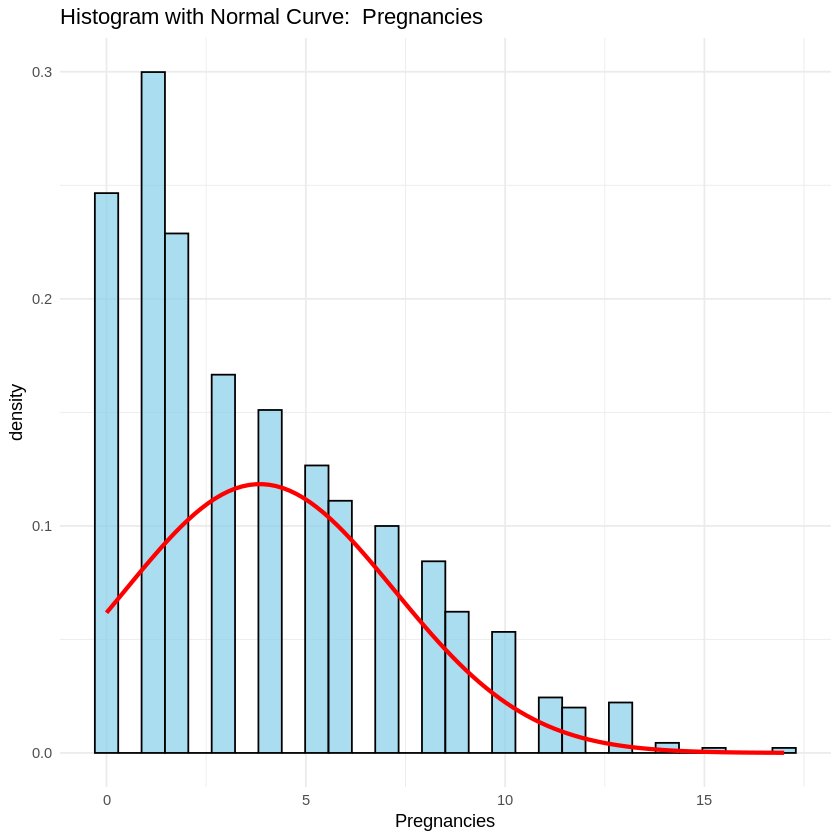

Shapiro-Wilk Test:
Statistic: 0.9042813 
P-value: 1.609257e-21 
Conclusion: Data is NOT normally distributed (Reject H0).


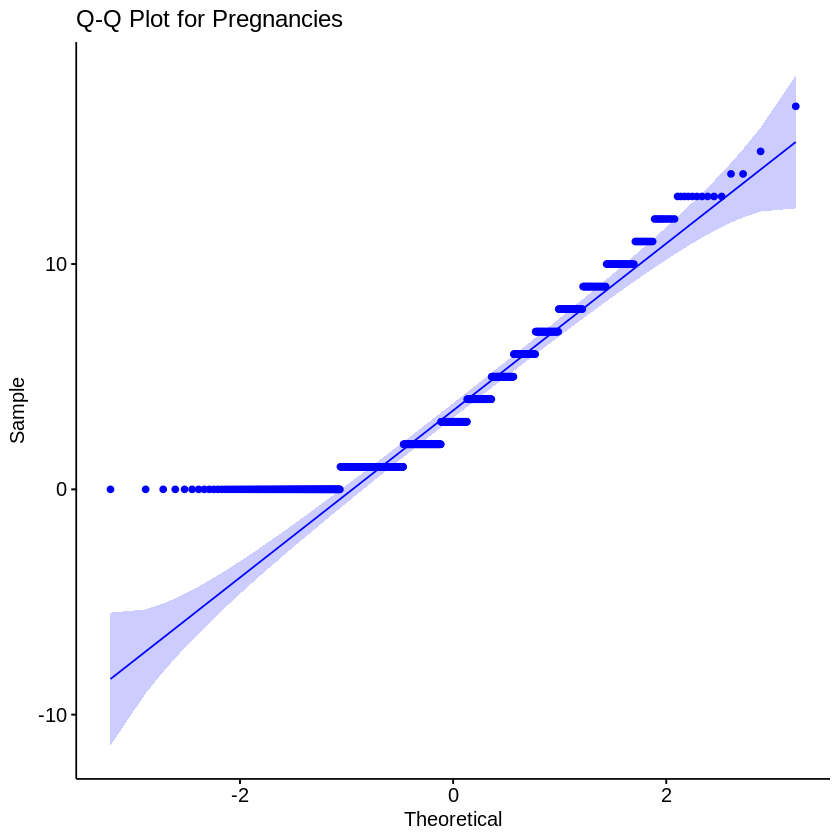

In [ ]:
features <- c("Pregnancies", "Glucose", "BloodPressure", "SkinThickness",
              "Insulin", "BMI", "DiabetesPedigreeFunction", "Age")

check_normality(features[1])


Analyzing Feature: Glucose 


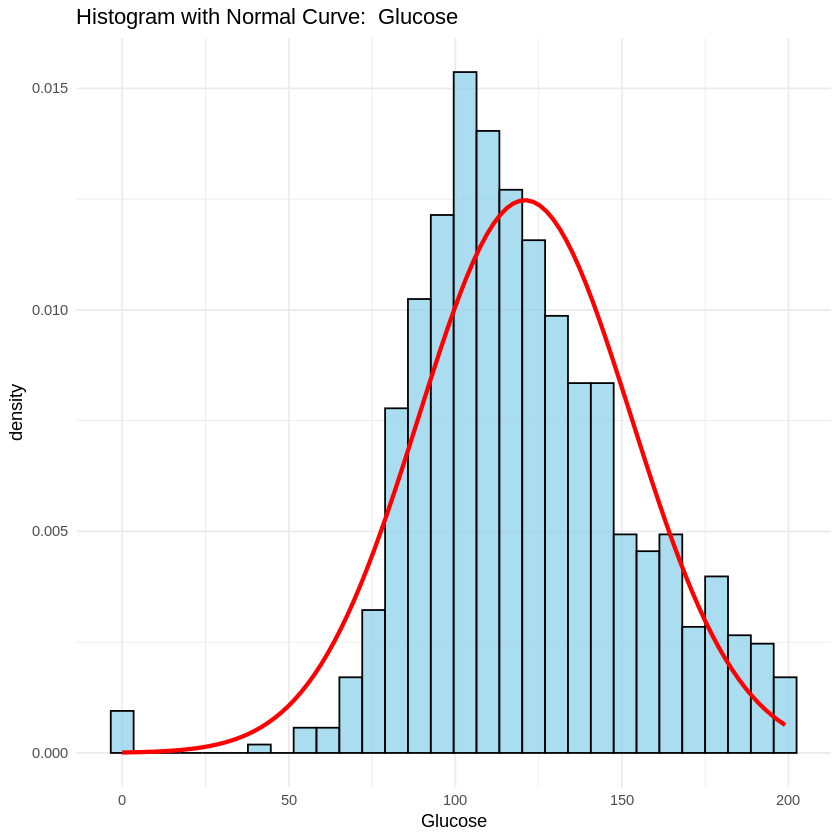

Shapiro-Wilk Test:
Statistic: 0.9701038 
P-value: 1.986348e-11 
Conclusion: Data is NOT normally distributed (Reject H0).


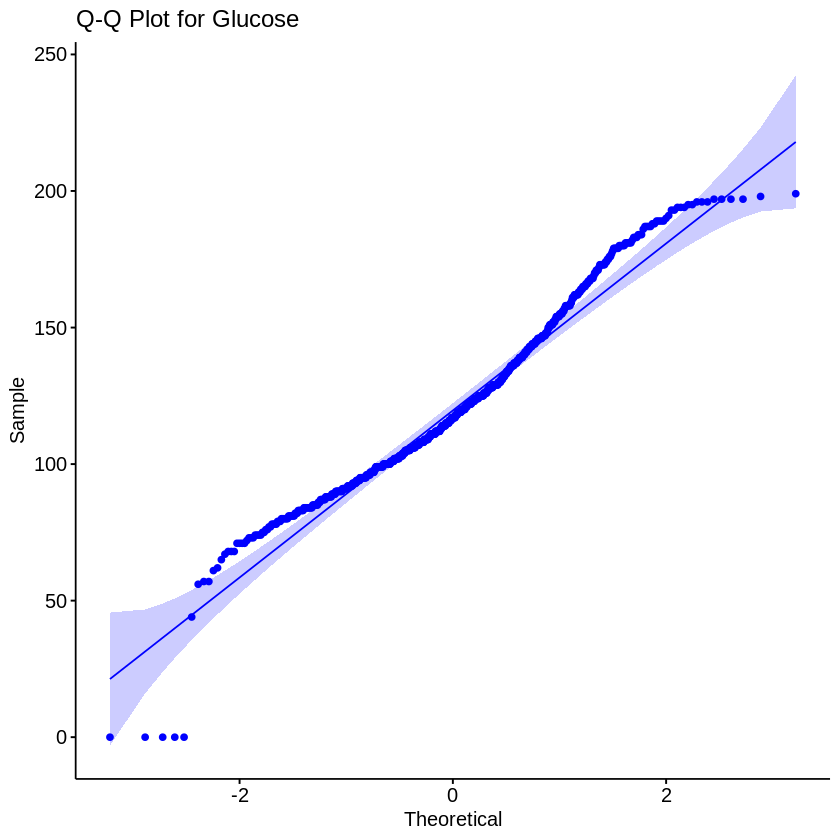

In [ ]:
check_normality(features[2])


Analyzing Feature: BloodPressure 


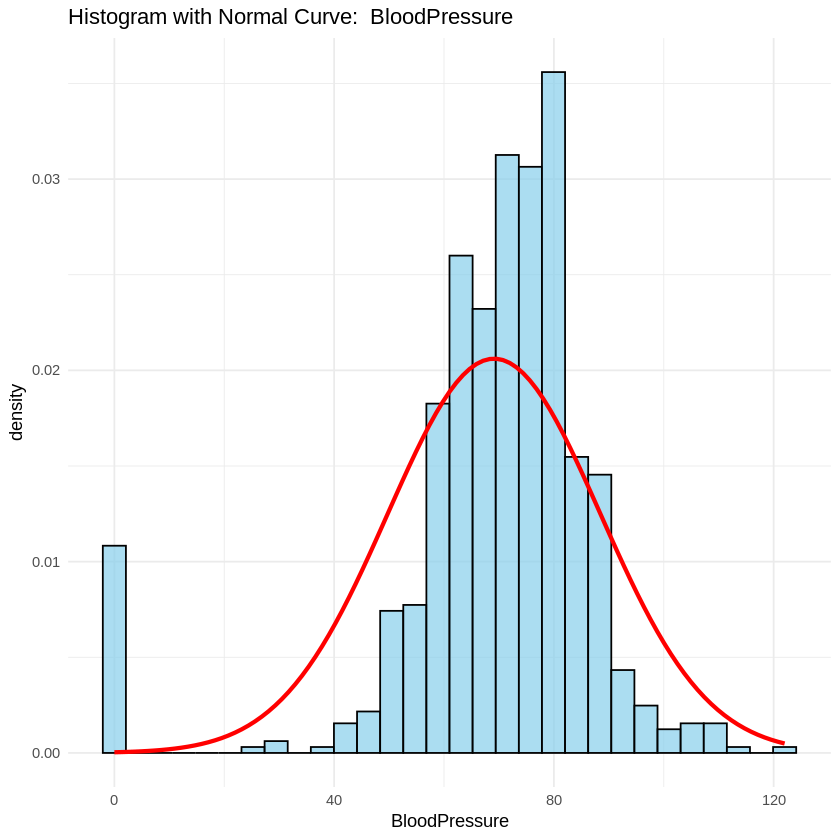

Shapiro-Wilk Test:
Statistic: 0.8189219 
P-value: 1.584162e-28 
Conclusion: Data is NOT normally distributed (Reject H0).


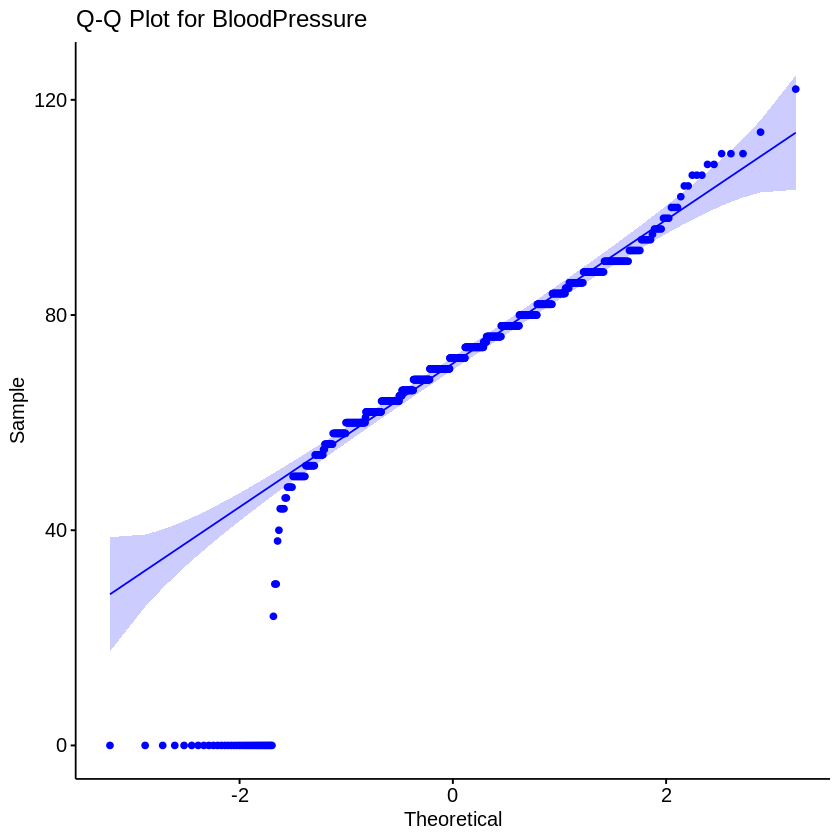

In [ ]:
check_normality(features[3])


Analyzing Feature: SkinThickness 


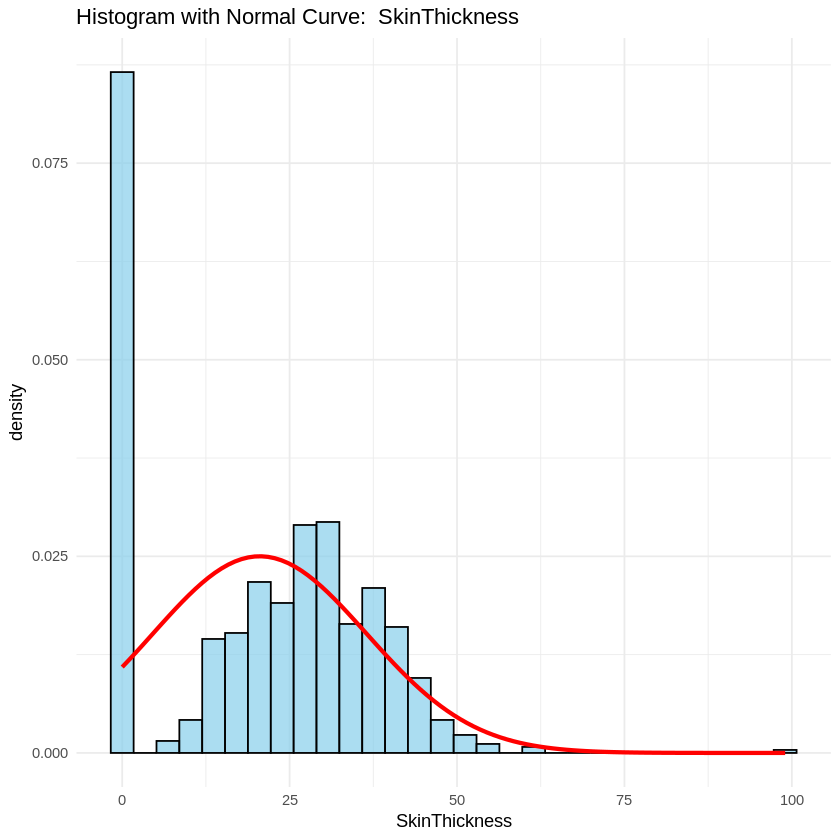

Shapiro-Wilk Test:
Statistic: 0.9046277 
P-value: 1.751754e-21 
Conclusion: Data is NOT normally distributed (Reject H0).


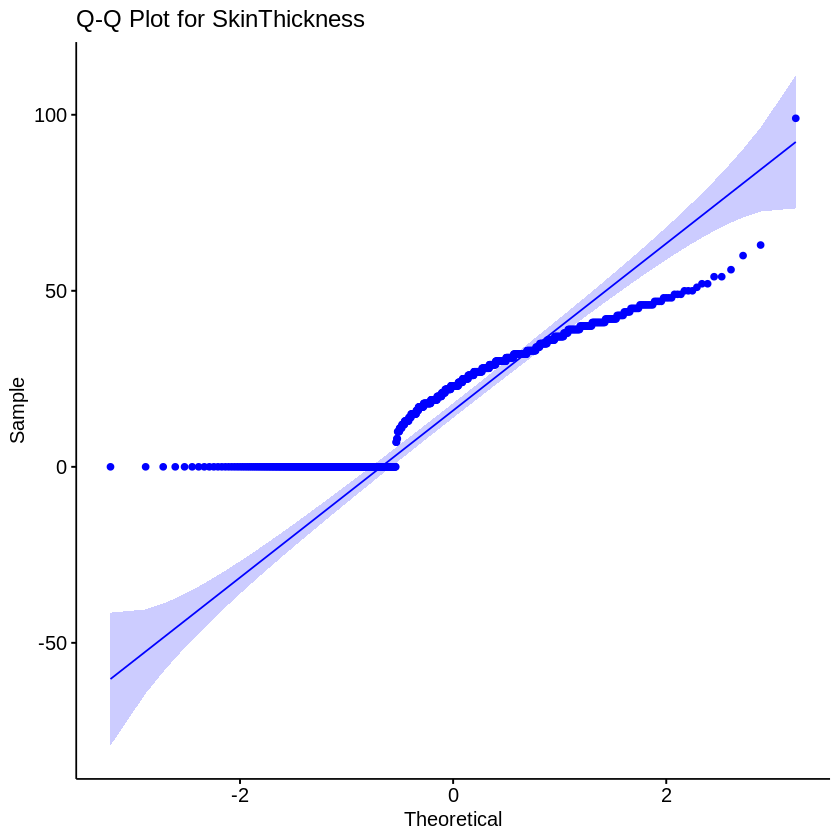

In [ ]:
check_normality(features[4])


Analyzing Feature: Insulin 


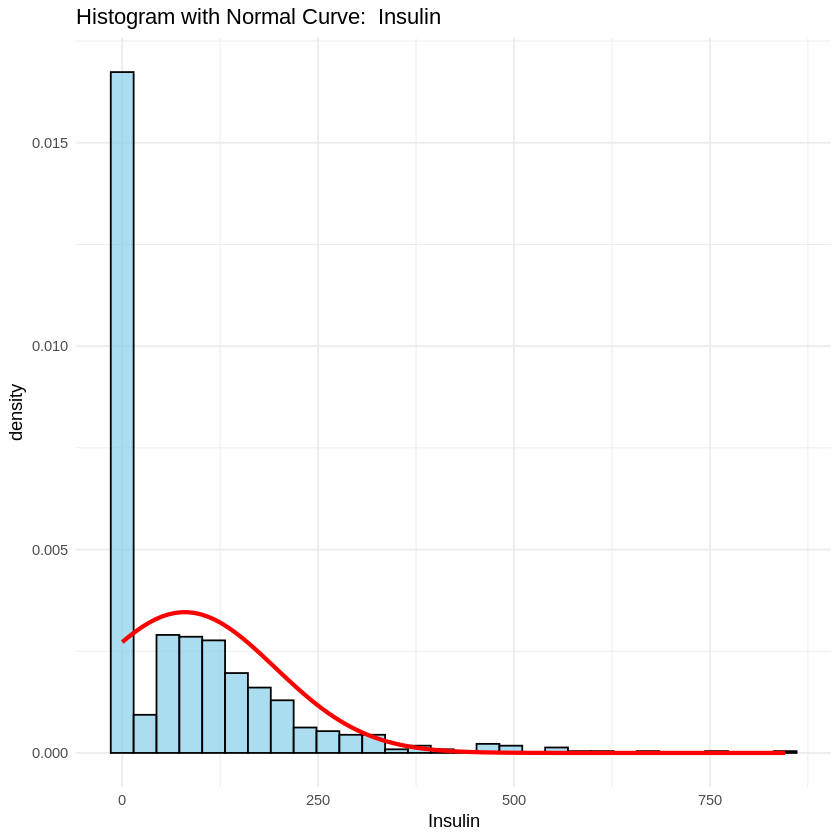

Shapiro-Wilk Test:
Statistic: 0.7220197 
P-value: 7.914332e-34 
Conclusion: Data is NOT normally distributed (Reject H0).


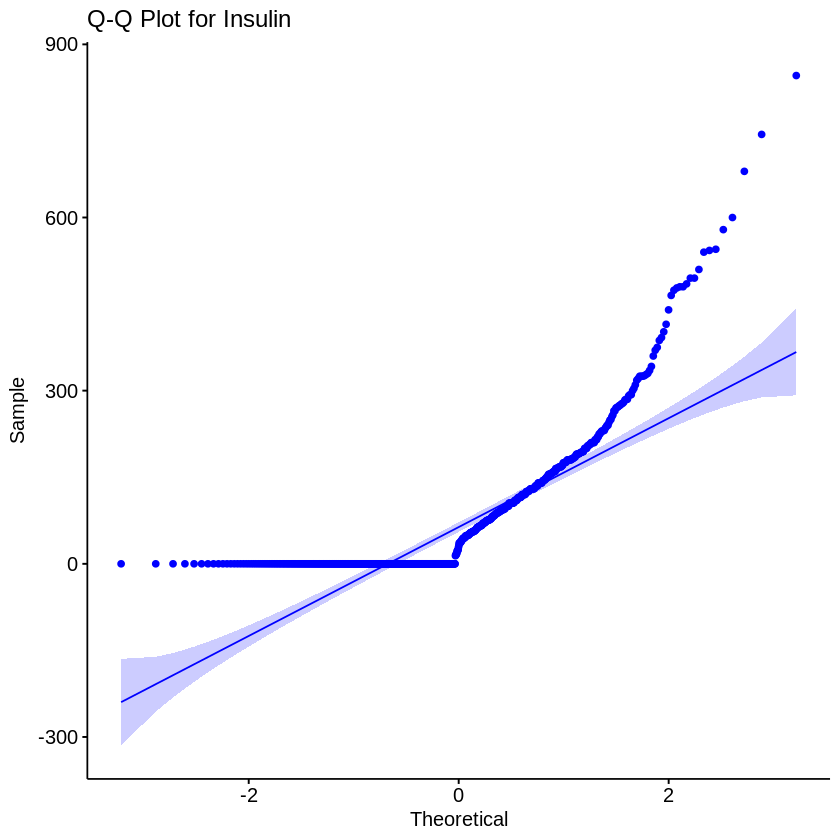

In [ ]:
check_normality(features[5])


Analyzing Feature: BMI 


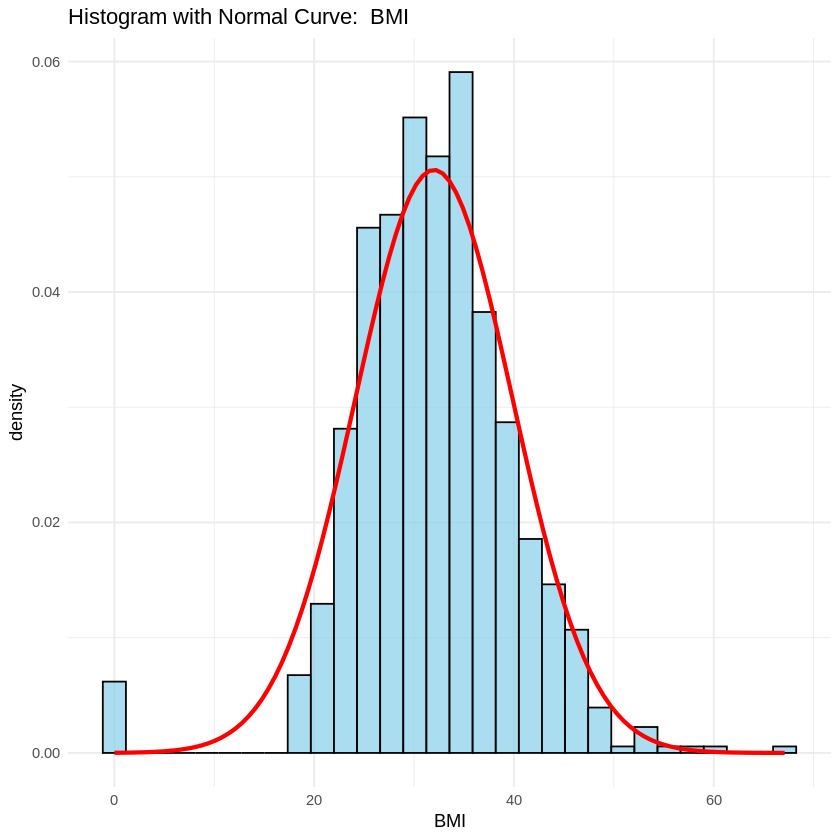

Shapiro-Wilk Test:
Statistic: 0.9499903 
P-value: 1.841652e-15 
Conclusion: Data is NOT normally distributed (Reject H0).


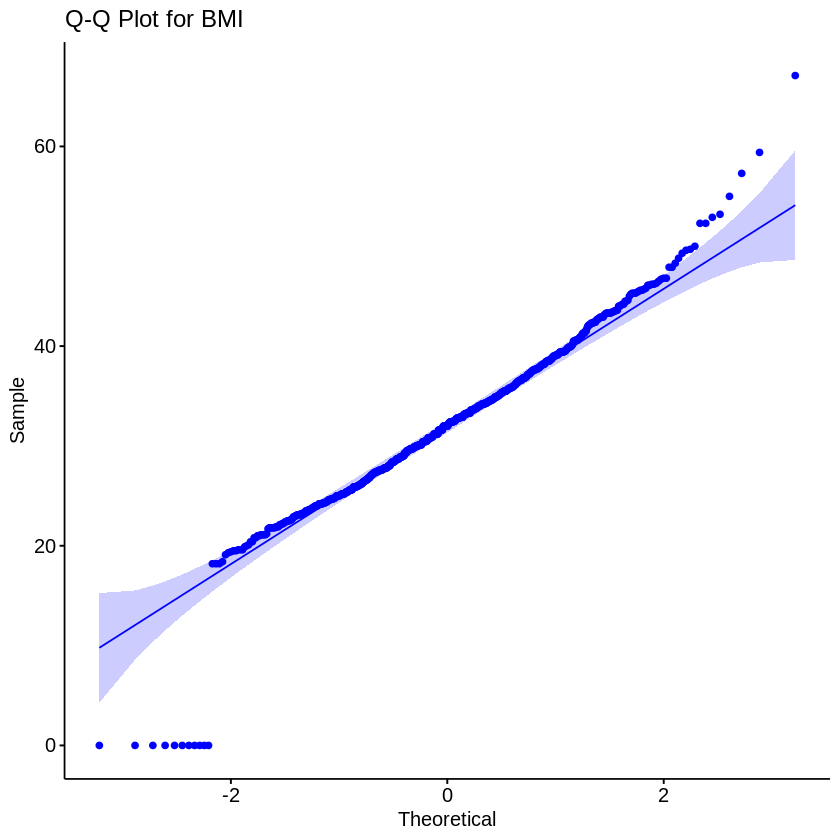

In [ ]:
check_normality(features[6])


Analyzing Feature: DiabetesPedigreeFunction 


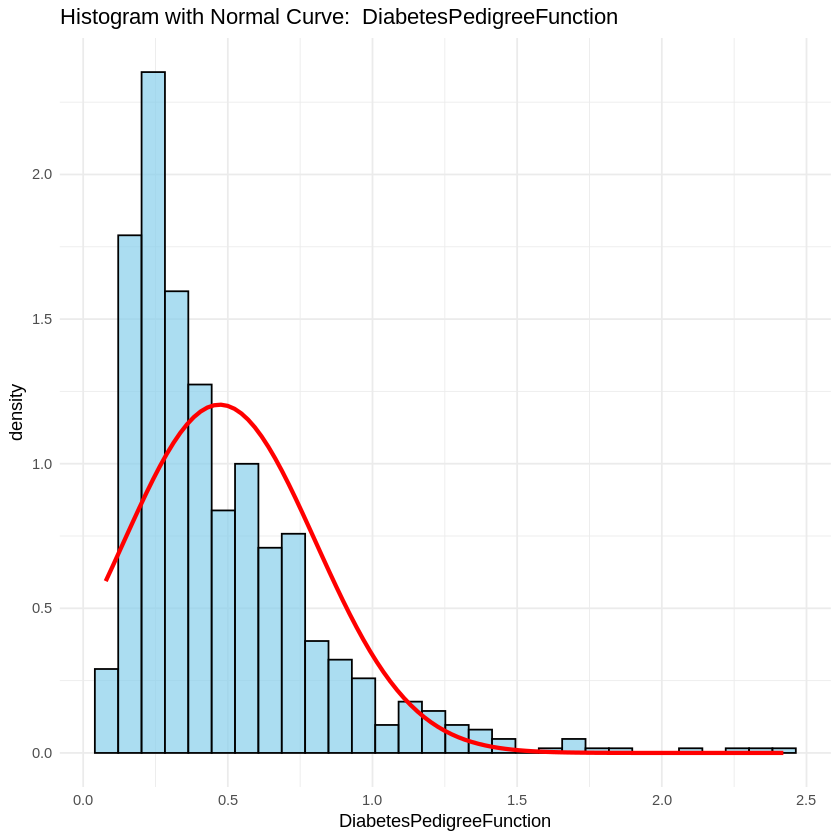

Shapiro-Wilk Test:
Statistic: 0.8365181 
P-value: 2.477506e-27 
Conclusion: Data is NOT normally distributed (Reject H0).


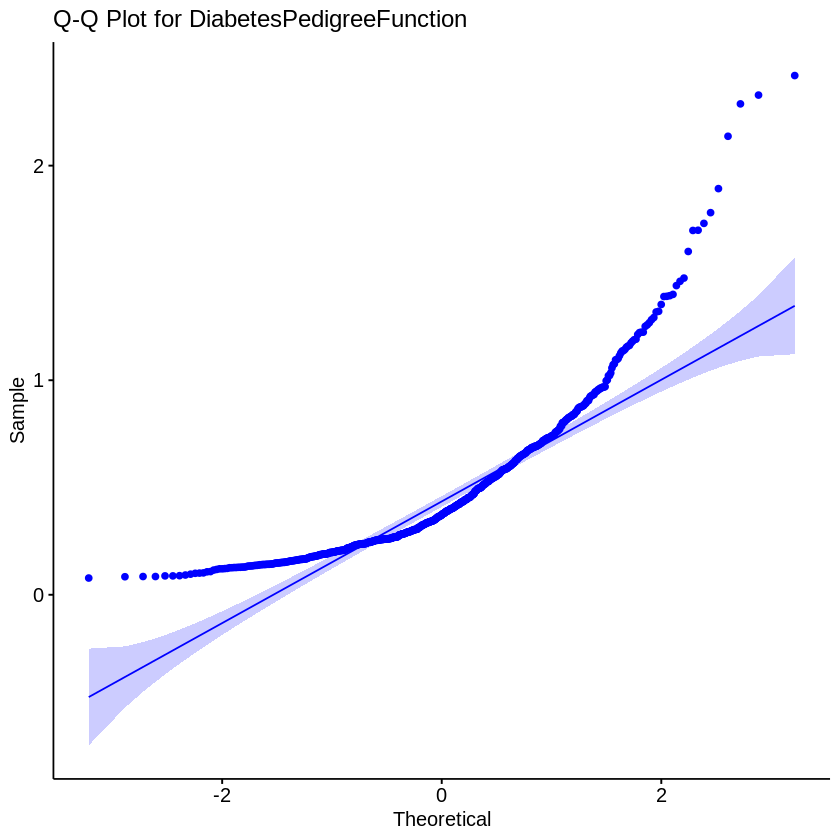

In [ ]:
check_normality(features[7])


Analyzing Feature: Age 


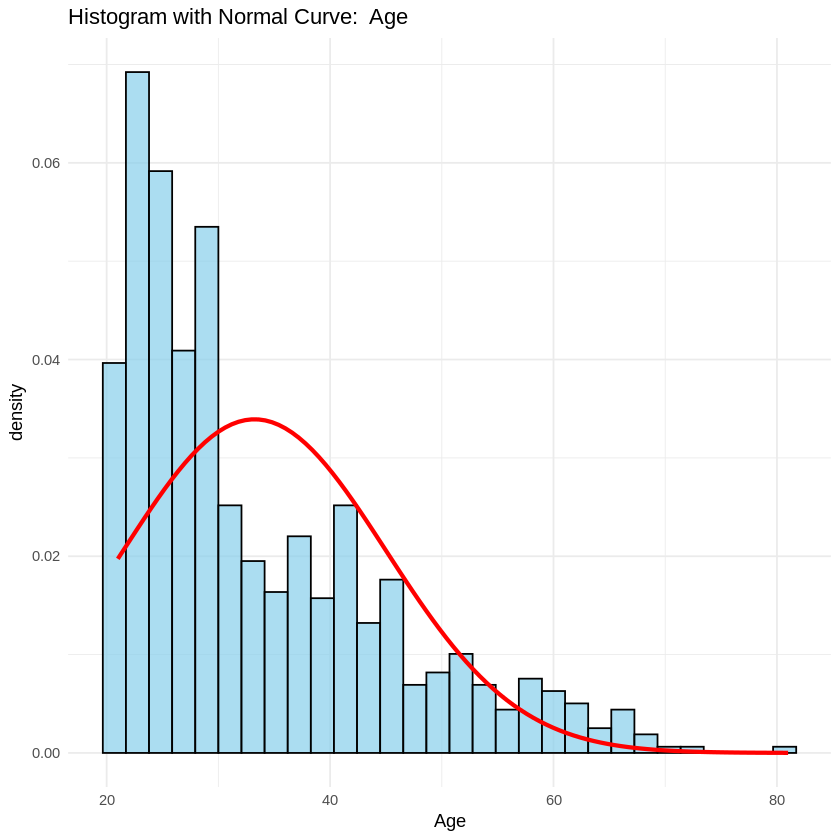

Shapiro-Wilk Test:
Statistic: 0.8747669 
P-value: 2.402274e-24 
Conclusion: Data is NOT normally distributed (Reject H0).


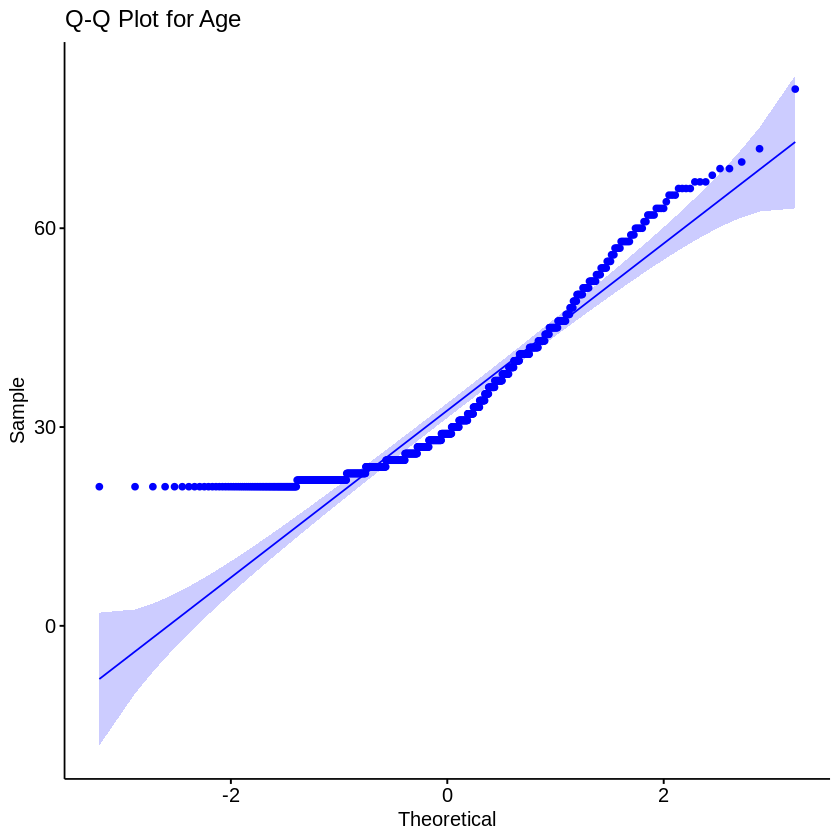

In [ ]:
check_normality(features[8])

## Normality check on data without outliers

In [ ]:
library(ggplot2)
library(ggpubr)

remove_outliers <- function(data, feature) {
  Q1 <- quantile(data[[feature]], 0.25, na.rm = TRUE)
  Q3 <- quantile(data[[feature]], 0.75, na.rm = TRUE)
  IQR <- Q3 - Q1
  lower_bound <- Q1 - 1.5 * IQR
  upper_bound <- Q3 + 1.5 * IQR

  data <- data[data[[feature]] >= lower_bound & data[[feature]] <= upper_bound, ]
  return(data)
}

plot_boxplot_before <- function(data, feature) {
  cat("\nAnalyzing Feature:", feature, "\n")

  # Boxplot before removing outliers
  boxplot_before <- ggplot(data, aes_string(x = "1", y = feature)) +
    geom_boxplot(fill = "skyblue", color = "black", alpha = 0.7, outlier.color = "red") +
    labs(
      title = paste("Boxplot (Before Removing Outliers):", feature),
      x = "",
      y = feature
    ) +
    theme_minimal()

  print(boxplot_before)
}

check_normality_without_outlier <- function(feature) {

  data_no_outliers <- remove_outliers(data, feature)

  # Histogram with normal curve
  values <- data_no_outliers[[feature]]
  hist_data <- ggplot(data_no_outliers, aes_string(x = feature)) +
    geom_histogram(aes(y = ..density..), bins = 30, fill = "skyblue", color = "black", alpha = 0.7) +
    stat_function(fun = dnorm, args = list(mean = mean(values, na.rm = TRUE), sd = sd(values, na.rm = TRUE)),
                  color = "red", size = 1.2) +
    ggtitle(paste("Histogram with Normal Curve: ", feature)) +
    theme_minimal()
  print(hist_data)

  # Q-Q Plot
  qq_plot <- ggplot(data_no_outliers, aes(sample = values)) +
    geom_qq(color = "blue") +
    geom_qq_line(color = "red") +
    ggtitle(paste("Q-Q Plot for", feature)) +
    theme_minimal()
  print(qq_plot)

  # Shapiro-Wilk Test
  shapiro_test <- shapiro.test(values)
  cat("Shapiro-Wilk Test:\n")
  cat("Statistic:", shapiro_test$statistic, "\n")
  cat("P-value:", shapiro_test$p.value, "\n")
  if (shapiro_test$p.value < 0.05) {
    cat("Conclusion: Data is NOT normally distributed (Reject H0).\n")
  } else {
    cat("Conclusion: Data is normally distributed (Fail to reject H0).\n")
  }
}

In [ ]:
features <- c("Pregnancies", "Glucose", "BloodPressure", "SkinThickness",
              "Insulin", "BMI", "DiabetesPedigreeFunction", "Age")




Analyzing Feature: Pregnancies 


Warning message:
“`aes_string()` was deprecated in ggplot2 3.0.0.
ℹ Please use tidy evaluation idioms with `aes()`.
ℹ See also `vignette("ggplot2-in-packages")` for more information.”
Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”
Warning message:
“The dot-dot notation (`..density..`) was deprecated in ggplot2 3.4.0.
ℹ Please use `after_stat(density)` instead.”


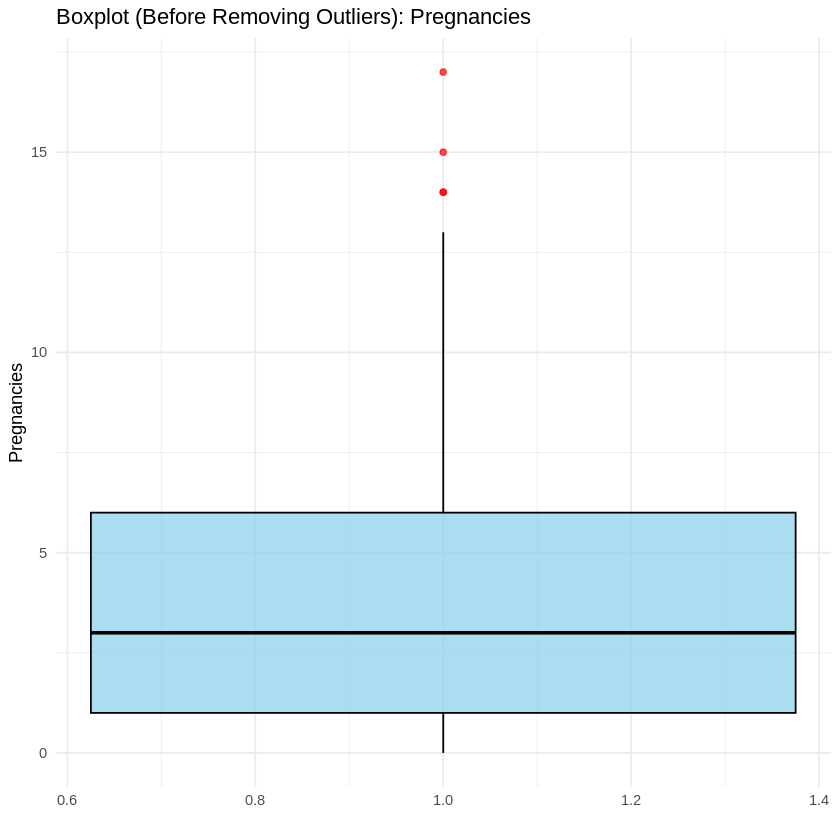

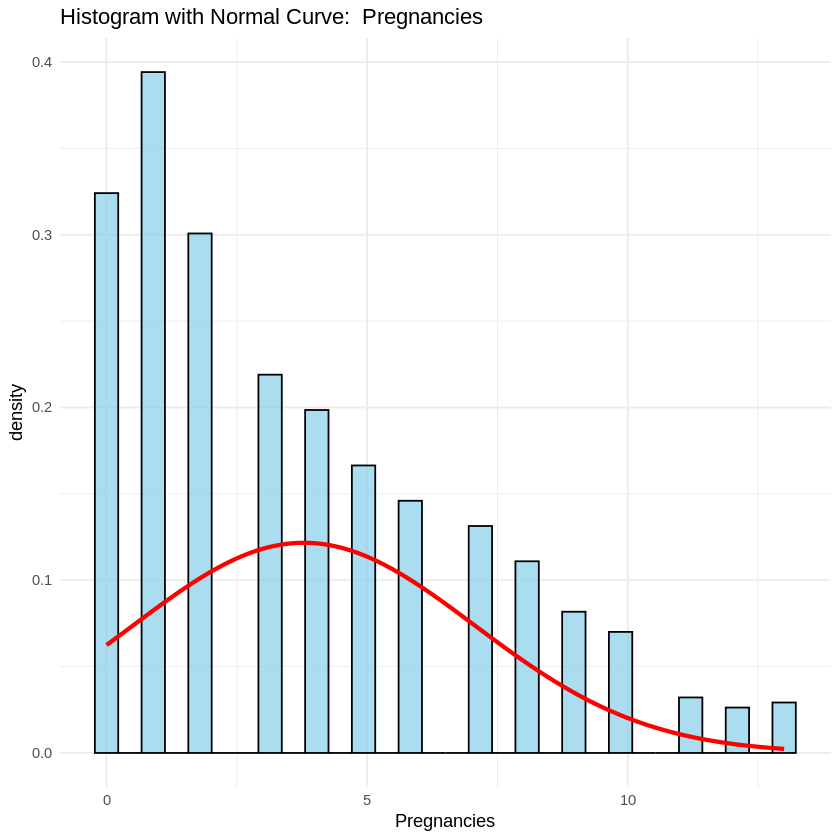

Shapiro-Wilk Test:
Statistic: 0.9058255 
P-value: 2.680842e-21 
Conclusion: Data is NOT normally distributed (Reject H0).


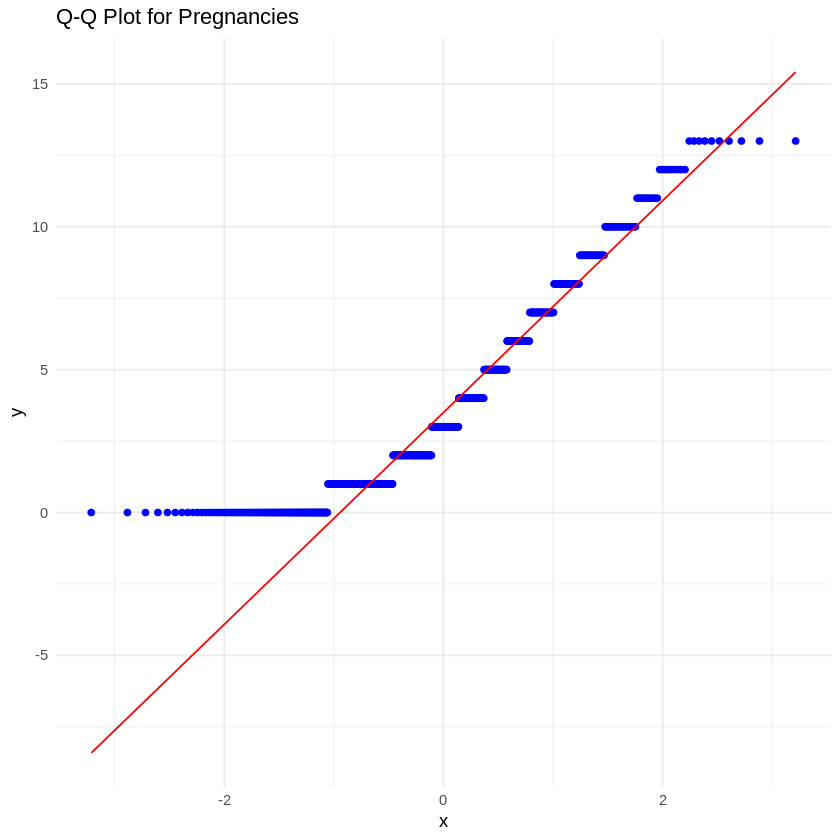

In [ ]:
plot_boxplot_before(data,features[1])
check_normality_without_outlier(features[1])


Analyzing Feature: Glucose 


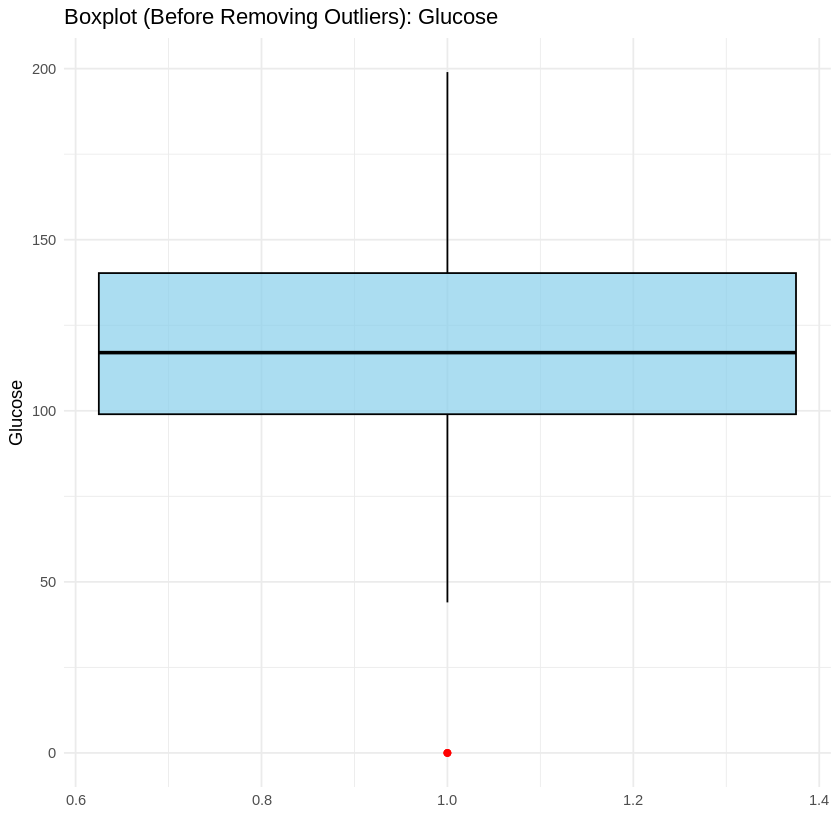

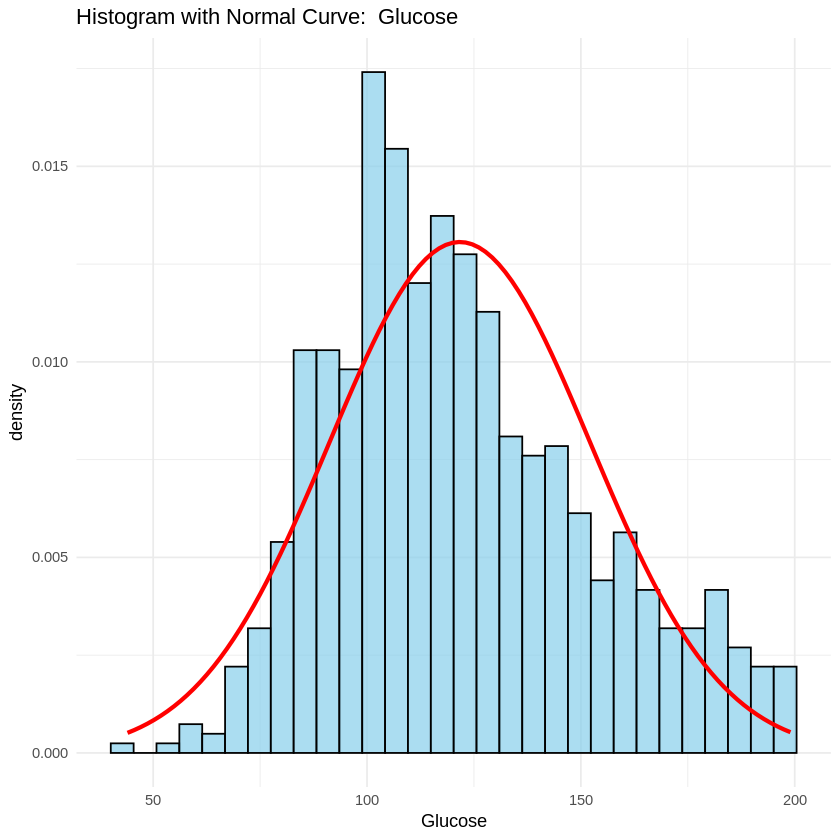

Shapiro-Wilk Test:
Statistic: 0.9696409 
P-value: 1.720326e-11 
Conclusion: Data is NOT normally distributed (Reject H0).


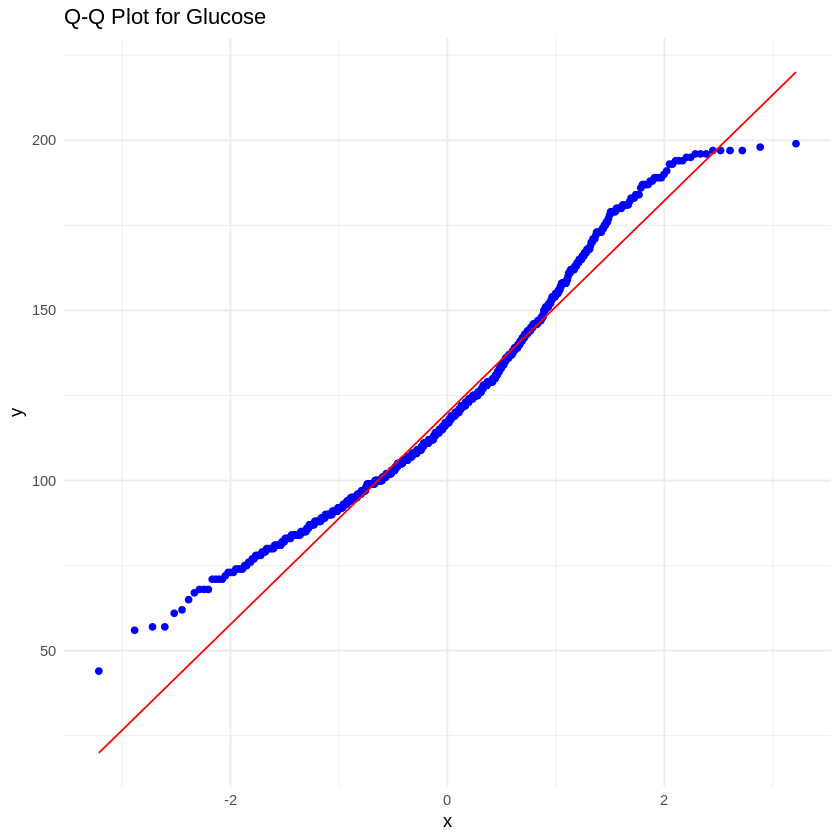

In [ ]:
plot_boxplot_before(data,features[2])
check_normality_without_outlier(features[2])


Analyzing Feature: BloodPressure 


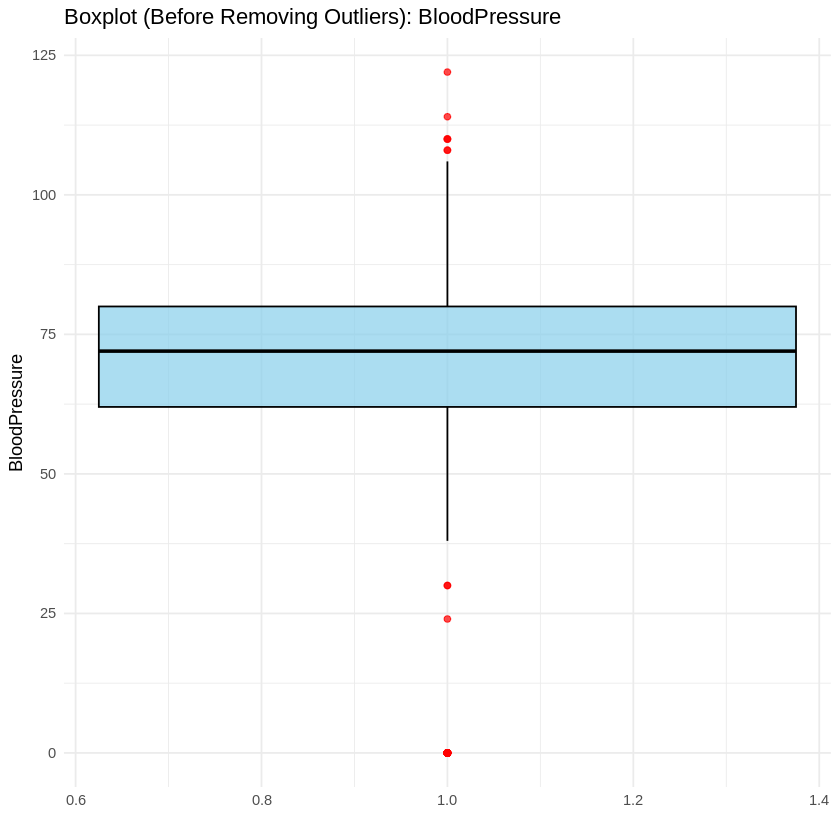

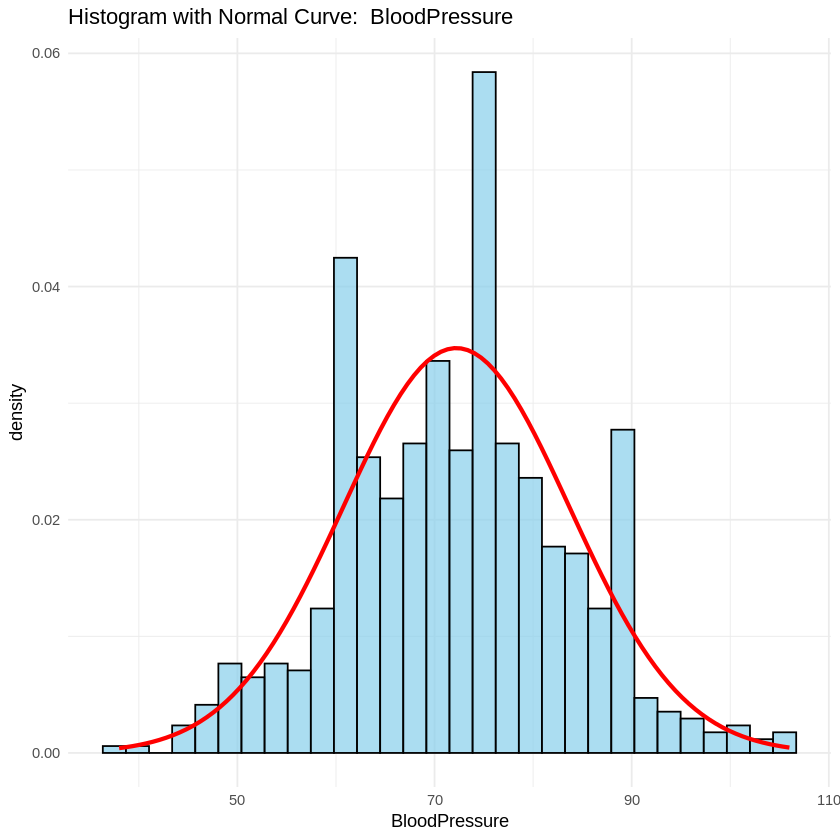

Shapiro-Wilk Test:
Statistic: 0.9960979 
P-value: 0.06949276 
Conclusion: Data is normally distributed (Fail to reject H0).


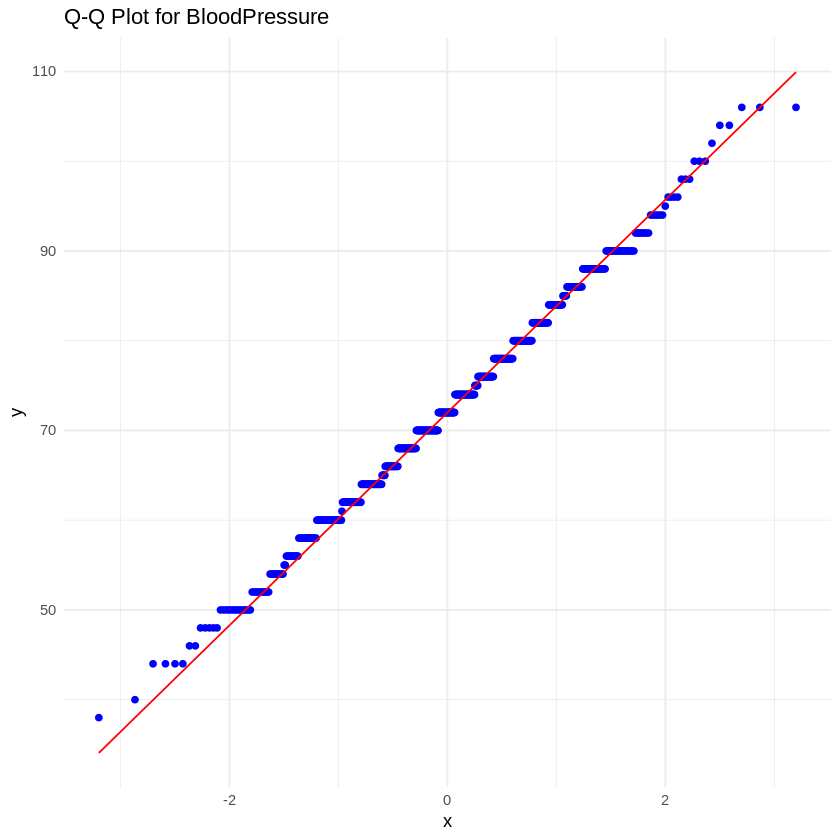

In [ ]:
plot_boxplot_before(data,features[3])
check_normality_without_outlier(features[3])


Analyzing Feature: SkinThickness 


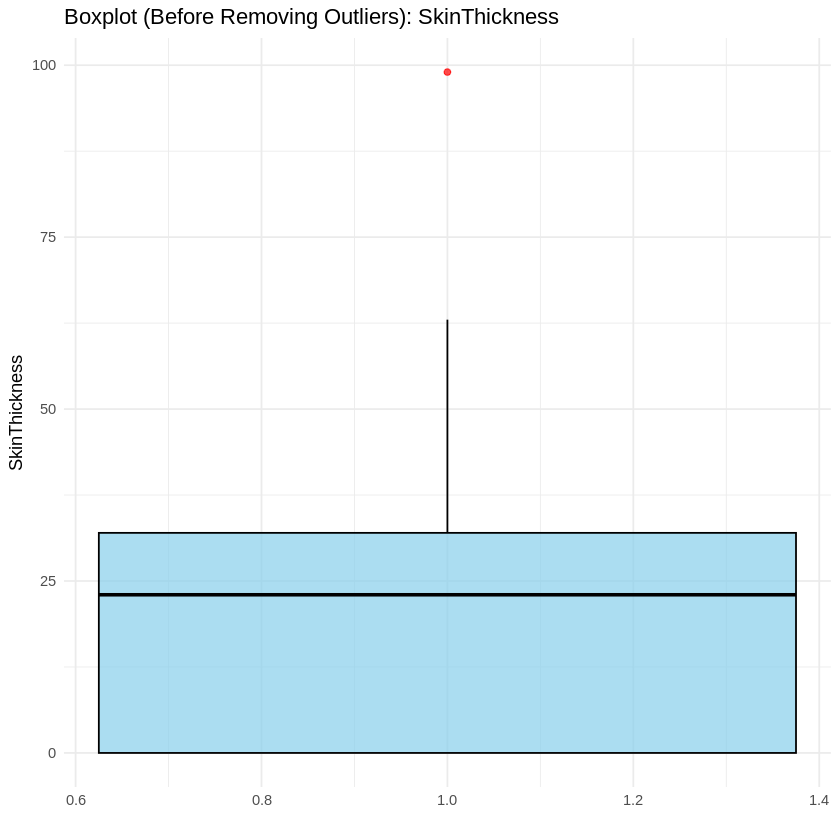

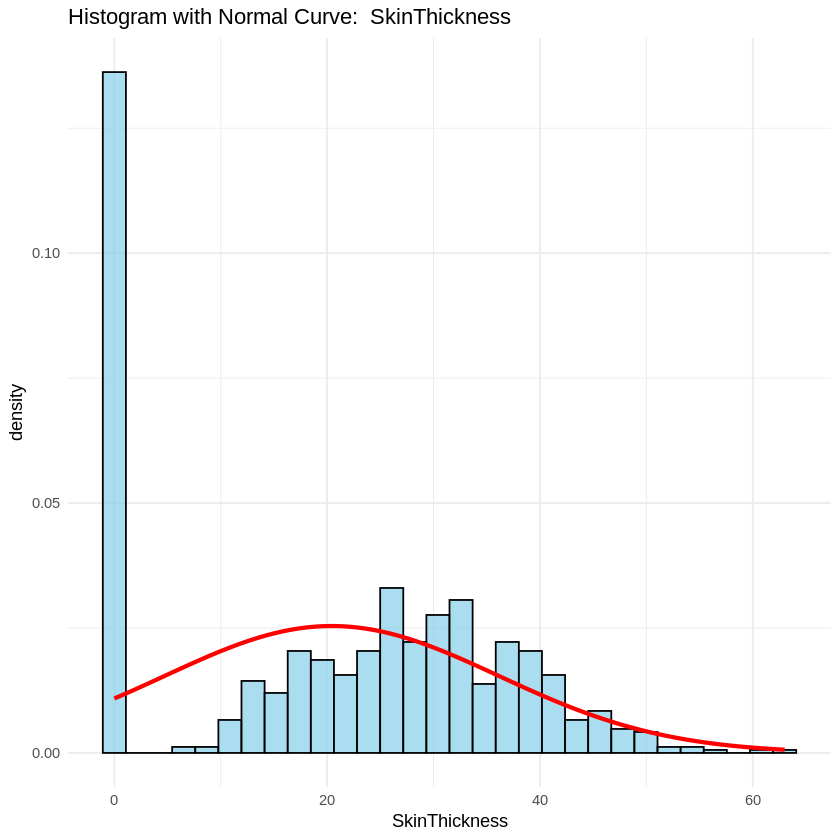

Shapiro-Wilk Test:
Statistic: 0.9047591 
P-value: 1.869196e-21 
Conclusion: Data is NOT normally distributed (Reject H0).


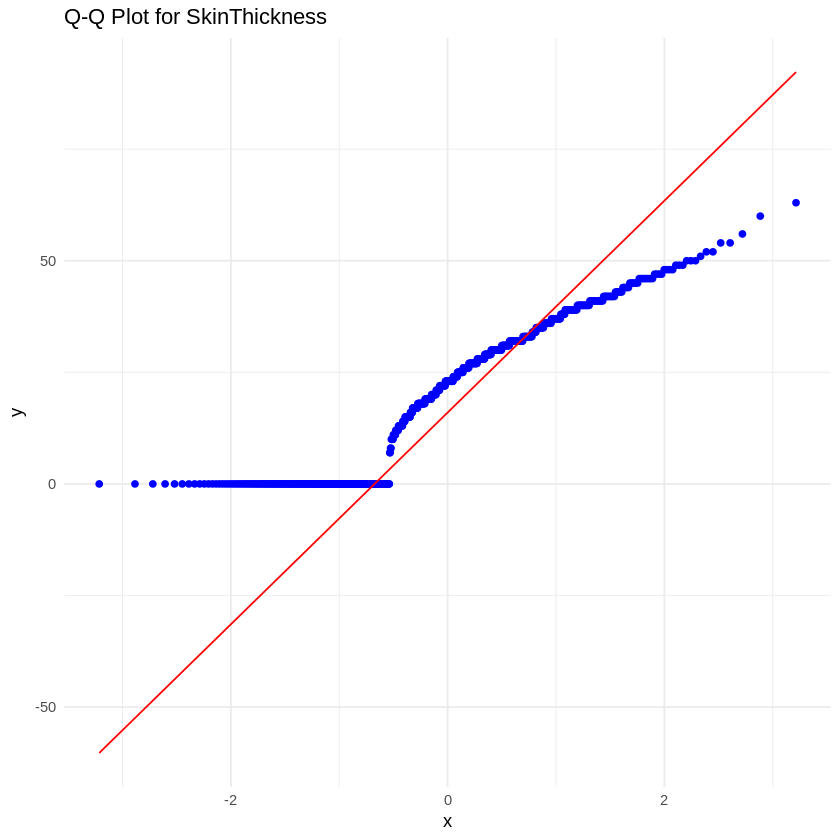

In [ ]:
plot_boxplot_before(data,features[4])
check_normality_without_outlier(features[4])


Analyzing Feature: Insulin 


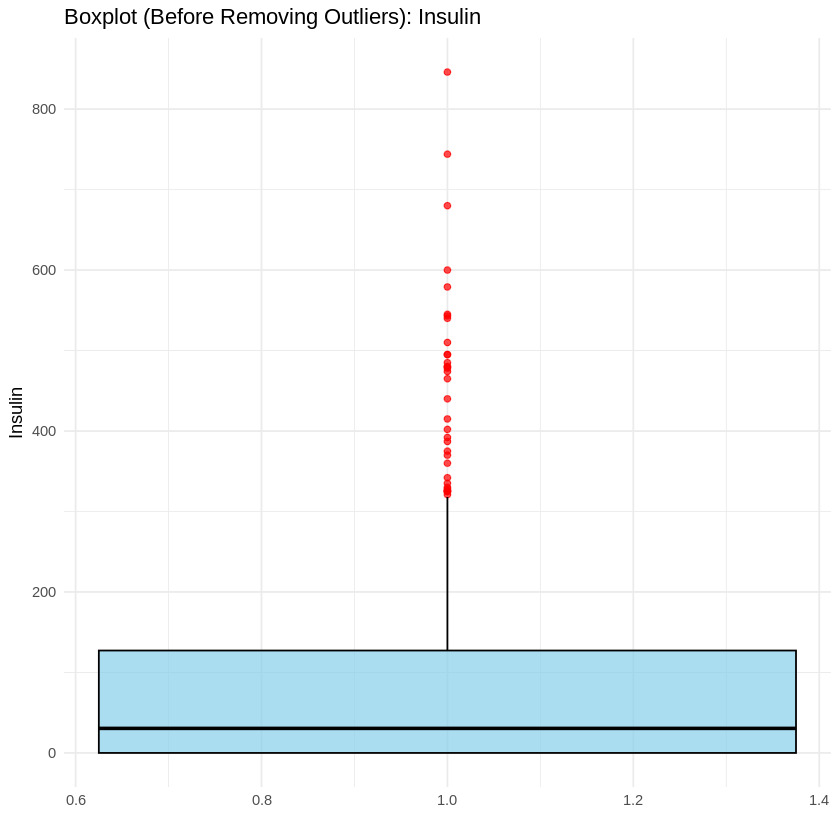

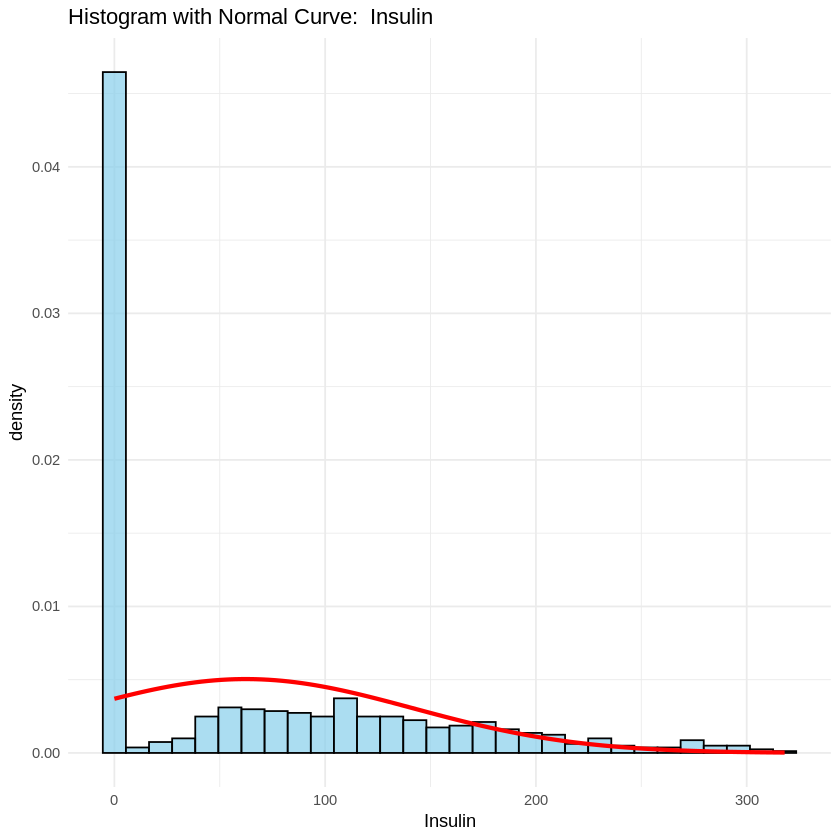

Shapiro-Wilk Test:
Statistic: 0.7899396 
P-value: 1.056201e-29 
Conclusion: Data is NOT normally distributed (Reject H0).


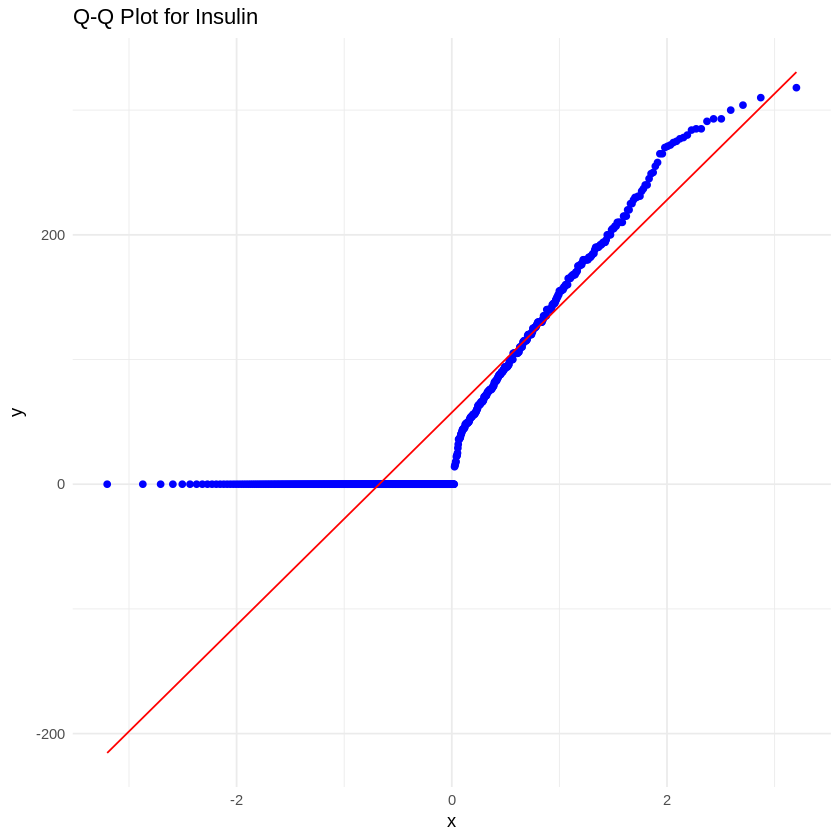

In [ ]:
plot_boxplot_before(data,features[5])
check_normality_without_outlier(features[5])


Analyzing Feature: BMI 


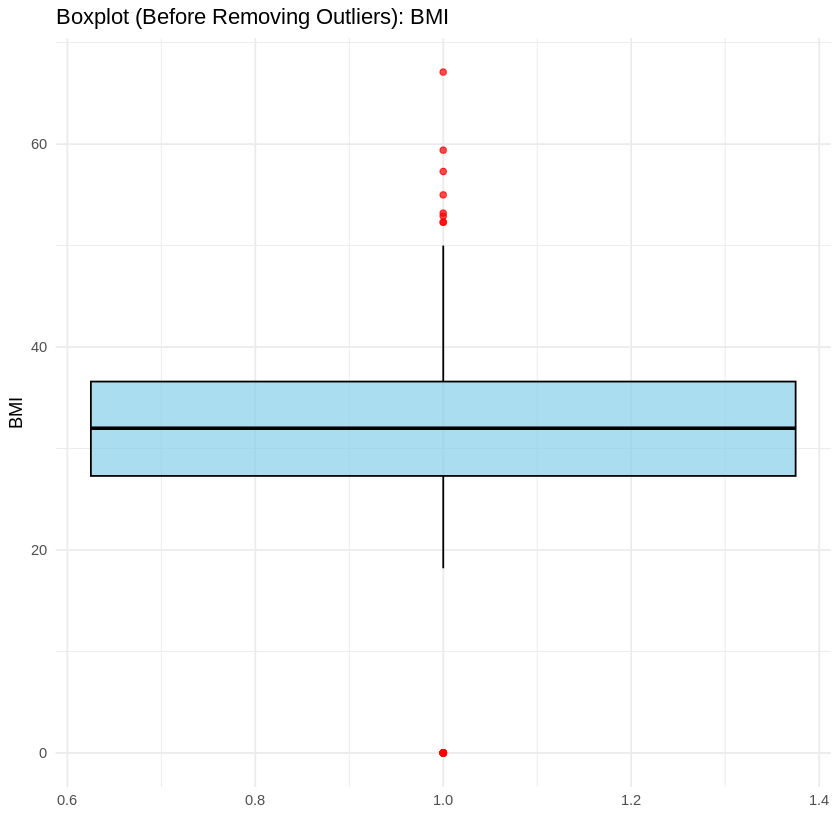

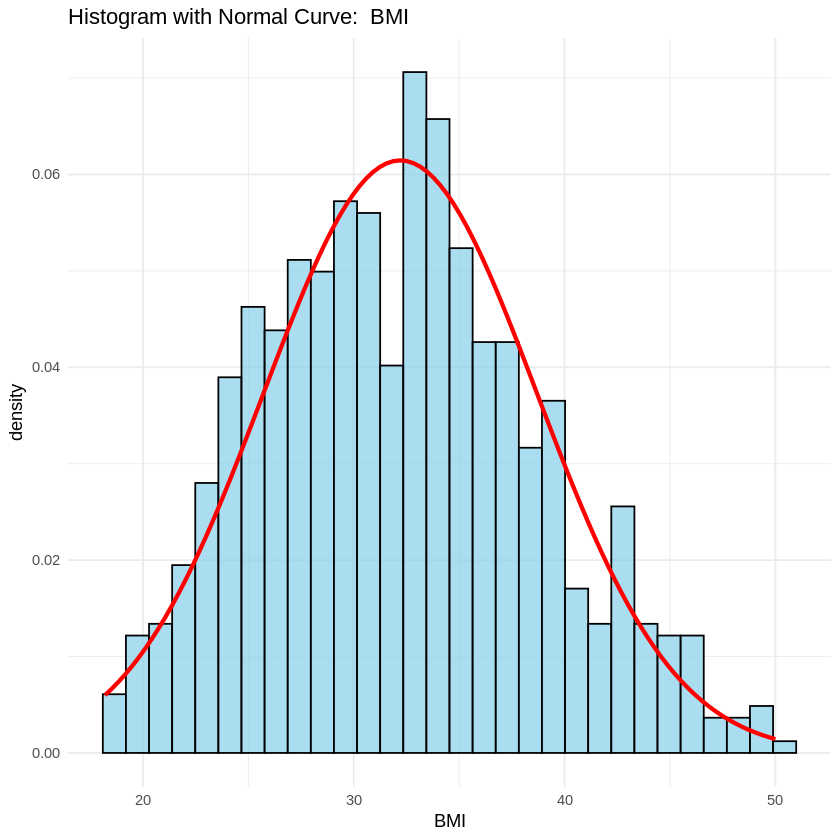

Shapiro-Wilk Test:
Statistic: 0.990062 
P-value: 5.963265e-05 
Conclusion: Data is NOT normally distributed (Reject H0).


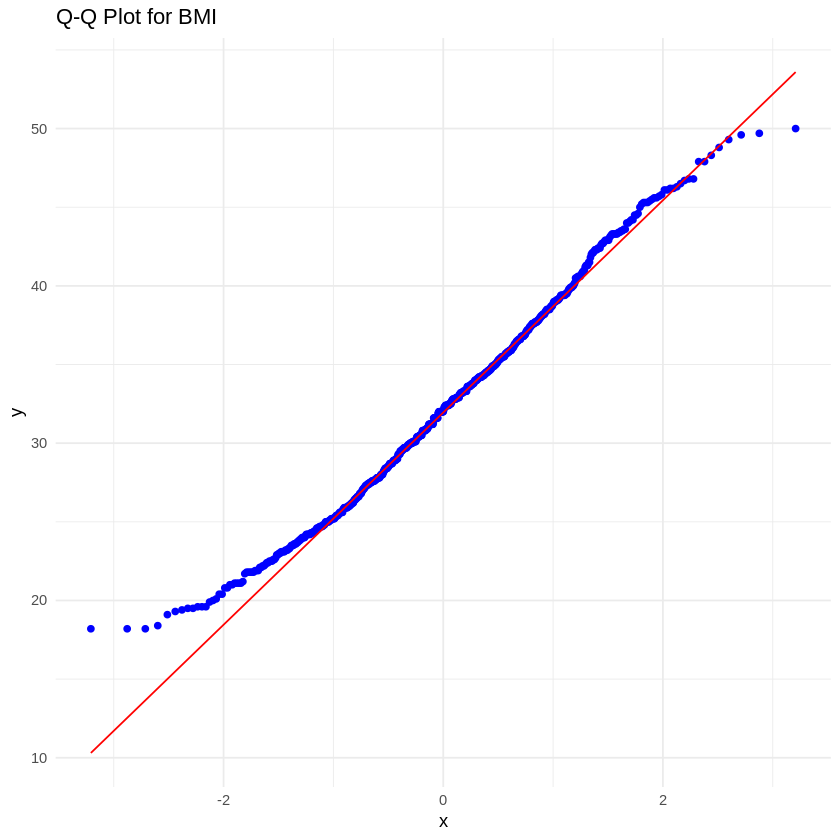

In [ ]:
plot_boxplot_before(data,features[6])
check_normality_without_outlier(features[6])


Analyzing Feature: DiabetesPedigreeFunction 


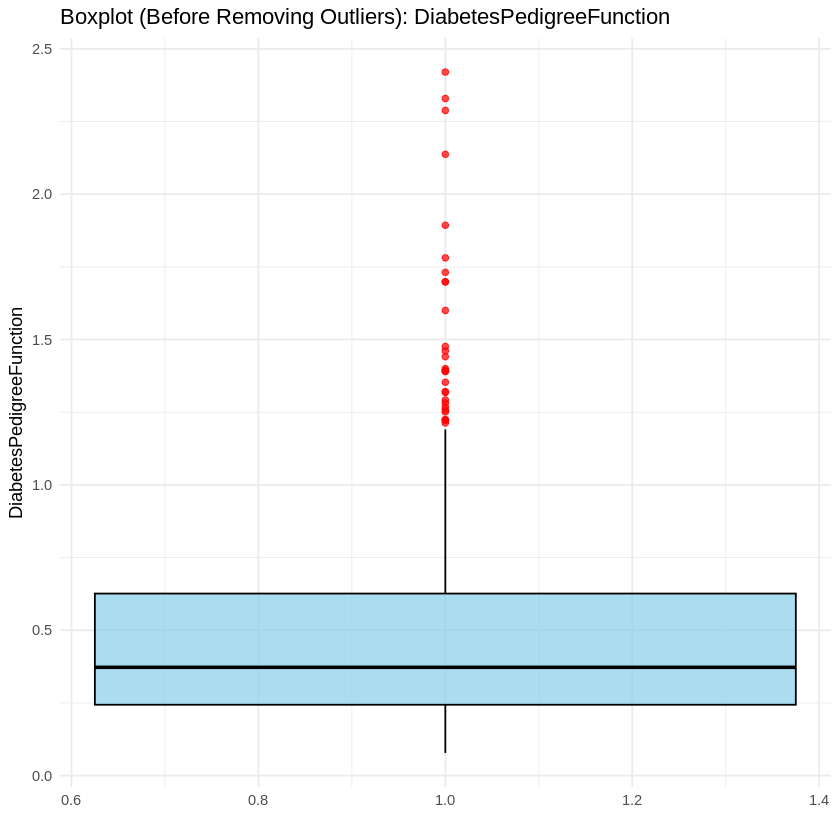

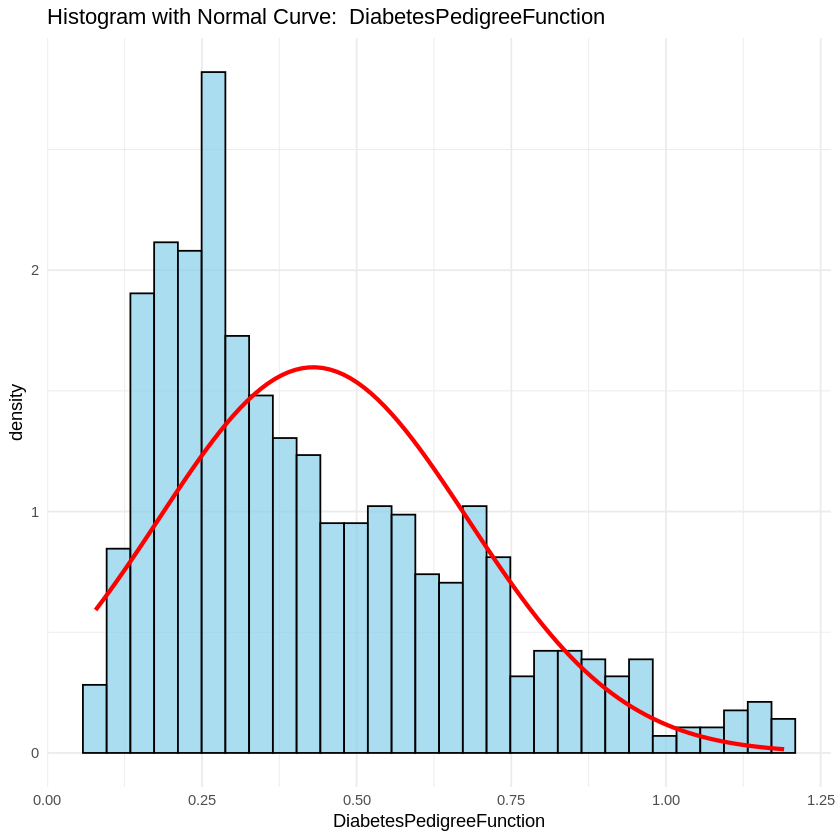

Shapiro-Wilk Test:
Statistic: 0.9177811 
P-value: 1.321337e-19 
Conclusion: Data is NOT normally distributed (Reject H0).


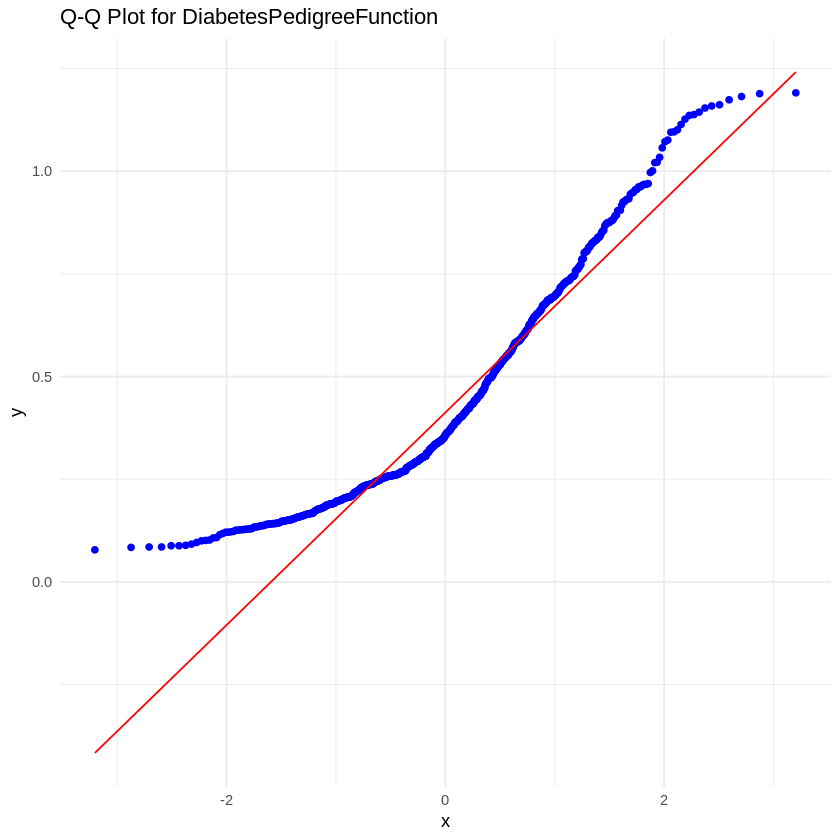

In [ ]:
plot_boxplot_before(data,features[7])
check_normality_without_outlier(features[7])


Analyzing Feature: Age 


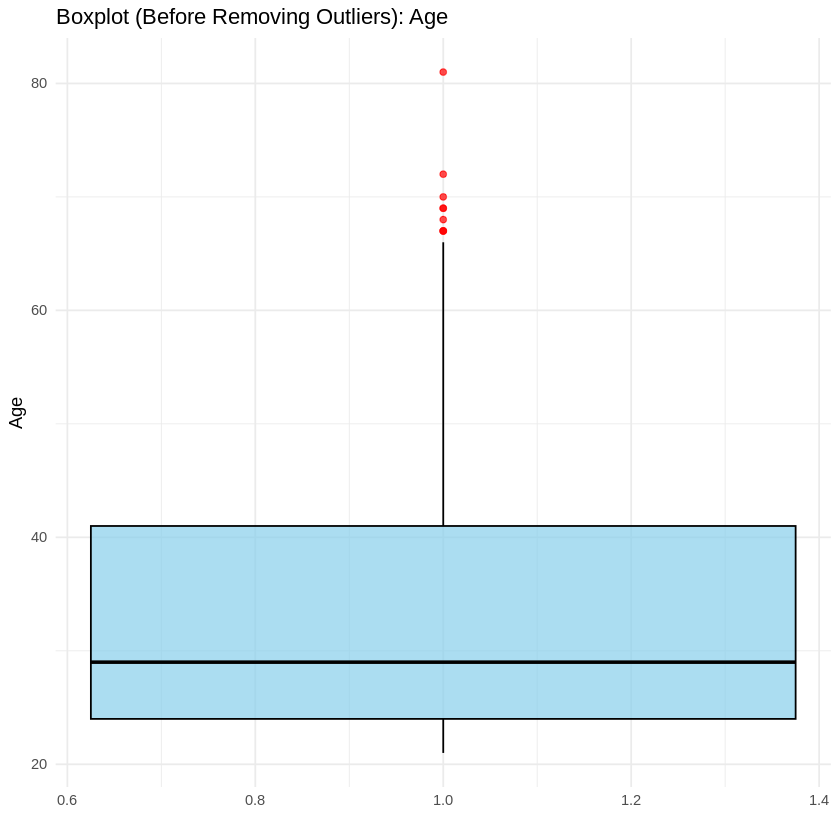

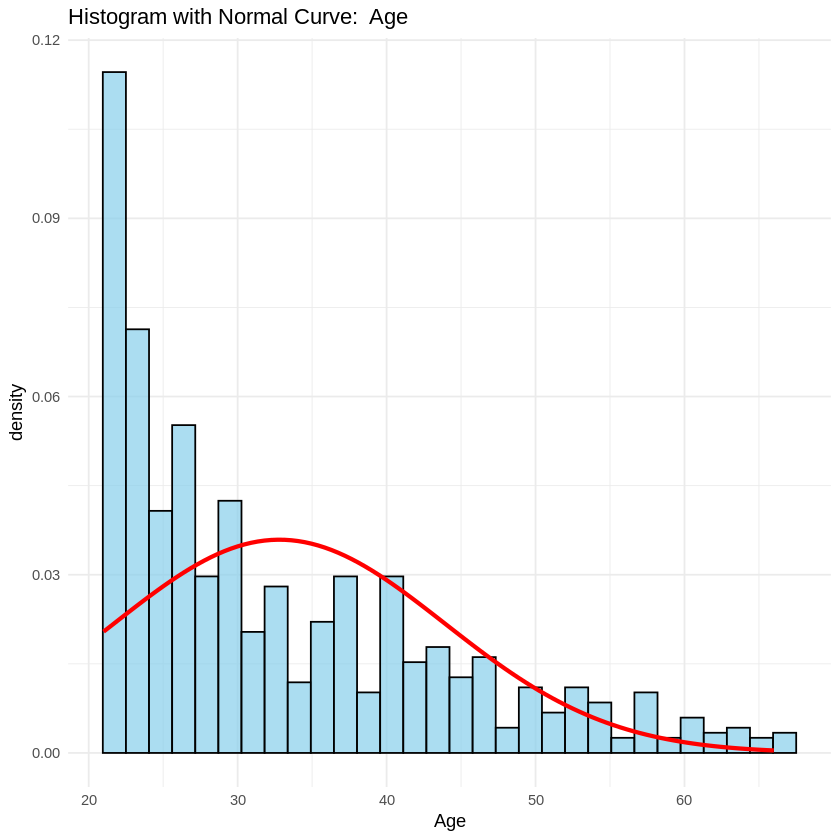

Shapiro-Wilk Test:
Statistic: 0.8807181 
P-value: 1.104027e-23 
Conclusion: Data is NOT normally distributed (Reject H0).


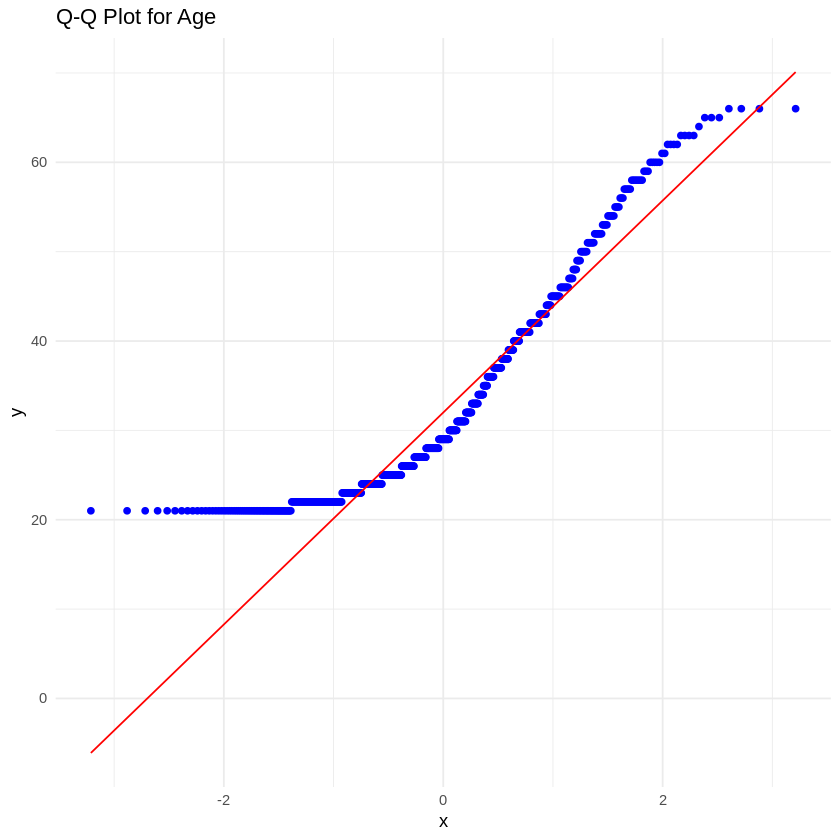

In [ ]:
plot_boxplot_before(data,features[8])
check_normality_without_outlier(features[8])


##  Wilcoxon rank-sum test


In [ ]:
data$Outcome <- as.factor(data$Outcome)

analyze_feature <- function(feature) {
  cat("\nAnalyzing Feature:", feature, "\n")

  # Perform Wilcoxon rank-sum test
  wilcox_result <- wilcox.test(data[[feature]] ~ data$Outcome)
  cat("Wilcoxon Test Results:\n")
  print(wilcox_result)

  p_value <- wilcox_result$p.value
  if (p_value < 0.05) {
    cat("The feature", feature, "significantly differs between Outcome classes (p-value =", round(p_value, 4), ").\n")
  } else {
    cat("The feature", feature, "does not significantly differ between Outcome classes (p-value =", round(p_value, 4), ").\n")
  }
}

for (feature in features) {
  analyze_feature(feature)
}


Analyzing Feature: Pregnancies 
Wilcoxon Test Results:

	Wilcoxon rank sum test with continuity correction

data:  data[[feature]] by data$Outcome
W = 50985, p-value = 3.745e-08
alternative hypothesis: true location shift is not equal to 0

The feature Pregnancies significantly differs between Outcome classes (p-value = 0 ).

Analyzing Feature: Glucose 
Wilcoxon Test Results:

	Wilcoxon rank sum test with continuity correction

data:  data[[feature]] by data$Outcome
W = 28390, p-value < 2.2e-16
alternative hypothesis: true location shift is not equal to 0

The feature Glucose significantly differs between Outcome classes (p-value = 0 ).

Analyzing Feature: BloodPressure 
Wilcoxon Test Results:

	Wilcoxon rank sum test with continuity correction

data:  data[[feature]] by data$Outcome
W = 55414, p-value = 7.559e-05
alternative hypothesis: true location shift is not equal to 0

The feature BloodPressure significantly differs between Outcome classes (p-value = 1e-04 ).

Analyzing Feature


Analyzing Feature: Pregnancies 
Wilcoxon Test Results:

	Wilcoxon rank sum test with continuity correction

data:  data[[feature]] by data$Outcome
W = 50985, p-value = 3.745e-08
alternative hypothesis: true location shift is not equal to 0

The feature Pregnancies significantly differs between Outcome classes (p-value = 0 ).

Analyzing Feature: Glucose 
Wilcoxon Test Results:

	Wilcoxon rank sum test with continuity correction

data:  data[[feature]] by data$Outcome
W = 28390, p-value < 2.2e-16
alternative hypothesis: true location shift is not equal to 0

The feature Glucose significantly differs between Outcome classes (p-value = 0 ).


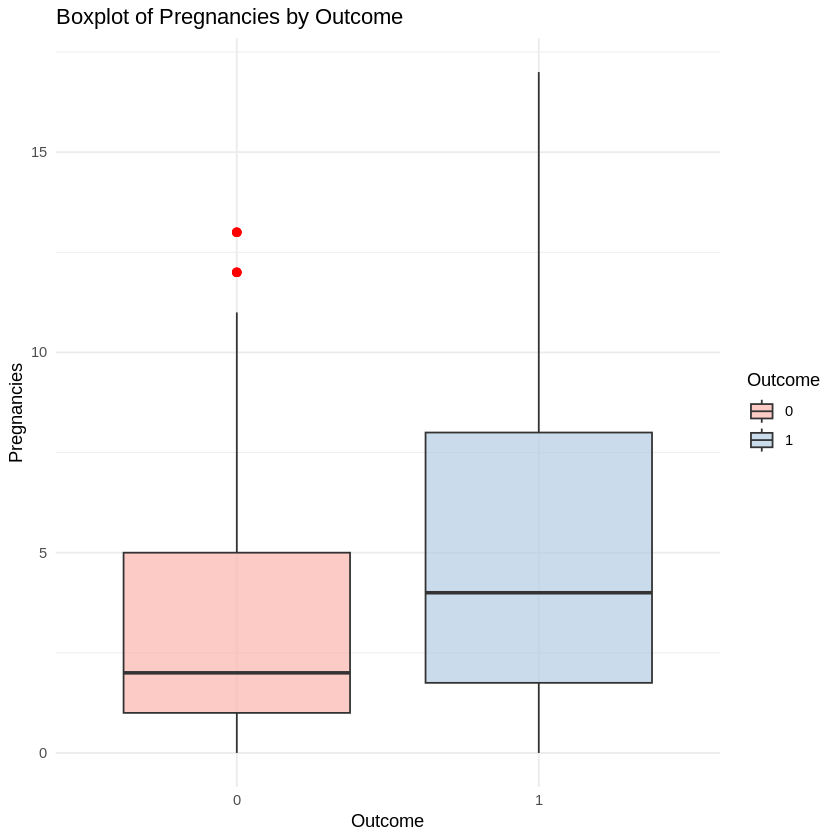


Analyzing Feature: BloodPressure 
Wilcoxon Test Results:

	Wilcoxon rank sum test with continuity correction

data:  data[[feature]] by data$Outcome
W = 55414, p-value = 7.559e-05
alternative hypothesis: true location shift is not equal to 0

The feature BloodPressure significantly differs between Outcome classes (p-value = 1e-04 ).


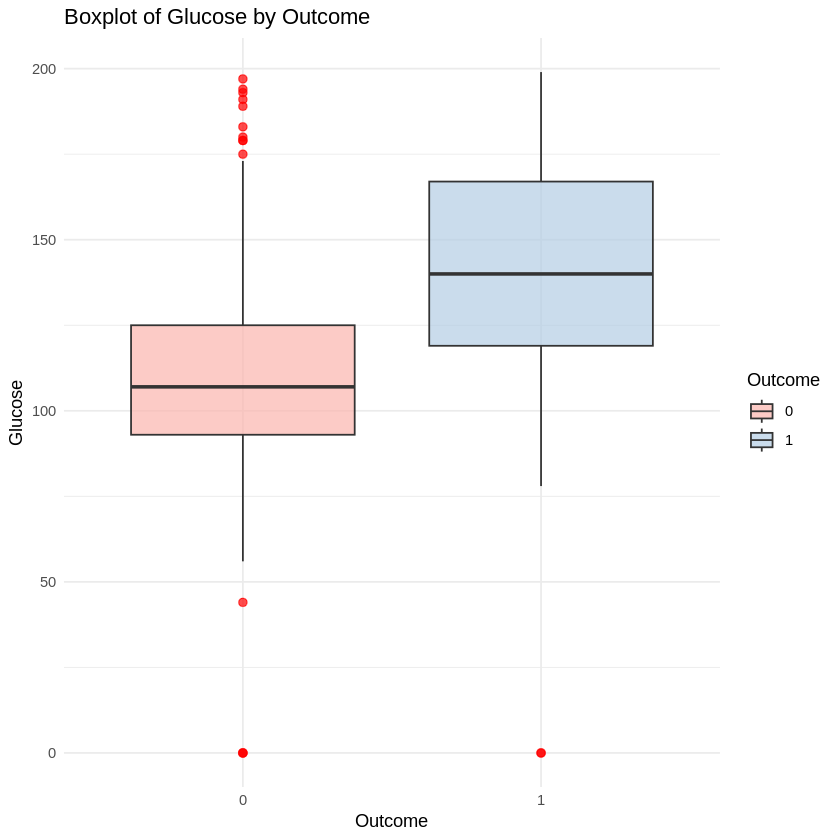


Analyzing Feature: SkinThickness 
Wilcoxon Test Results:

	Wilcoxon rank sum test with continuity correction

data:  data[[feature]] by data$Outcome
W = 59814, p-value = 0.01296
alternative hypothesis: true location shift is not equal to 0

The feature SkinThickness significantly differs between Outcome classes (p-value = 0.013 ).


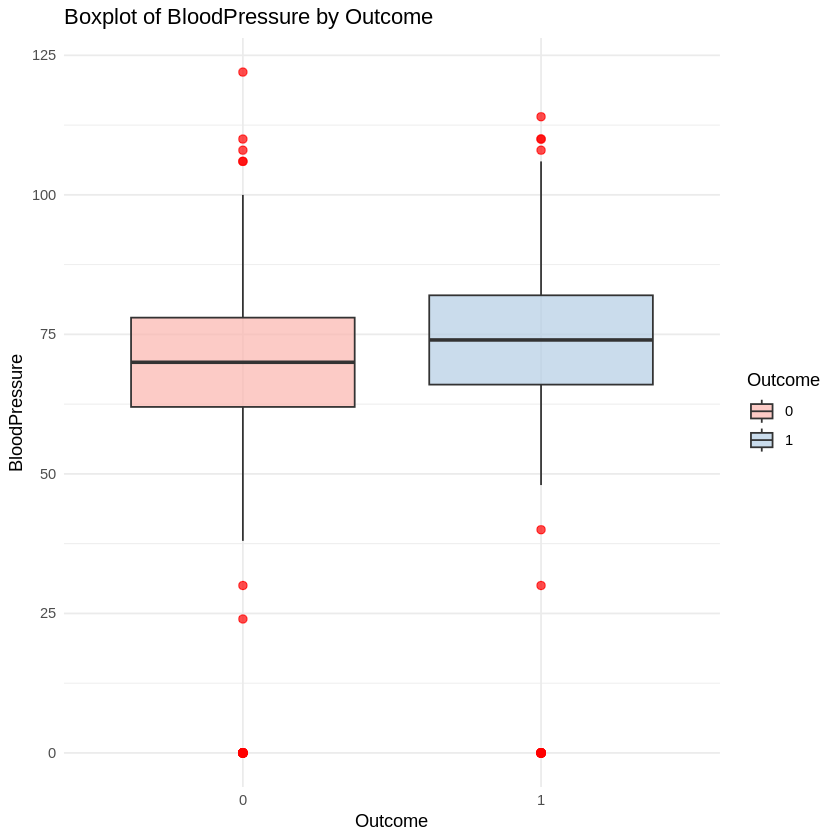


Analyzing Feature: Insulin 
Wilcoxon Test Results:

	Wilcoxon rank sum test with continuity correction

data:  data[[feature]] by data$Outcome
W = 61926, p-value = 0.06566
alternative hypothesis: true location shift is not equal to 0

The feature Insulin does not significantly differ between Outcome classes (p-value = 0.0657 ).


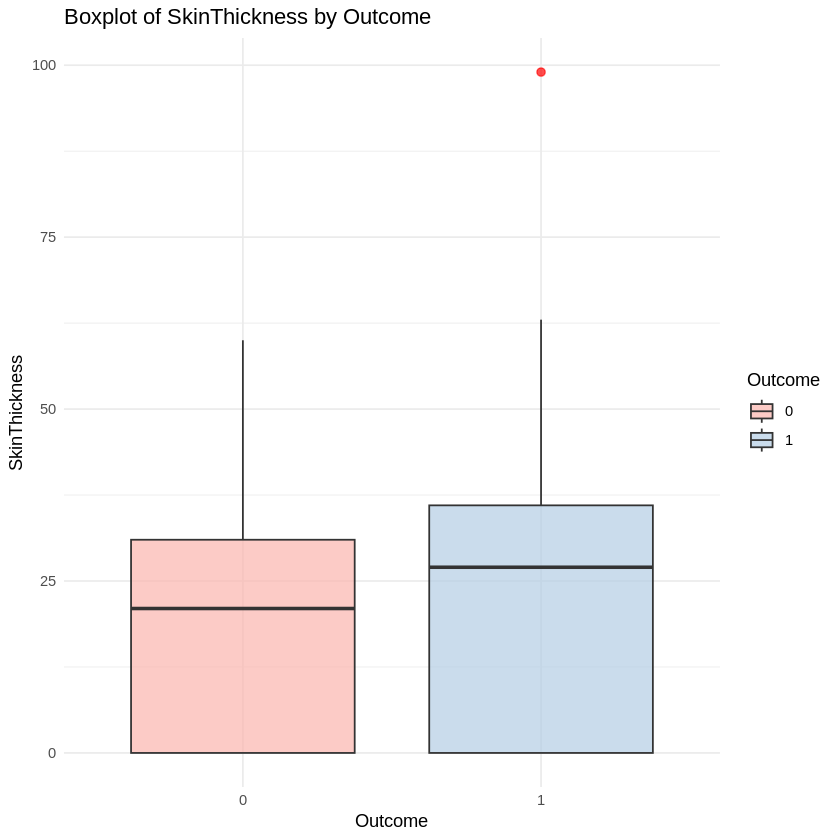


Analyzing Feature: BMI 
Wilcoxon Test Results:

	Wilcoxon rank sum test with continuity correction

data:  data[[feature]] by data$Outcome
W = 41866, p-value < 2.2e-16
alternative hypothesis: true location shift is not equal to 0

The feature BMI significantly differs between Outcome classes (p-value = 0 ).


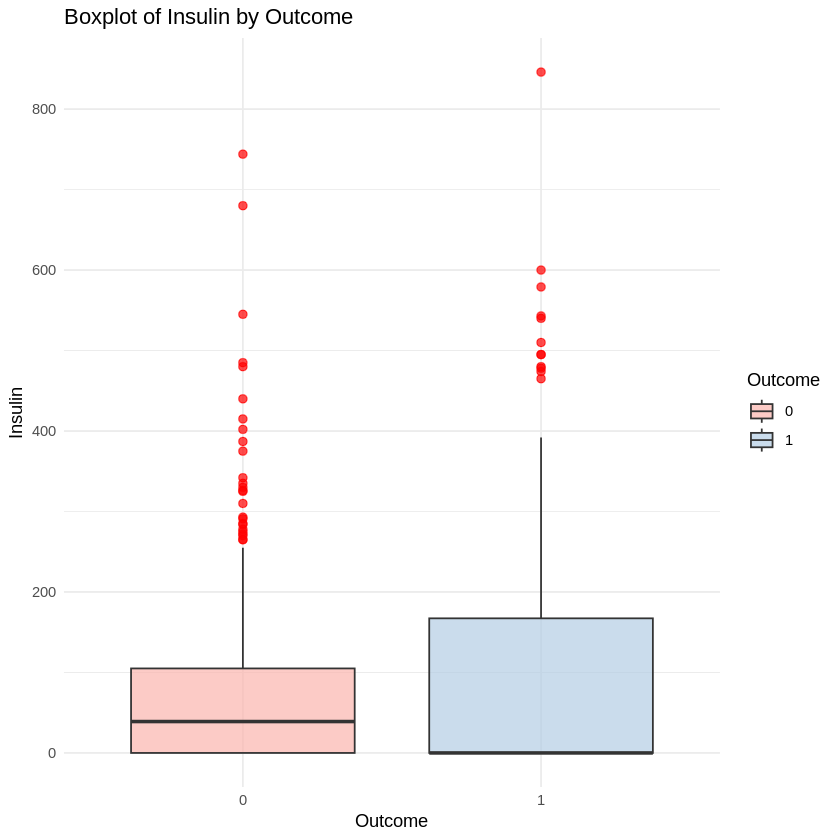


Analyzing Feature: DiabetesPedigreeFunction 
Wilcoxon Test Results:

	Wilcoxon rank sum test with continuity correction

data:  data[[feature]] by data$Outcome
W = 52769, p-value = 1.197e-06
alternative hypothesis: true location shift is not equal to 0

The feature DiabetesPedigreeFunction significantly differs between Outcome classes (p-value = 0 ).


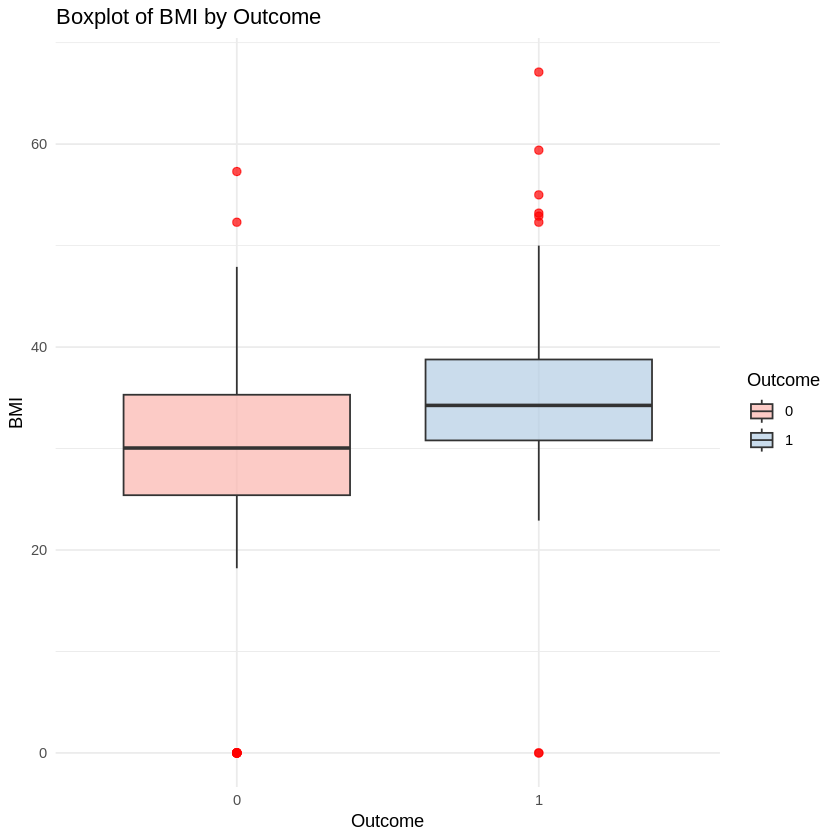


Analyzing Feature: Age 
Wilcoxon Test Results:

	Wilcoxon rank sum test with continuity correction

data:  data[[feature]] by data$Outcome
W = 41950, p-value < 2.2e-16
alternative hypothesis: true location shift is not equal to 0

The feature Age significantly differs between Outcome classes (p-value = 0 ).


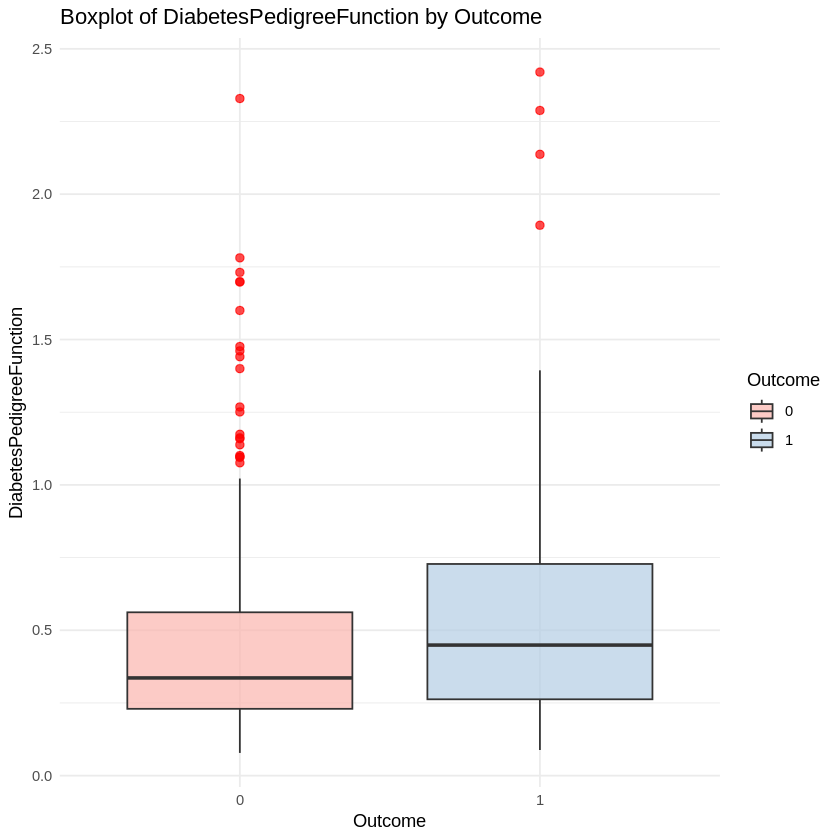

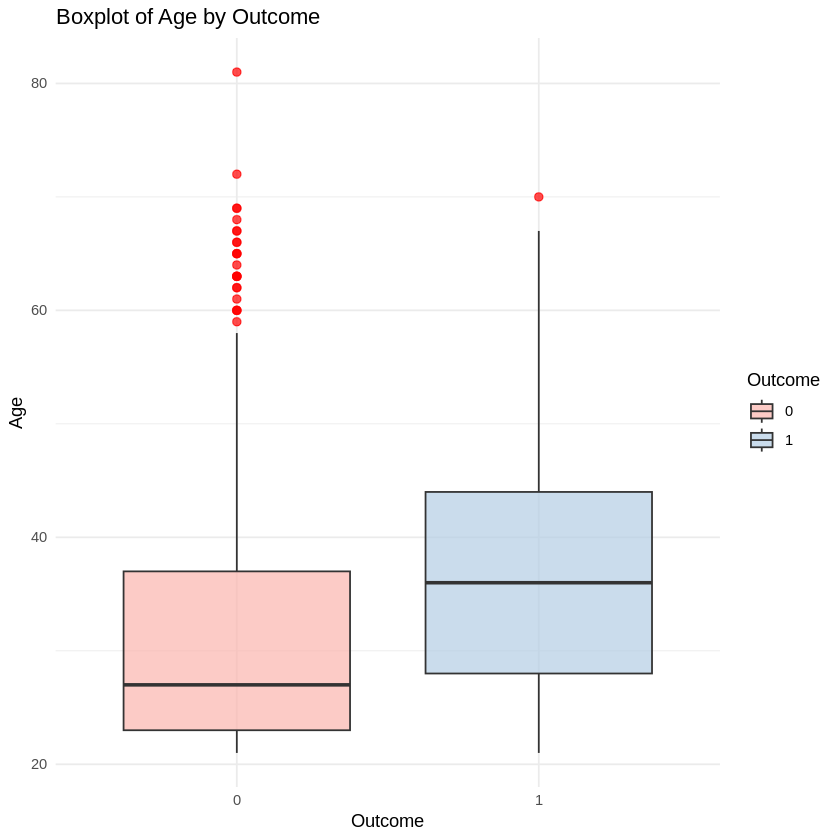

In [ ]:
data$Outcome <- as.factor(data$Outcome)

analyze_feature_with_boxplot <- function(feature) {
  cat("\nAnalyzing Feature:", feature, "\n")

  wilcox_result <- wilcox.test(data[[feature]] ~ data$Outcome)
  cat("Wilcoxon Test Results:\n")
  print(wilcox_result)

  p_value <- wilcox_result$p.value
  if (p_value < 0.05) {
    cat("The feature", feature, "significantly differs between Outcome classes (p-value =", round(p_value, 4), ").\n")
  } else {
    cat("The feature", feature, "does not significantly differ between Outcome classes (p-value =", round(p_value, 4), ").\n")
  }

  boxplot <- ggplot(data, aes_string(x = "Outcome", y = feature, fill = "Outcome")) +
    geom_boxplot(alpha = 0.7, outlier.color = "red", outlier.size = 2) +
    labs(
      title = paste("Boxplot of", feature, "by Outcome"),
      x = "Outcome",
      y = feature
    ) +
    theme_minimal() +
    scale_fill_brewer(palette = "Pastel1")

  print(boxplot)
}

features <- c("Pregnancies", "Glucose", "BloodPressure", "SkinThickness",
              "Insulin", "BMI", "DiabetesPedigreeFunction", "Age")

for (feature in features) {
  analyze_feature_with_boxplot(feature)
}


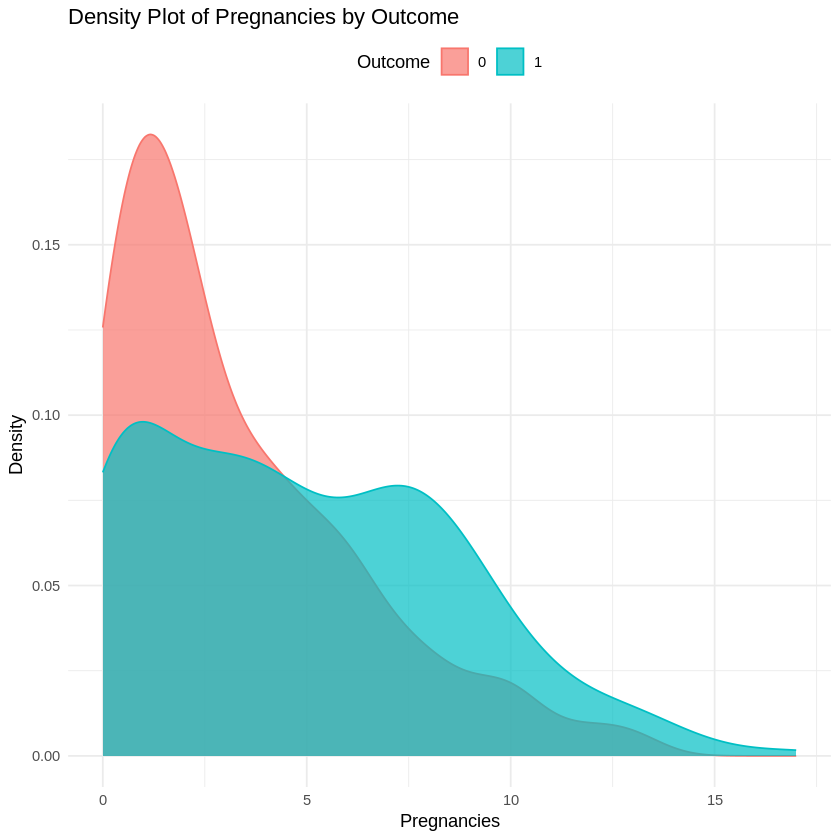

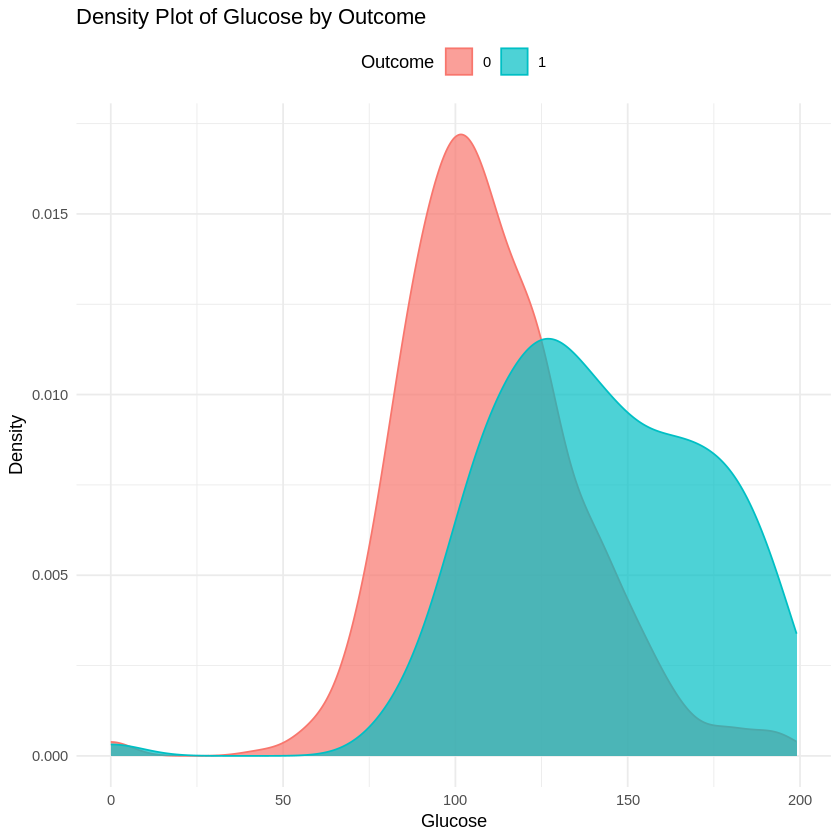

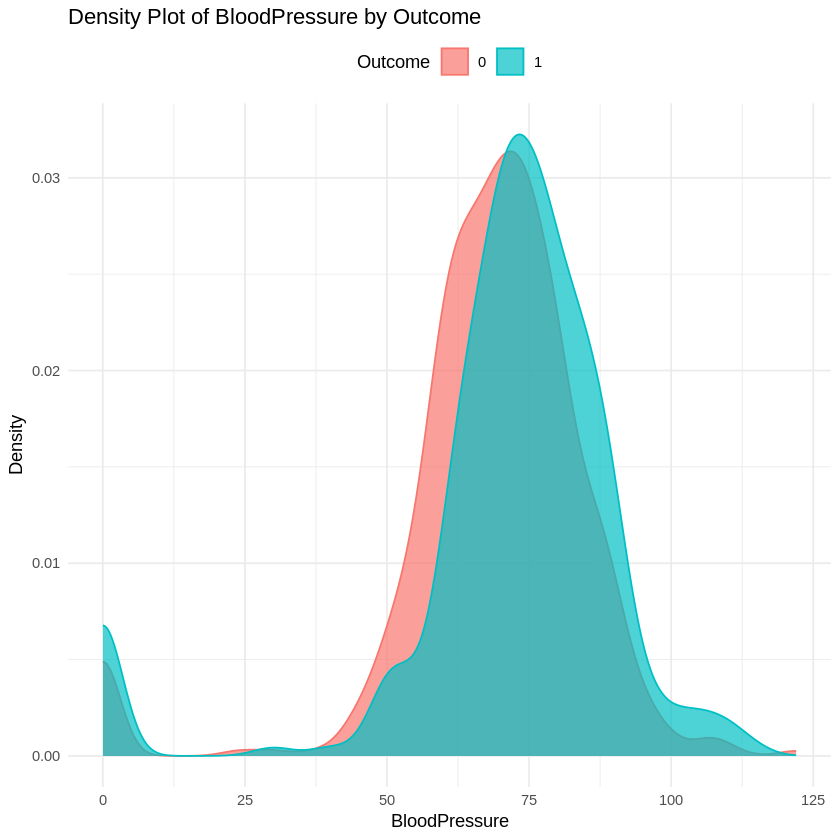

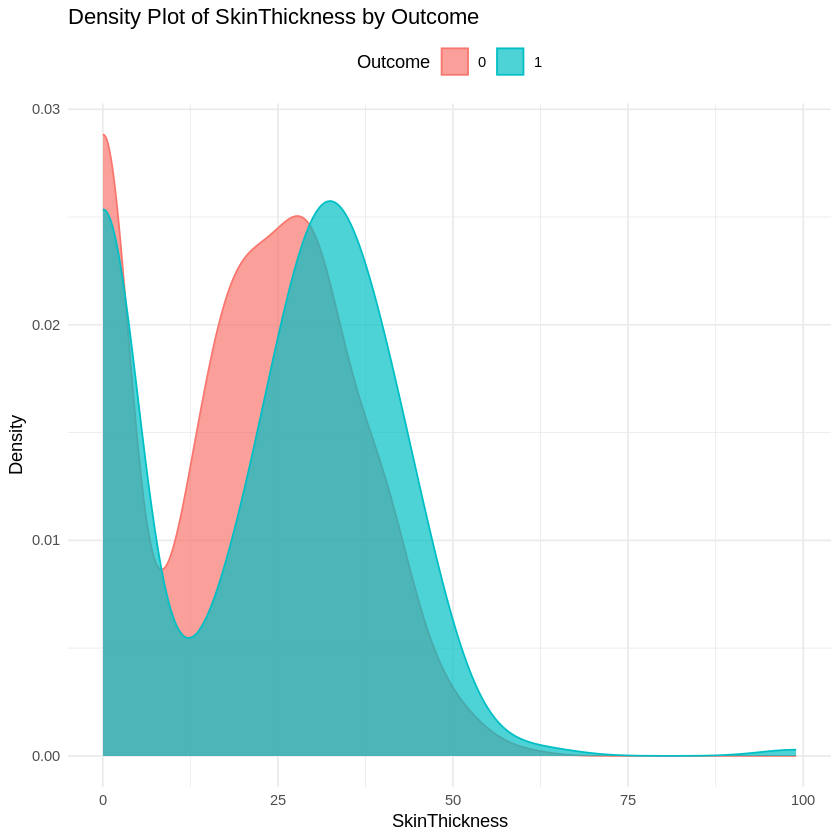

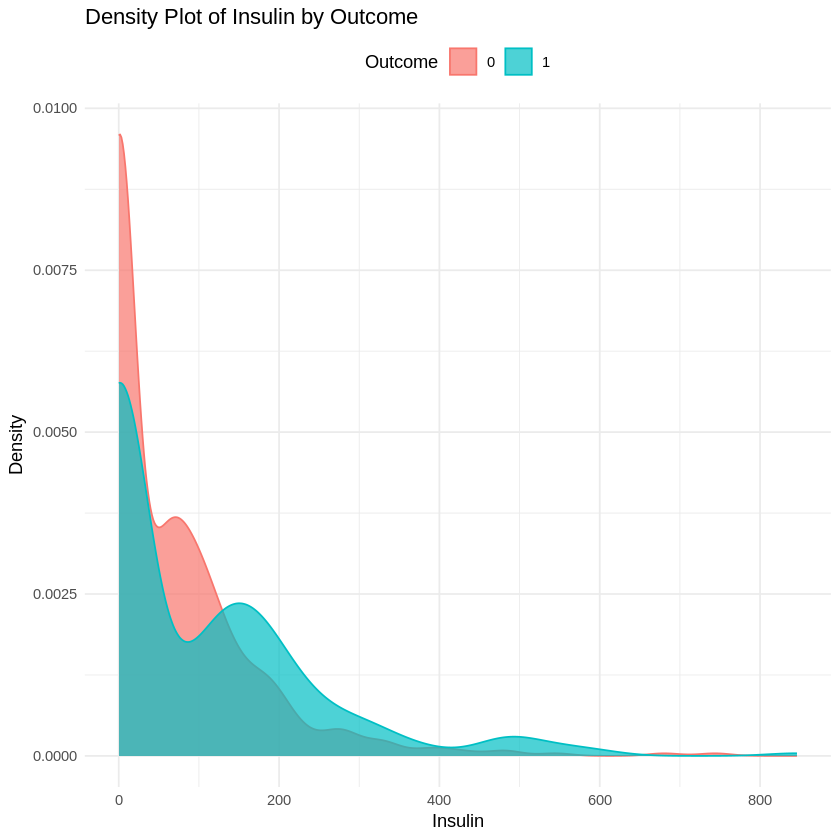

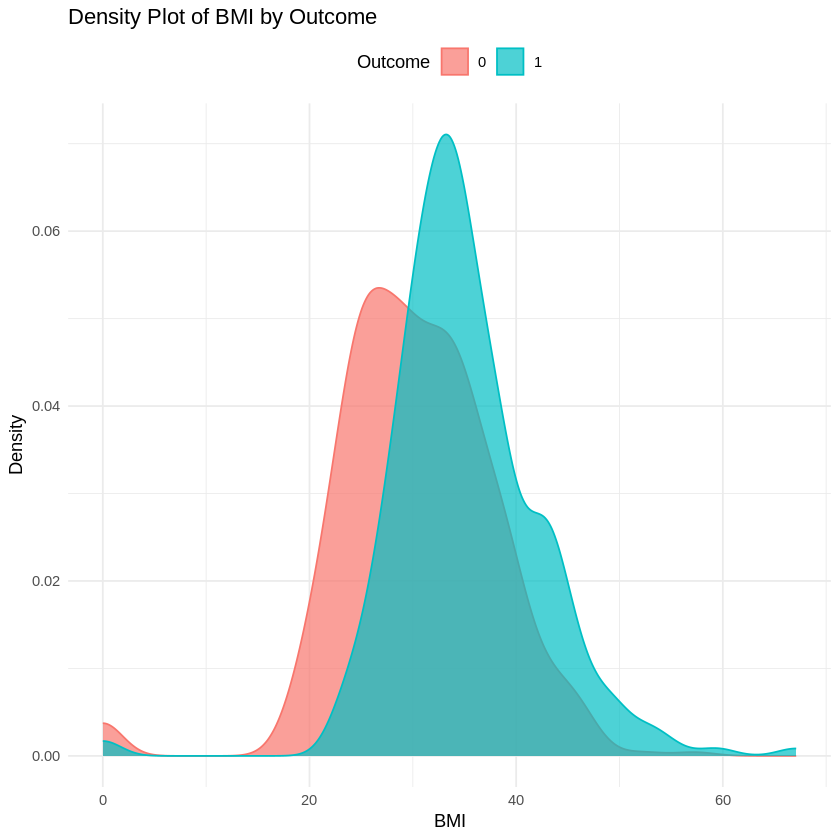

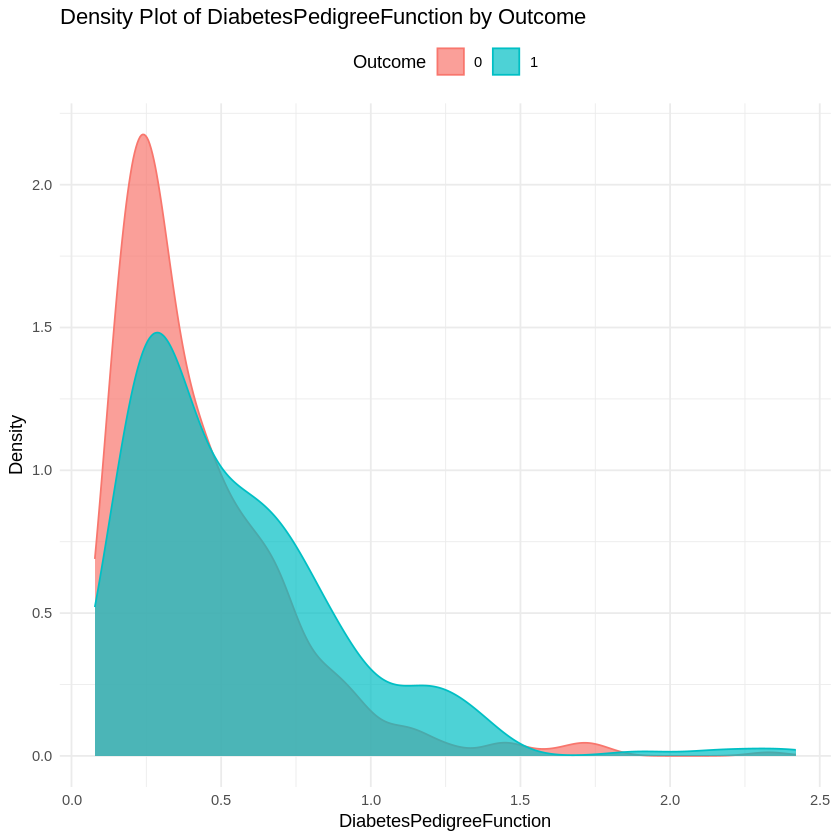

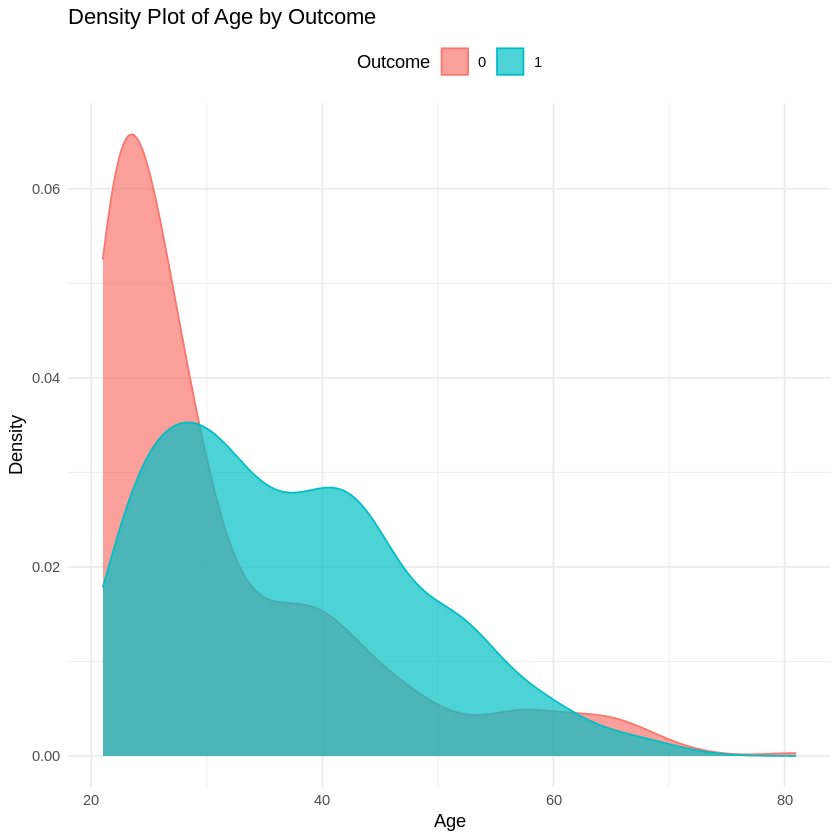

In [ ]:
data$Outcome <- as.factor(data$Outcome)

analyze_feature2 <- function(feature) {
  cat("\n")

  # density plot
  density_plot <- ggplot(data, aes_string(x = feature, fill = "Outcome", color = "Outcome")) +
    geom_density(alpha = 0.7) +
    labs(title = paste("Density Plot of", feature, "by Outcome"),
         x = feature, y = "Density") +
    theme_minimal() +
    theme(legend.position = "top")
  print(density_plot)

}

for (feature in features) {
  analyze_feature2(feature)
}


#  Predictive section



## Random Forest Model



### Training and testing the Random Forest model on the dataset (trained once)


In [ ]:
data$Outcome <- as.factor(data$Outcome)

set.seed(123)

train_index <- createDataPartition(data$Outcome, p = 0.5, list = FALSE)
train_data <- data[train_index, ]
test_data <- data[-train_index, ]

rf_model <- randomForest(Outcome ~ ., data = train_data, ntree = 1000, mtry = 5, importance = TRUE)

In [ ]:
test_predictions <- predict(rf_model, newdata = test_data)
confusion_matrix <- table(Predicted = test_predictions, Actual = test_data$Outcome)


accuracy <- mean(test_predictions == test_data$Outcome)
cat("Accuracy:", accuracy, "\n")

sensitivity <- confusionMatrix(confusion_matrix)$byClass["Sensitivity"]
cat("Sensitivity (True Positive Rate):", sensitivity, "\n")

specificity <- confusionMatrix(confusion_matrix)$byClass["Specificity"]
cat("Specificity (True Negative Rate):", specificity, "\n")

f1_score <- F1_Score(y_true = test_data$Outcome,
                     y_pred = test_predictions,
                     positive = levels(test_data$Outcome)[2]) # Specify the positive class
cat("F1-Score for the positive class:", f1_score, "\n")

Accuracy: 0.78125 
Sensitivity (True Positive Rate): 0.888 
Specificity (True Negative Rate): 0.5820896 
F1-Score for the positive class: 0.65 


In [ ]:
conf_matrix <- confusionMatrix(test_predictions, test_data$Outcome)
print(conf_matrix)

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 222  56
         1  28  78
                                          
               Accuracy : 0.7812          
                 95% CI : (0.7365, 0.8216)
    No Information Rate : 0.651           
    P-Value [Acc > NIR] : 1.937e-08       
                                          
                  Kappa : 0.494           
                                          
 Mcnemar's Test P-Value : 0.00322         
                                          
            Sensitivity : 0.8880          
            Specificity : 0.5821          
         Pos Pred Value : 0.7986          
         Neg Pred Value : 0.7358          
             Prevalence : 0.6510          
         Detection Rate : 0.5781          
   Detection Prevalence : 0.7240          
      Balanced Accuracy : 0.7350          
                                          
       'Positive' Class : 0               
                              

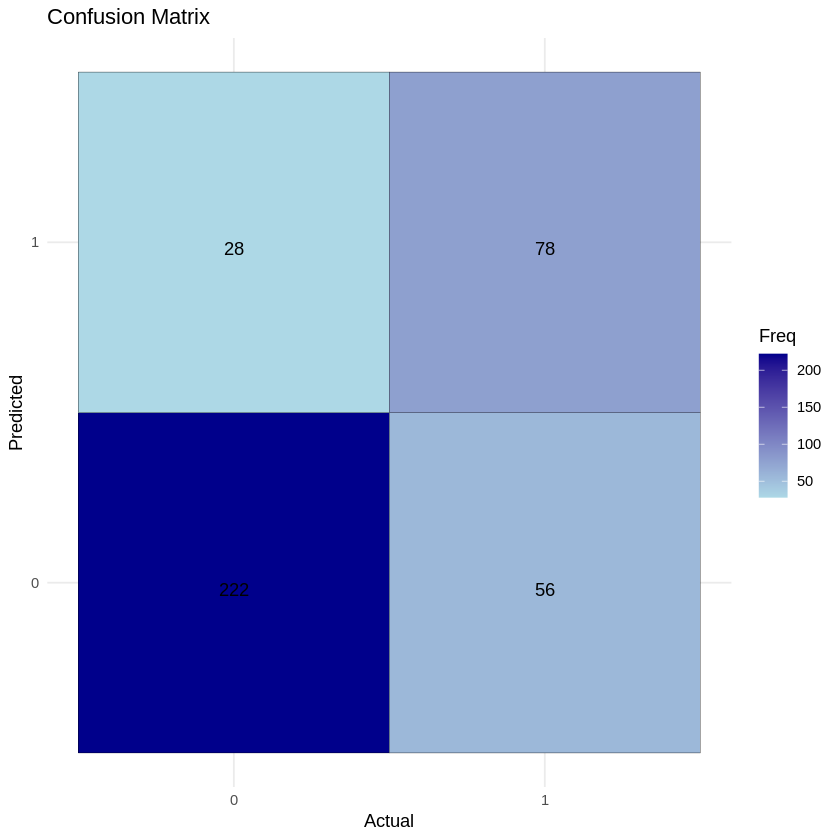

In [ ]:
ggplot(as.data.frame(conf_matrix$table), aes(x = Reference, y = Prediction)) +
  geom_tile(aes(fill = Freq), color = "black") +
  scale_fill_gradient(low = "lightblue", high = "darkblue") +
  geom_text(aes(label = Freq), vjust = 1) +
  labs(title = "Confusion Matrix", x = "Actual", y = "Predicted") +
  theme_minimal()


####  ROC curve


Setting levels: control = 0, case = 1

Setting direction: controls < cases



Area Under the Curve (AUC): 0.8428507 


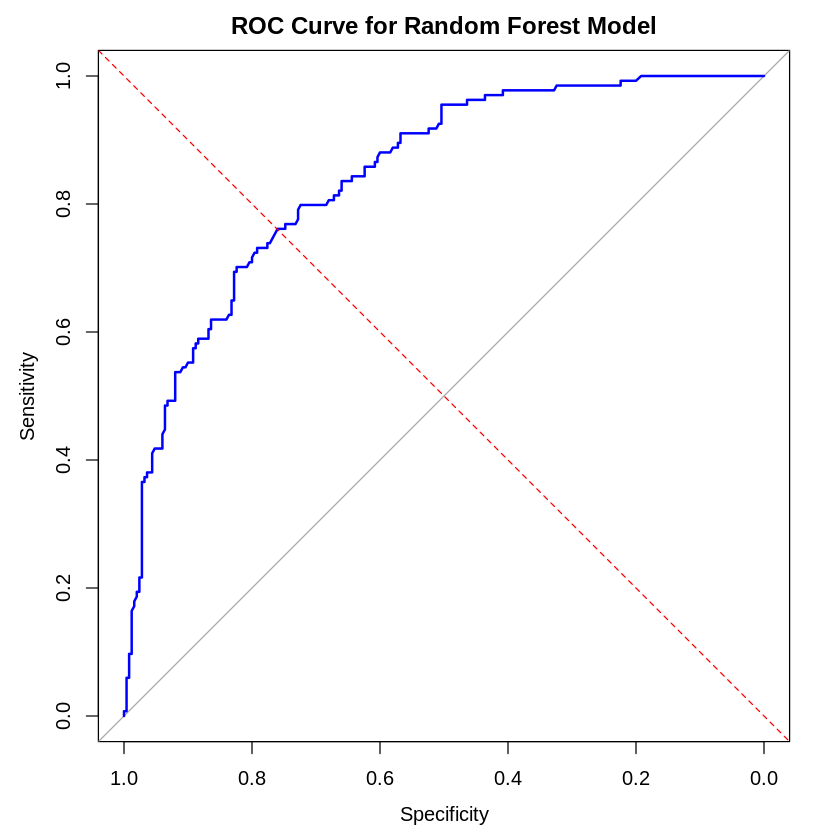

In [ ]:
# Predict probabilities for the positive class (Outcome = 1)
probabilities <- predict(rf_model, newdata = test_data, type = "prob")[, 2]

roc_curve <- roc(test_data$Outcome, probabilities)

plot(roc_curve, main = "ROC Curve for Random Forest Model", col = "blue", lwd = 2)
abline(a = 0, b = 1, col = "red", lty = 2)

auc_value <- auc(roc_curve)
cat("Area Under the Curve (AUC):", auc_value, "\n")


#### Finding the most important features and retraining the model using the selected features based on their importance


In [ ]:
importance_scores <- importance(rf_model)
print(importance_scores)

                                 0         1 MeanDecreaseAccuracy
Pregnancies              13.320688 -7.081518            7.8425080
Glucose                  40.862830 27.024667           45.5724792
BloodPressure             6.537915 -6.887863            0.5195169
SkinThickness             3.210264  2.510759            4.2818399
Insulin                   4.077149 -5.102433           -0.1906100
BMI                       9.220423 10.065969           13.8586382
DiabetesPedigreeFunction  7.754739  5.988105            9.6766281
Age                      21.366301  8.607842           22.9159879
                         MeanDecreaseGini
Pregnancies                      11.37665
Glucose                          48.39452
BloodPressure                    15.25347
SkinThickness                    11.31886
Insulin                          11.05962
BMI                              25.85971
DiabetesPedigreeFunction         26.32570
Age                              24.39798


In [ ]:
set.seed(12)

top_features <- names(sort(importance_scores[, 1], decreasing = TRUE))

for (num_features in 3:8) {
  selected_features <- top_features[1:num_features]

  train_data_subset <- train_data[, c(selected_features, "Outcome")]
  test_data_subset <- test_data[, c(selected_features, "Outcome")]

  rf_model_subset <- randomForest(Outcome ~ ., data = train_data_subset, ntree = 100, mtry = 5, importance = TRUE)

  # Predict on the test set
  predictions <- predict(rf_model_subset, newdata = test_data_subset)
  accuracy <- mean(predictions == test_data_subset$Outcome)

  print(paste("Features:", num_features, "- Accuracy:", round(accuracy*100, 2)))
}

Warning message in randomForest.default(m, y, ...):
“invalid mtry: reset to within valid range”


[1] "Features: 3 - Accuracy: 73.18"


Warning message in randomForest.default(m, y, ...):
“invalid mtry: reset to within valid range”


[1] "Features: 4 - Accuracy: 77.86"
[1] "Features: 5 - Accuracy: 76.82"
[1] "Features: 6 - Accuracy: 77.86"
[1] "Features: 7 - Accuracy: 78.65"
[1] "Features: 8 - Accuracy: 76.56"



#### Analyzing the impact of the Replace parameter


In [ ]:
set.seed(123)
# Train model with replace = TRUE
rf_model_replace_true <- randomForest(Outcome ~ ., data = train_data, ntree = 100, mtry = 5, replace = TRUE, importance = TRUE)
# Predict and calculate accuracy
predictions_replace_true <- predict(rf_model_replace_true, newdata = test_data)
accuracy_replace_true <- mean(predictions_replace_true == test_data$Outcome)


# Train model with replace = FALSE
rf_model_replace_false <- randomForest(Outcome ~ ., data = train_data, ntree = 100, mtry = 5, replace = FALSE, importance = TRUE)
# Predict and calculate accuracy
predictions_replace_false <- predict(rf_model_replace_false, newdata = test_data)
accuracy_replace_false <- mean(predictions_replace_false == test_data$Outcome)

# Print accuracy for comparison
print(paste("Accuracy with replace = TRUE:", round(accuracy_replace_true*100, 2)))
print(paste("Accuracy with replace = FALSE:", round(accuracy_replace_false*100, 2)))

[1] "Accuracy with replace = TRUE: 78.91"
[1] "Accuracy with replace = FALSE: 78.12"



#### Analyzing the impact of the Replace parameter


In [ ]:
set.seed(120)

ntree_values <- c(100, 1000, 1000, 10000)   # Number of trees
mtry_values <- c(2, 3, 5, 7)                # Number of features to consider at each split
maxnodes_values <- c(5, 10, 20, 30)         # Maximum number of terminal nodes

results <- data.frame(ntree = integer(),
                      mtry = integer(),
                      maxnodes = integer(),
                      accuracy = numeric())

for (ntree in ntree_values) {
  for (mtry in mtry_values) {
    for (maxnodes in maxnodes_values) {

      rf_model <- randomForest(Outcome ~ ., data = train_data,
                               ntree = ntree, mtry = mtry, maxnodes = maxnodes, importance = TRUE, replace = TRUE)

      predictions <- predict(rf_model, newdata = test_data)
      accuracy <- mean(predictions == test_data$Outcome)
      results <- rbind(results, data.frame(ntree = ntree, mtry = mtry, maxnodes = maxnodes, accuracy = accuracy))
    }
  }
}

results <- results[order(-results$accuracy), ]
print("Top-performing hyperparameter combinations:")
print(results)

[1] "Top-performing hyperparameter combinations:"
   ntree mtry maxnodes  accuracy
7    100    3       20 0.7890625
19  1000    2       20 0.7890625
52 10000    2       30 0.7838542
59 10000    5       20 0.7838542
26  1000    5       10 0.7812500
28  1000    5       30 0.7812500
32  1000    7       30 0.7812500
34  1000    2       10 0.7812500
43  1000    5       20 0.7812500
63 10000    7       20 0.7812500
3    100    2       20 0.7786458
10   100    5       10 0.7786458
18  1000    2       10 0.7786458
23  1000    3       20 0.7786458
27  1000    5       20 0.7786458
31  1000    7       20 0.7786458
35  1000    2       20 0.7786458
40  1000    3       30 0.7786458
44  1000    5       30 0.7786458
47  1000    7       20 0.7786458
50 10000    2       10 0.7786458
51 10000    2       20 0.7786458
56 10000    3       30 0.7786458
60 10000    5       30 0.7786458
64 10000    7       30 0.7786458
6    100    3       10 0.7760417
8    100    3       30 0.7760417
15   100    7       20 0.7


### Training and testing the Random Forest model on the dataset (trained 1000 times)


In [ ]:
data$Outcome <- as.factor(data$Outcome)
n = 1000

results <- data.frame(
  Iteration = integer(n),
  Accuracy = numeric(n),
  Sensitivity = numeric(n),
  Specificity = numeric(n),
  F1_Score = numeric(n)
)
important_features_list <- list()

set.seed(123)
for (i in 1:n) {
  train_index <- createDataPartition(data$Outcome, p = 0.5, list = FALSE)
  train_data <- data[train_index, ]
  test_data <- data[-train_index, ]

  rf_model <- randomForest(Outcome ~ ., data = train_data, ntree = 1000, mtry = 5, importance = TRUE)
  test_predictions <- predict(rf_model, newdata = test_data)
  confusion_matrix <- confusionMatrix(test_predictions, test_data$Outcome)

  # Store performance metrics
  results[i, "Iteration"] <- i
  results[i, "Accuracy"] <- mean(test_predictions == test_data$Outcome)
  results[i, "Sensitivity"] <- confusion_matrix$byClass["Sensitivity"]
  results[i, "Specificity"] <- confusion_matrix$byClass["Specificity"]
  results[i, "F1_Score"] <- F1_Score(
    y_true = test_data$Outcome,
    y_pred = test_predictions,
    positive = levels(test_data$Outcome)[2]
  )

  # Identify and store the 5 most important features
  importance_scores <- importance(rf_model)[, "MeanDecreaseGini"]
  important_features <- names(sort(importance_scores, decreasing = TRUE)[1:5])
  important_features_list[[i]] <- important_features
}

No id variables; using all as measure variables



Top Features Frequency Across Iterations:
                   Feature Count
1                      Age  1000
2                      BMI  1000
3 DiabetesPedigreeFunction  1000
4                  Glucose  1000
5            BloodPressure   741
6              Pregnancies   248
7                  Insulin    11


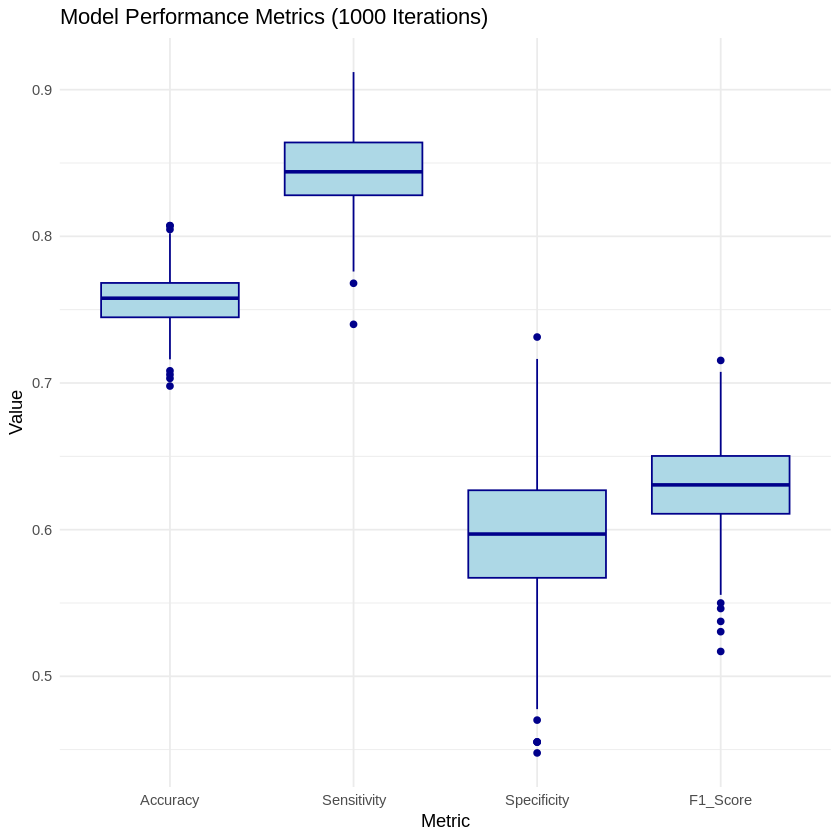

In [ ]:
results_long <- reshape2::melt(results[, -1], variable.name = "Metric", value.name = "Value")

ggplot(results_long, aes(x = Metric, y = Value)) +
  geom_boxplot(fill = "lightblue", color = "darkblue") +
  theme_minimal() +
  labs(title = "Model Performance Metrics (1000 Iterations)",
       x = "Metric", y = "Value")

important_features_summary <- data.frame(
  Features = unlist(important_features_list)
)
top_features_count <- table(important_features_summary$Features)
top_features_summary <- as.data.frame(sort(top_features_count, decreasing = TRUE))
colnames(top_features_summary) <- c("Feature", "Count")

cat("Top Features Frequency Across Iterations:\n")
print(top_features_summary)

No id variables; using all as measure variables



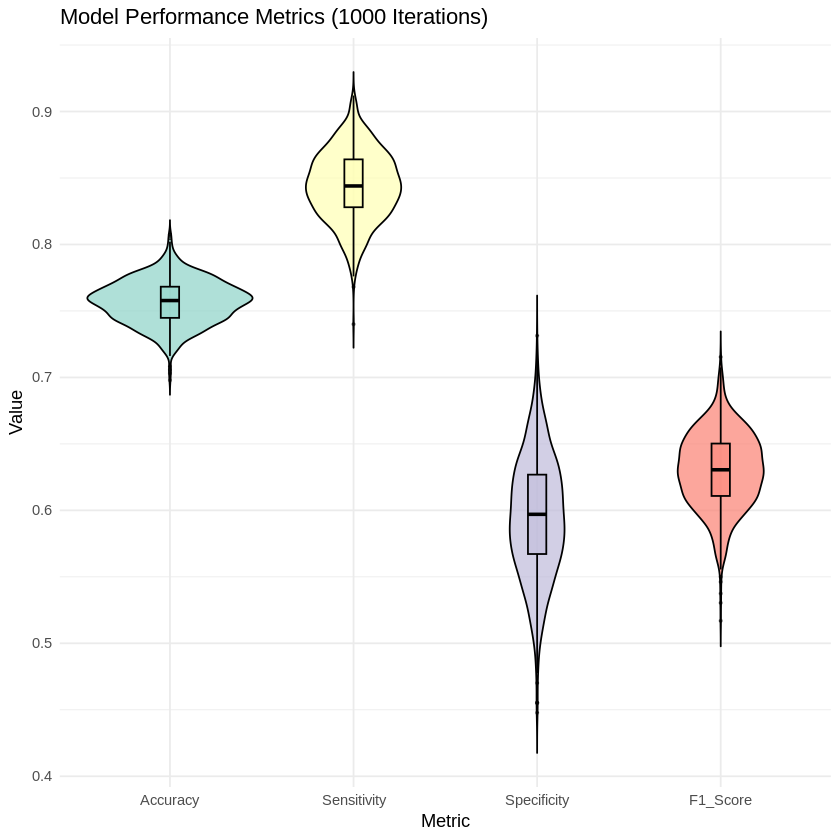

In [ ]:
# Reshape the results data for plotting
results_long <- melt(results[, -1], variable.name = "Metric", value.name = "Value")

ggplot(results_long, aes(x = Metric, y = Value, fill = Metric)) +
  geom_violin(trim = FALSE, color = "black", alpha = 0.7) +
  geom_boxplot(width = 0.1, outlier.size = 0.5, color = "black", alpha = 0.5) +
  theme_minimal() +
  scale_fill_brewer(palette = "Set3") +
  labs(title = "Model Performance Metrics (1000 Iterations)",
       x = "Metric", y = "Value") +
  theme(legend.position = "none")


### Adjusting the test-to-train data ratio


In [ ]:
data$Outcome <- as.factor(data$Outcome)

results <- data.frame(
  SplitRate = numeric(),
  Accuracy = numeric(),
  Sensitivity = numeric(),
  Specificity = numeric(),
  F1_Score = numeric()
)

set.seed(123)
split_rates <- seq(0.05, 0.95, by = 0.05)

for (p in split_rates) {
  train_index <- createDataPartition(data$Outcome, p = p, list = FALSE)
  train_data <- data[train_index, ]
  test_data <- data[-train_index, ]

  rf_model <- randomForest(Outcome ~ ., data = train_data, ntree = 1000, mtry = 5, importance = TRUE)

  test_predictions <- predict(rf_model, newdata = test_data)
  confusion_matrix <- confusionMatrix(test_predictions, test_data$Outcome)

  # Calculate metrics
  accuracy <- mean(test_predictions == test_data$Outcome)
  sensitivity <- confusion_matrix$byClass["Sensitivity"]
  specificity <- confusion_matrix$byClass["Specificity"]
  f1_score <- F1_Score(
    y_true = test_data$Outcome,
    y_pred = test_predictions,
    positive = levels(test_data$Outcome)[2]
  )

  results <- rbind(results, data.frame(SplitRate = p, Accuracy = accuracy,
                                       Sensitivity = sensitivity,
                                       Specificity = specificity,
                                       F1_Score = f1_score))
}

results_long <- reshape2::melt(results, id.vars = "SplitRate", variable.name = "Metric", value.name = "Value")



Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”
`geom_smooth()` using formula = 'y ~ x'


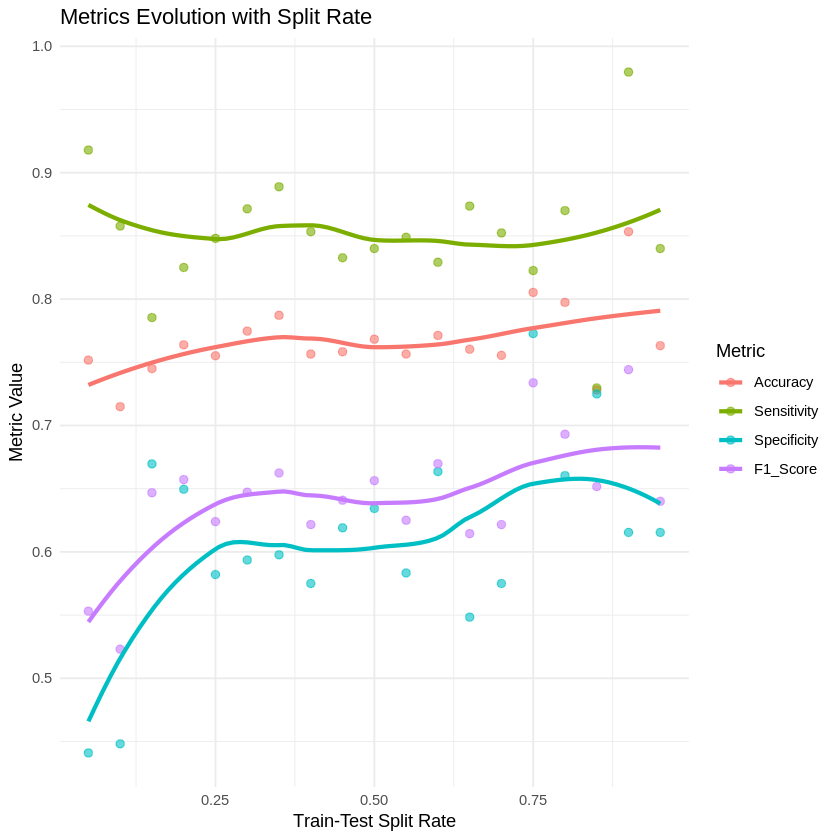

In [ ]:
ggplot(results_long, aes(x = SplitRate, y = Value, color = Metric)) +
  geom_point(size = 2, alpha = 0.6) +
  geom_smooth(method = "loess", se = FALSE, size = 1.2) +
  theme_minimal() +
  labs(title = "Metrics Evolution with Split Rate",
       x = "Train-Test Split Rate",
       y = "Metric Value",
       color = "Metric")



## LDA Model



### Training and testing the LDA model on the dataset (trained once)


In [ ]:
data$Outcome <- as.factor(data$Outcome)

set.seed(123)

train_index <- createDataPartition(data$Outcome, p = 0.5, list = FALSE)
train_data <- data[train_index, ]
test_data <- data[-train_index, ]

In [ ]:
normality_test <- lapply(train_data[, -ncol(train_data)], shapiro.test)
normality_results <- sapply(normality_test, function(x) x$p.value)
normality_results

Pregnancies                  Glucose            BloodPressure 
            1.276851e-15             2.020343e-09             1.761973e-20 
           SkinThickness                  Insulin                      BMI 
            8.388521e-15             5.239028e-24             1.021186e-10 
DiabetesPedigreeFunction                      Age 
            3.039342e-19             9.387684e-18

In [ ]:
zscore_normalize <- function(df) {
  df_scaled <- as.data.frame(scale(df[, -ncol(df)])) # استانداردسازی ورودی‌ها
  df_scaled$Outcome <- df$Outcome # افزودن ستون هدف بدون تغییر
  return(df_scaled)
}

In [ ]:
train_data_scaled <- zscore_normalize(train_data)
test_data_scaled <- zscore_normalize(test_data)

lda_model <- lda(Outcome ~ ., data = train_data_scaled)
print(lda_model)

Call:
lda(Outcome ~ ., data = train_data_scaled)

Prior probabilities of groups:
        0         1 
0.6510417 0.3489583 

Group means:
  Pregnancies    Glucose BloodPressure SkinThickness    Insulin        BMI
0  -0.1310924 -0.3191364  -0.002067043    -0.1127262 -0.1323489 -0.1904746
1   0.2445753  0.5954038   0.003856423     0.2103101  0.2469196  0.3553630
  DiabetesPedigreeFunction        Age
0               -0.1857603 -0.1717816
1                0.3465678  0.3204880

Coefficients of linear discriminants:
                                 LD1
Pregnancies               0.23374023
Glucose                   0.76998761
BloodPressure            -0.34470771
SkinThickness             0.14973705
Insulin                  -0.04167552
BMI                       0.39183614
DiabetesPedigreeFunction  0.39824926
Age                       0.21188087


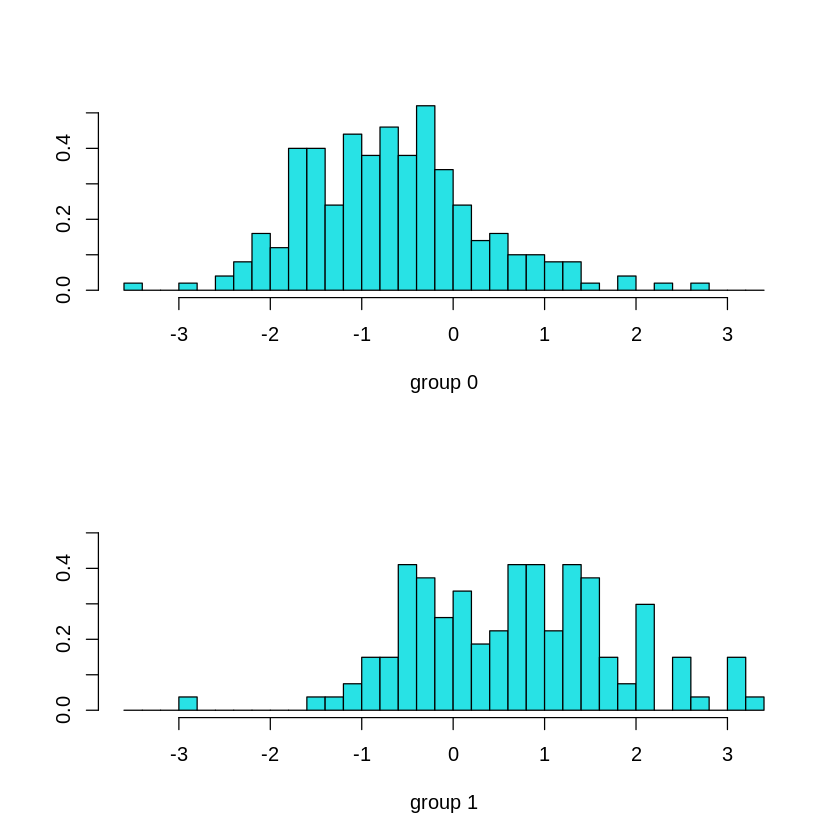

In [ ]:
plot(lda_model, main="Visualization of Linear Discriminant Analysis")

In [ ]:
lda_predictions <- predict(lda_model, newdata = test_data_scaled)
test_predictions <- lda_predictions$class

confusion_matrix <- table(Predicted = test_predictions, Actual = test_data_scaled$Outcome)

accuracy <- mean(test_predictions == test_data_scaled$Outcome)
cat("Accuracy:", accuracy, "\n")


sensitivity <- confusion_matrix_caret$byClass["Sensitivity"]
cat("Sensitivity (True Positive Rate):", sensitivity, "\n")

specificity <- confusion_matrix_caret$byClass["Specificity"]
cat("Specificity (True Negative Rate):", specificity, "\n")

f1_score <- F1_Score(y_true = test_data_scaled$Outcome,
                     y_pred = test_predictions,
                     positive = levels(test_data_scaled$Outcome)[2])
cat("F1-Score for the positive class:", f1_score, "\n")

Accuracy: 0.7604167 
Sensitivity (True Positive Rate): 0.884 
Specificity (True Negative Rate): 0.5298507 
F1-Score for the positive class: 0.6068376 


In [ ]:
confusion_matrix_caret <- confusionMatrix(test_predictions, test_data_scaled$Outcome)
print(confusion_matrix_caret)

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 221  63
         1  29  71
                                          
               Accuracy : 0.7604          
                 95% CI : (0.7145, 0.8023)
    No Information Rate : 0.651           
    P-Value [Acc > NIR] : 2.408e-06       
                                          
                  Kappa : 0.4397          
                                          
 Mcnemar's Test P-Value : 0.0005807       
                                          
            Sensitivity : 0.8840          
            Specificity : 0.5299          
         Pos Pred Value : 0.7782          
         Neg Pred Value : 0.7100          
             Prevalence : 0.6510          
         Detection Rate : 0.5755          
   Detection Prevalence : 0.7396          
      Balanced Accuracy : 0.7069          
                                          
       'Positive' Class : 0               
                              

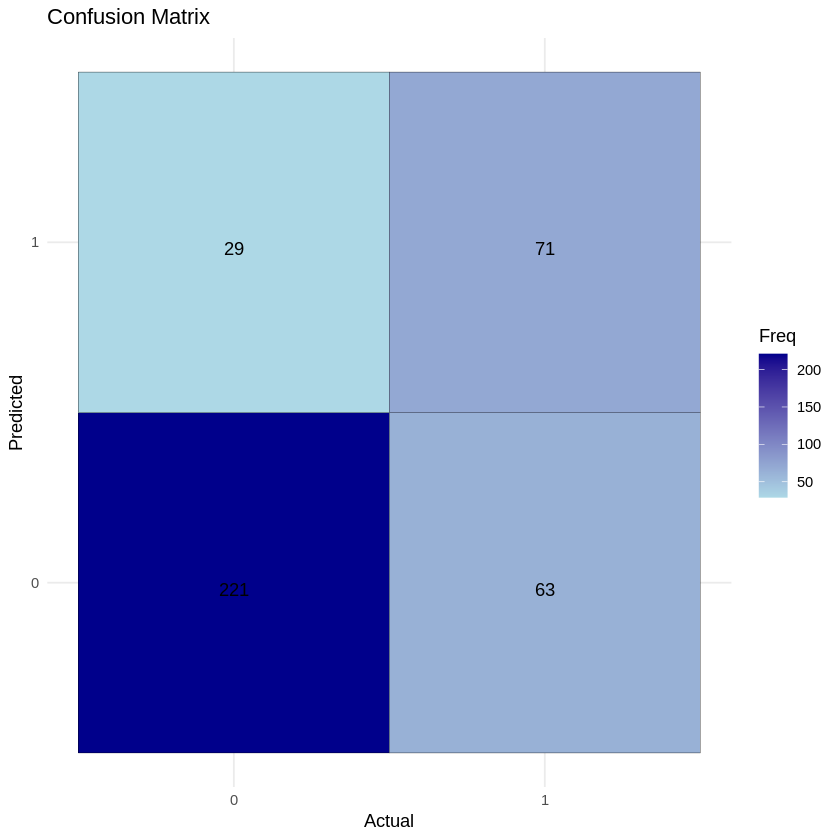

In [ ]:
ggplot(as.data.frame(confusion_matrix_caret$table), aes(x = Reference, y = Prediction)) +
  geom_tile(aes(fill = Freq), color = "black") +
  scale_fill_gradient(low = "lightblue", high = "darkblue") +
  geom_text(aes(label = Freq), vjust = 1) +
  labs(title = "Confusion Matrix", x = "Actual", y = "Predicted") +
  theme_minimal()

In [ ]:
install.packages("irr")

library(irr)
# Calculate Fleiss' kappa
kappam.fleiss(data.frame(test_predictions,  test_data_scaled$Outcome))

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘lpSolve’


Loading required package: lpSolve



 Fleiss' Kappa for m Raters

 Subjects = 384 
   Raters = 2 
    Kappa = 0.435 

        z = 8.52 
  p-value = 0 

<div dir="rtl" style="text-align: right; font-family: Tahoma;">

####نمودار ROC
</div>

Setting levels: control = 0, case = 1

Setting direction: controls < cases



Area Under the Curve (AUC): 0.8256418 


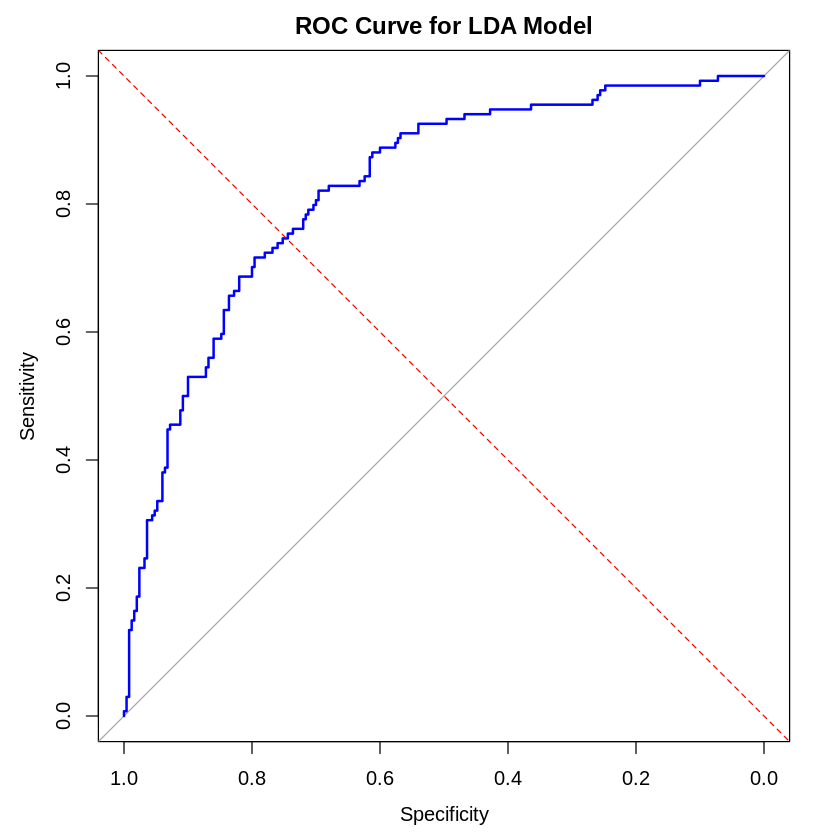

In [ ]:
probabilities <- lda_predictions$posterior[, 2]

roc_curve <- roc(test_data_scaled$Outcome, probabilities)

plot(roc_curve, main = "ROC Curve for LDA Model", col = "blue", lwd = 2)
abline(a = 0, b = 1, col = "red", lty = 2)

auc_value <- auc(roc_curve)
cat("Area Under the Curve (AUC):", auc_value, "\n")


#### Precision-Recall Curve


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



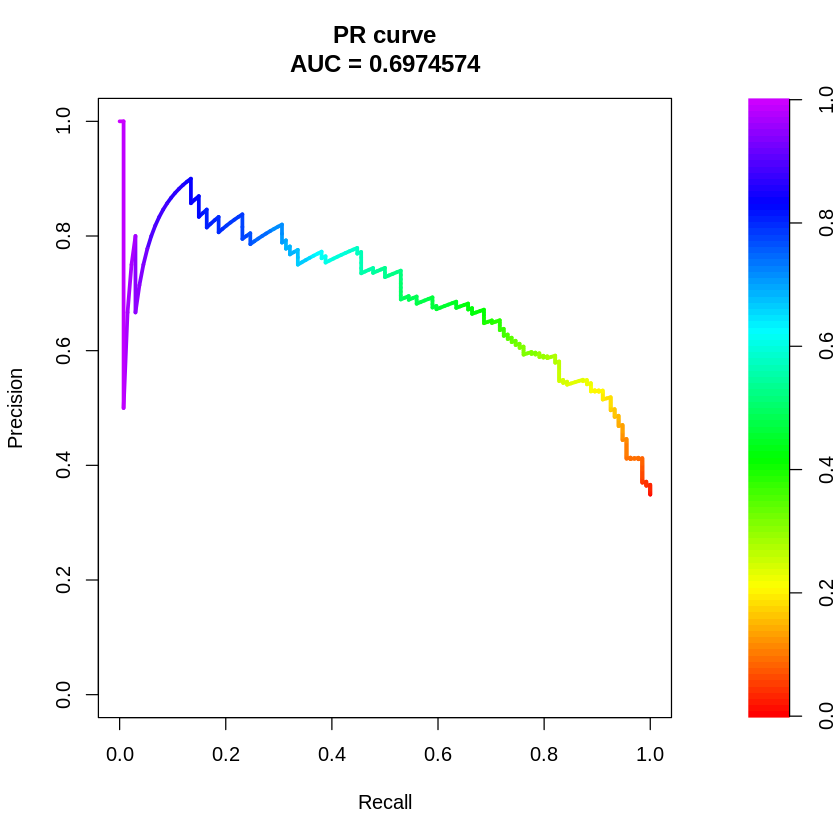

In [ ]:
data$Outcome <- as.factor(data$Outcome)

set.seed(123)
train_index <- createDataPartition(data$Outcome, p = 0.5, list = FALSE)
train_data <- data[train_index, ]
test_data <- data[-train_index, ]

train_data_scaled <- zscore_normalize(train_data)
test_data_scaled <- zscore_normalize(test_data)


lda_model <- lda(Outcome ~ ., data = train_data_scaled)
lda_predictions <- predict(lda_model, test_data_scaled)$class

lda_probabilities <- predict(lda_model, test_data_scaled)$posterior[,2]

pr <- pr.curve(scores.class0 = lda_probabilities, weights.class0 = test_data_scaled$Outcome == "1", curve = TRUE)

plot(pr)


### Training and testing the LDA model on the dataset (trained 1000 times)


In [ ]:
data$Outcome <- as.factor(data$Outcome)
n = 1000

results <- data.frame(
  Iteration = integer(n),
  Accuracy = numeric(n),
  Sensitivity = numeric(n),
  Specificity = numeric(n),
  F1_Score = numeric(n)
)

set.seed(123)

for (i in 1:n) {
  train_index <- createDataPartition(data$Outcome, p = 0.5, list = FALSE)
  train_data <- data[train_index, ]
  test_data <- data[-train_index, ]

  train_data_scaled <- zscore_normalize(train_data)
  test_data_scaled <- zscore_normalize(test_data)
  # Train LDA model
  lda_model <- lda(Outcome ~ ., data = train_data_scaled)

  # Predict with LDA model
  test_predictions <- predict(lda_model, newdata = test_data_scaled)$class
  confusion_matrix <- confusionMatrix(test_predictions, test_data_scaled$Outcome)

  # Store performance metrics
  results[i, "Iteration"] <- i
  results[i, "Accuracy"] <- mean(test_predictions == test_data_scaled$Outcome)
  results[i, "Sensitivity"] <- confusion_matrix$byClass["Sensitivity"]
  results[i, "Specificity"] <- confusion_matrix$byClass["Specificity"]
  results[i, "F1_Score"] <- F1_Score(
    y_true = test_data_scaled$Outcome,
    y_pred = test_predictions,
    positive = levels(test_data_scaled$Outcome)[2]
  )

  # Identify and store the 5 most important features (based on variance)
  feature_variance <- apply(train_data_scaled[, -ncol(train_data_scaled)], 2, var)
  important_features <- names(sort(feature_variance, decreasing = TRUE)[1:5])

}

# View summary of results
results_summary <- summary(results)

results_summary_cleaned <- results_summary[, -1]

print(results_summary_cleaned)


    Accuracy       Sensitivity      Specificity        F1_Score     
 Min.   :0.7188   Min.   :0.8200   Min.   :0.4851   Min.   :0.5508  
 1st Qu.:0.7578   1st Qu.:0.8680   1st Qu.:0.5448   1st Qu.:0.6109  
 Median :0.7682   Median :0.8760   Median :0.5597   Median :0.6276  
 Mean   :0.7674   Mean   :0.8778   Mean   :0.5615   Mean   :0.6276  
 3rd Qu.:0.7786   3rd Qu.:0.8920   3rd Qu.:0.5821   3rd Qu.:0.6444  
 Max.   :0.8281   Max.   :0.9400   Max.   :0.6418   Max.   :0.7155  


No id variables; using all as measure variables



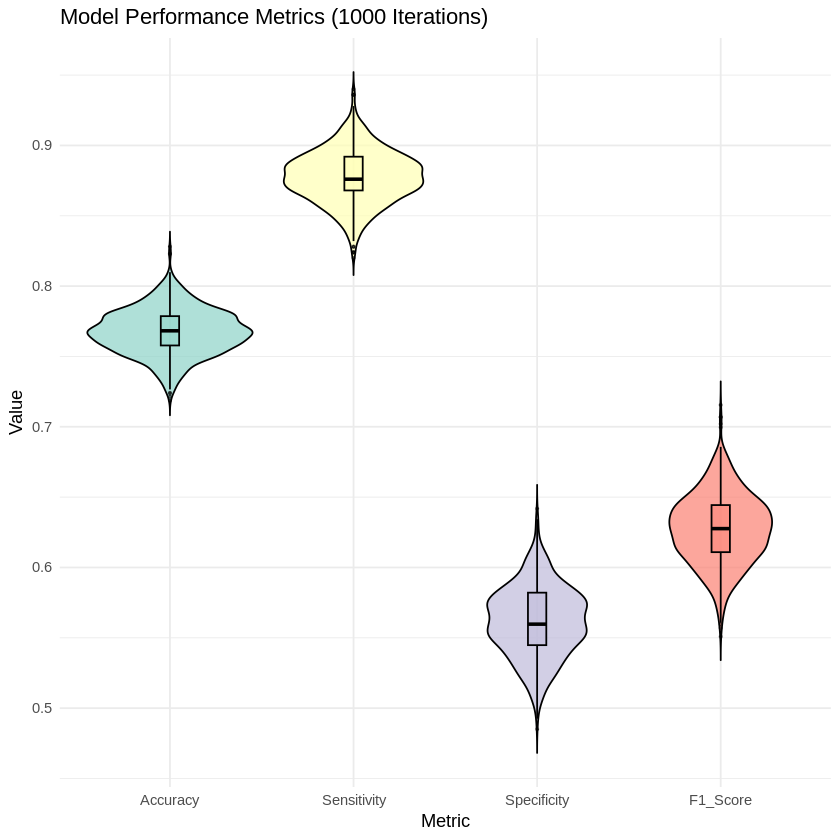

In [ ]:
results_without_iteration <- results[, -1]

results_long <- melt(results_without_iteration, variable.name = "Metric", value.name = "Value")

ggplot(results_long, aes(x = Metric, y = Value, fill = Metric)) +
  geom_violin(trim = FALSE, color = "black", alpha = 0.7) +
  geom_boxplot(width = 0.1, outlier.size = 0.5, color = "black", alpha = 0.5) +
  theme_minimal() +
  scale_fill_brewer(palette = "Set3") +
  labs(title = "Model Performance Metrics (1000 Iterations)",
       x = "Metric", y = "Value") +
  theme(legend.position = "none")


###  Adjusting the ratio of test to training data


In [ ]:
data$Outcome <- as.factor(data$Outcome)

results <- data.frame(
  SplitRate = numeric(),
  Accuracy = numeric(),
  Sensitivity = numeric(),
  Specificity = numeric(),
  F1_Score = numeric()
)

set.seed(123)
split_rates <- seq(0.05, 0.95, by = 0.05)

for (p in split_rates) {
  train_index <- createDataPartition(data$Outcome, p = p, list = FALSE)
  train_data <- data[train_index, ]
  test_data <- data[-train_index, ]


  train_data_scaled <- zscore_normalize(train_data)
  test_data_scaled <- zscore_normalize(test_data)

  lda_model <- lda(Outcome ~ ., data = train_data_scaled)

  test_predictions <- predict(lda_model, newdata = test_data_scaled)$class
  confusion_matrix <- confusionMatrix(test_predictions, test_data_scaled$Outcome)

  accuracy <- mean(test_predictions == test_data_scaled$Outcome)
  sensitivity <- confusion_matrix$byClass["Sensitivity"]
  specificity <- confusion_matrix$byClass["Specificity"]
  f1_score <- F1_Score(
    y_true = test_data_scaled$Outcome,
    y_pred = test_predictions,
    positive = levels(test_data_scaled$Outcome)[2]
  )

  results <- rbind(results, data.frame(SplitRate = p, Accuracy = accuracy,
                                       Sensitivity = sensitivity,
                                       Specificity = specificity,
                                       F1_Score = f1_score))
}

results_long <- melt(results, id.vars = "SplitRate", variable.name = "Metric", value.name = "Value")

In [ ]:
colnames(results)

[1] "SplitRate"   "Accuracy"    "Sensitivity" "Specificity" "F1_Score"

In [ ]:
best_accuracy <- results[which.max(results$Accuracy), ]
best_f1_score <- results[which.max(results$F1_Score), ]
best_sensitivity <- results[which.max(results$Sensitivity), ]
best_specificity <- results[which.max(results$Specificity), ]

cat("Best Split Rate for Accuracy:\n")
print(best_accuracy)

cat("\nBest Split Rate for F1-Score:\n")
print(best_f1_score)

cat("\nBest Split Rate for Sensitivity:\n")
print(best_sensitivity)

cat("\nBest Split Rate for Specificity:\n")
print(best_specificity)

Best Split Rate for Accuracy:
              SplitRate  Accuracy Sensitivity Specificity F1_Score
Sensitivity18      0.95 0.8421053        0.92   0.6923077     0.75

Best Split Rate for F1-Score:
              SplitRate  Accuracy Sensitivity Specificity F1_Score
Sensitivity18      0.95 0.8421053        0.92   0.6923077     0.75

Best Split Rate for Sensitivity:
              SplitRate  Accuracy Sensitivity Specificity F1_Score
Sensitivity18      0.95 0.8421053        0.92   0.6923077     0.75

Best Split Rate for Specificity:
              SplitRate  Accuracy Sensitivity Specificity F1_Score
Sensitivity18      0.95 0.8421053        0.92   0.6923077     0.75


Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”
`geom_smooth()` using formula = 'y ~ x'


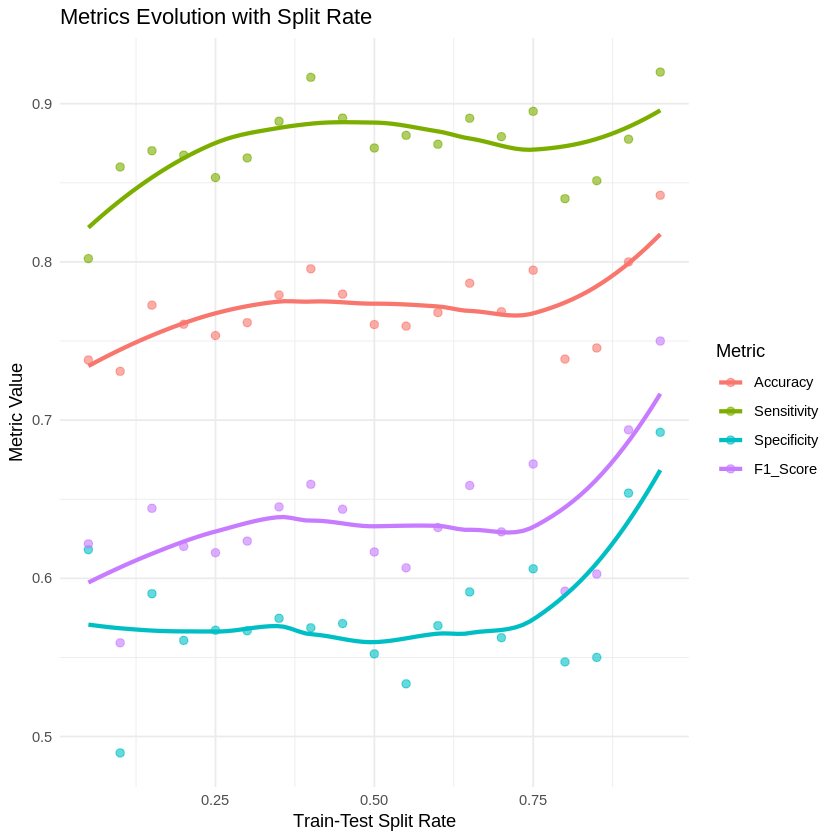

In [ ]:
ggplot(results_long, aes(x = SplitRate, y = Value, color = Metric)) +
  geom_point(size = 2, alpha = 0.6) +
  geom_smooth(method = "loess", se = FALSE, size = 1.2) +
  theme_minimal() +
  labs(title = "Metrics Evolution with Split Rate",
       x = "Train-Test Split Rate",
       y = "Metric Value",
       color = "Metric")


### Feature analysis (evaluation of the influence and behavior of different features in the dataset)


[1] "مدل LDA آموزش‌داده‌شده:"
Call:
lda(Outcome ~ ., data = train_data_scaled)

Prior probabilities of groups:
        0         1 
0.6506849 0.3493151 

Group means:
  Pregnancies    Glucose BloodPressure SkinThickness    Insulin        BMI
0  -0.1597876 -0.3384225   -0.05182269   -0.06080124 -0.0954394 -0.2167634
1   0.2976436  0.6303949    0.09653246    0.11325721  0.1777793  0.4037750
  DiabetesPedigreeFunction        Age
0               -0.1257513 -0.1709598
1                0.2342425  0.3184546

Coefficients of linear discriminants:
                                 LD1
Pregnancies               0.32015008
Glucose                   0.86473944
BloodPressure            -0.20646783
SkinThickness             0.02601859
Insulin                  -0.10690905
BMI                       0.48019917
DiabetesPedigreeFunction  0.20943348
Age                       0.13375848
[1] "ضرایب LDA برای هر ویژگی:"
                                 LD1
Pregnancies               0.32015008
Glucose          

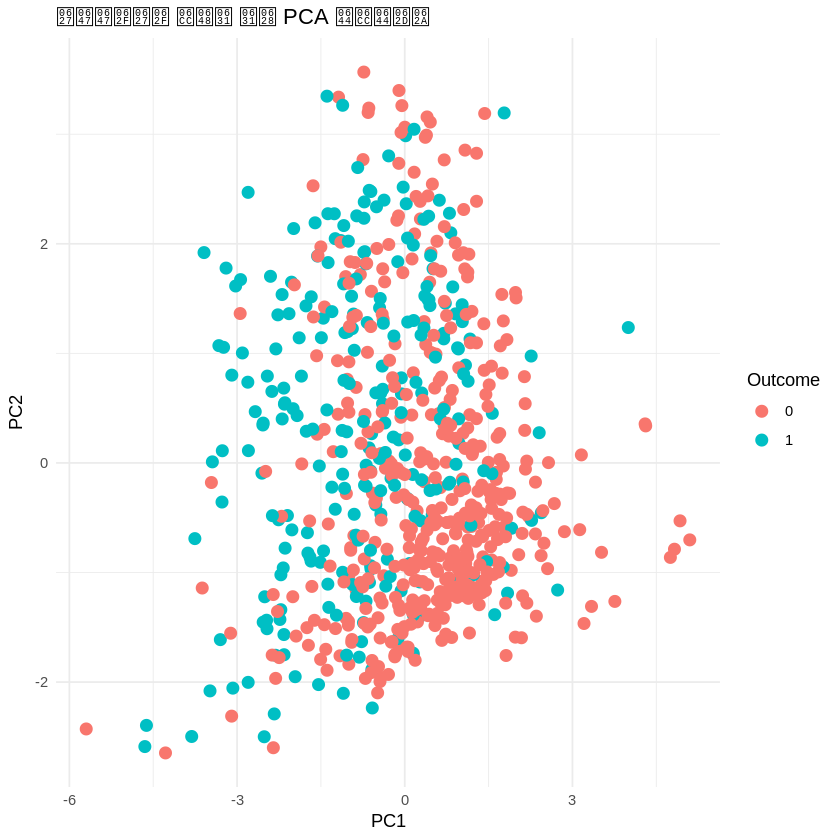

In [ ]:
set.seed(123)

data$Outcome <- as.factor(data$Outcome)

train_data_scaled <- zscore_normalize(train_data)
test_data_scaled <- zscore_normalize(test_data)

lda_model <- lda(Outcome ~ ., data = train_data_scaled)

print("مدل LDA آموزش‌داده‌شده:")
print(lda_model)

lda_coefficients <- lda_model$scaling
print("ضرایب LDA برای هر ویژگی:")
print(lda_coefficients)

normalized_coefficients <- apply(lda_coefficients, 2, function(x) abs(x) / sum(abs(x)))
print("ضرایب نرمال‌شده:")
print(normalized_coefficients)

pca_result <- prcomp(train_data_scaled[, -ncol(train_data_scaled)], center = TRUE, scale. = TRUE)

explained_variance <- summary(pca_result)$importance[2, ]
print("درصد واریانس توضیح داده‌شده توسط هر مولفه:")
print(explained_variance)

pca_data <- as.data.frame(pca_result$x)
pca_data$Outcome <- train_data_scaled$Outcome
ggplot(pca_data, aes(PC1, PC2, color = Outcome)) +
  geom_point(size = 3) +
  labs(title = "تحلیل PCA بر روی داده‌ها") +
  theme_minimal()

In [ ]:
pca_loadings <- pca_result$rotation

print("بارهای مؤلفه‌های اصلی (Principal Component Loadings):")
print(pca_loadings)

[1] "بارهای مؤلفه‌های اصلی (Principal Component Loadings):"
                                PC1        PC2         PC3          PC4
Pregnancies              -0.1364385  0.5916401 -0.01357031 -0.122198476
Glucose                  -0.3983022  0.1517457  0.47241035  0.448698479
BloodPressure            -0.3602432  0.2027555 -0.51536836 -0.001564524
SkinThickness            -0.4330655 -0.3300313 -0.25684923 -0.098599225
Insulin                  -0.4337817 -0.2649979  0.31035202  0.339404483
BMI                      -0.4482788 -0.1012984 -0.37164419 -0.064438798
DiabetesPedigreeFunction -0.2734737 -0.1327825  0.44839933 -0.804781847
Age                      -0.2037417  0.6154579  0.09781865 -0.083614402
                                PC5         PC6          PC7         PC8
Pregnancies              -0.4594495  0.20195726  0.602583272 -0.03525299
Glucose                   0.4062625  0.11148034  0.108392310 -0.45232815
BloodPressure             0.3215685 -0.65567008  0.173199042  0.01416214



###  Analyzing the change in coefficient values over 1000 epochs


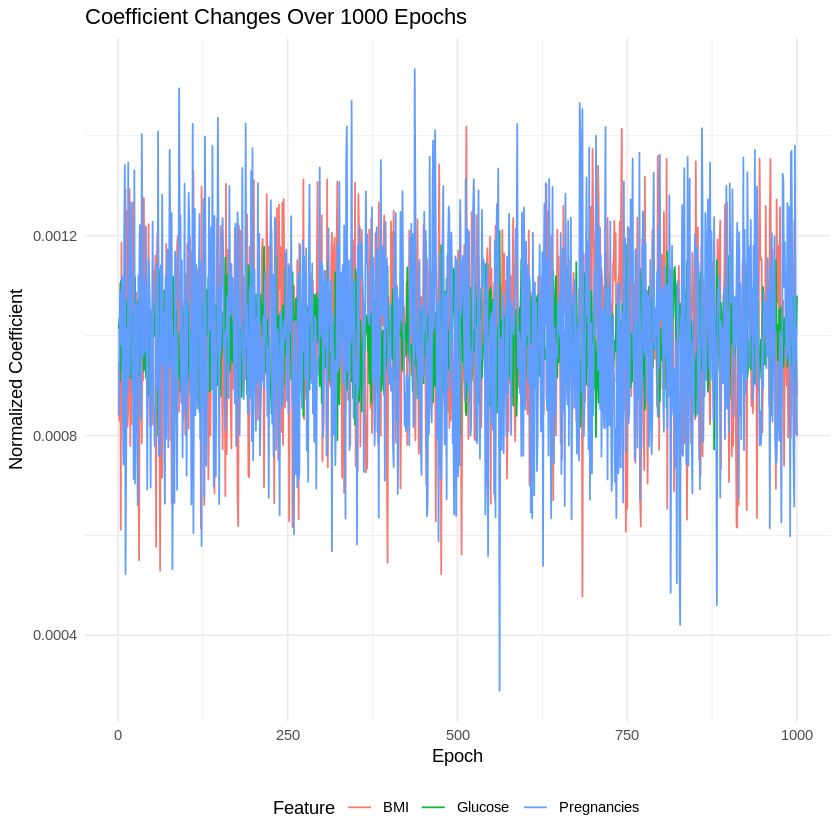

In [ ]:
data$Outcome <- as.factor(data$Outcome)

num_epochs <- 1000

coefficients_list <- list()

set.seed(123)
for (i in 1:num_epochs) {
  train_index <- createDataPartition(data$Outcome, p = 0.5, list = FALSE)
  train_data <- data[train_index, ]
  test_data <- data[-train_index, ]

  train_data_scaled <- zscore_normalize(train_data)
  test_data_scaled <- zscore_normalize(test_data)

  train_data_selected <- train_data_scaled[, selected_features]
  test_data_selected <- test_data_scaled[, selected_features]

  lda_model <- lda(Outcome ~ ., data = train_data_selected)

  lda_coefficients <- lda_model$scaling

  coefficients_list[[i]] <- abs(lda_coefficients)
}

coefficients_matrix <- do.call(cbind, coefficients_list)

normalized_coefficients <- apply(coefficients_matrix, 1, function(x) x / sum(x))

coefficients_df <- data.frame(normalized_coefficients)
coefficients_df$Epoch <- 1:num_epochs

coefficients_long <- reshape(coefficients_df,
                             varying = names(coefficients_df)[-ncol(coefficients_df)],
                             v.names = "Coefficient",
                             timevar = "Feature",
                             times = names(coefficients_df)[-ncol(coefficients_df)],
                             direction = "long")

ggplot(coefficients_long, aes(x = Epoch, y = Coefficient, color = Feature)) +
  geom_line() +
  labs(title = "Coefficient Changes Over 1000 Epochs",
       x = "Epoch", y = "Normalized Coefficient") +
  theme_minimal() +
  theme(legend.position = "bottom")


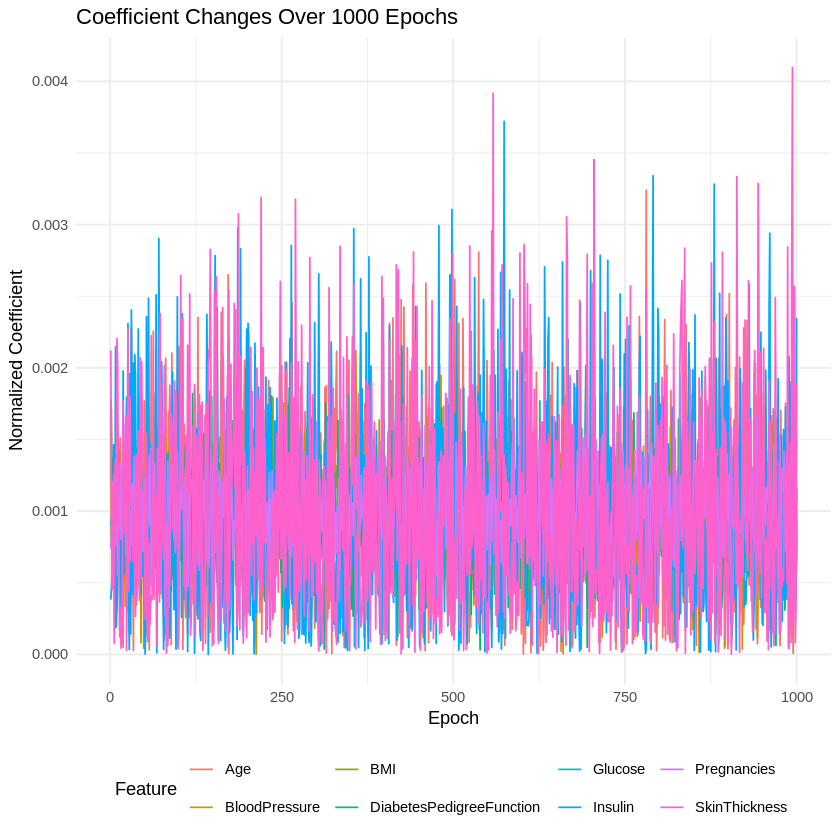

In [ ]:
data$Outcome <- as.factor(data$Outcome)

num_epochs <- 1000

coefficients_list <- list()

set.seed(123)
for (i in 1:num_epochs) {
  train_index <- createDataPartition(data$Outcome, p = 0.5, list = FALSE)
  train_data <- data[train_index, ]
  test_data <- data[-train_index, ]

  train_data_scaled <- zscore_normalize(train_data)
  test_data_scaled <- zscore_normalize(test_data)


  lda_model <- lda(Outcome ~ ., data = train_data_scaled)

  lda_coefficients <- lda_model$scaling

  coefficients_list[[i]] <- abs(lda_coefficients)
}

coefficients_matrix <- do.call(cbind, coefficients_list)

normalized_coefficients <- apply(coefficients_matrix, 1, function(x) x / sum(x))

coefficients_df <- data.frame(normalized_coefficients)
coefficients_df$Epoch <- 1:num_epochs

coefficients_long <- reshape(coefficients_df,
                             varying = names(coefficients_df)[-ncol(coefficients_df)],
                             v.names = "Coefficient",
                             timevar = "Feature",
                             times = names(coefficients_df)[-ncol(coefficients_df)],
                             direction = "long")

ggplot(coefficients_long, aes(x = Epoch, y = Coefficient, color = Feature)) +
  geom_line() +
  labs(title = "Coefficient Changes Over 1000 Epochs",
       x = "Epoch", y = "Normalized Coefficient") +
  theme_minimal() +
  theme(legend.position = "bottom")



###  Training the model using the most important (selected) features   


In [ ]:
selected_features <- c("DiabetesPedigreeFunction", "BMI", "BloodPressure", "Glucose", "Pregnancies", "Outcome")

train_data_selected <- train_data_scaled[, selected_features]
test_data_selected <- test_data_scaled[, selected_features]

lda_model_selected <- lda(Outcome ~ ., data = train_data_selected)

predictions <- predict(lda_model_selected, test_data_selected)$class

conf_matrix <- table(Predicted = predictions, Actual = test_data_selected$Outcome)
accuracy <- sum(diag(conf_matrix)) / sum(conf_matrix)
sensitivity <- conf_matrix[2, 2] / sum(conf_matrix[, 2])
specificity <- conf_matrix[1, 1] / sum(conf_matrix[, 1])
f1_score <- 2 * ((sensitivity * specificity) / (sensitivity + specificity))

cat("Confusion Matrix:\n")
print(conf_matrix)
cat("\nAccuracy:", accuracy,
    "\nSensitivity:", sensitivity,
    "\nSpecificity:", specificity,
    "\nF1-Score:", f1_score, "\n")


Confusion Matrix:
         Actual
Predicted  0  1
        0 23  5
        1  2  8

Accuracy: 0.8157895 
Sensitivity: 0.6153846 
Specificity: 0.92 
F1-Score: 0.7374749 


In [ ]:
selected_features <- c("BMI", "Glucose", "Pregnancies", "Outcome")

train_data_selected <- train_data_scaled[, selected_features]
test_data_selected <- test_data_scaled[, selected_features]

lda_model_selected <- lda(Outcome ~ ., data = train_data_selected)

predictions <- predict(lda_model_selected, test_data_selected)$class

conf_matrix <- table(Predicted = predictions, Actual = test_data_selected$Outcome)
accuracy <- sum(diag(conf_matrix)) / sum(conf_matrix)
sensitivity <- conf_matrix[2, 2] / sum(conf_matrix[, 2])
specificity <- conf_matrix[1, 1] / sum(conf_matrix[, 1])
f1_score <- 2 * ((sensitivity * specificity) / (sensitivity + specificity))

cat("Confusion Matrix:\n")
print(conf_matrix)
cat("\nAccuracy:", accuracy,
    "\nSensitivity:", sensitivity,
    "\nSpecificity:", specificity,
    "\nF1-Score:", f1_score, "\n")


Confusion Matrix:
         Actual
Predicted  0  1
        0 22  4
        1  3  9

Accuracy: 0.8157895 
Sensitivity: 0.6923077 
Specificity: 0.88 
F1-Score: 0.7749511 



###   Training and testing the LDA model 1000 times with the most important (selected) features


In [ ]:
num_epochs <- 1000

results <- data.frame(
  Iteration = integer(num_epochs),
  Accuracy = numeric(num_epochs),
  Sensitivity = numeric(num_epochs),
  Specificity = numeric(num_epochs),
  F1_Score = numeric(num_epochs)
)

selected_features <- c("DiabetesPedigreeFunction", "BMI", "BloodPressure", "Glucose", "Pregnancies", "Outcome")

set.seed(123)

for (i in 1:num_epochs) {
  train_index <- createDataPartition(data$Outcome, p = 0.5, list = FALSE)
  train_data <- data[train_index, ]
  test_data <- data[-train_index, ]

  train_data_scaled <- zscore_normalize(train_data)
  test_data_scaled <- zscore_normalize(test_data)

  train_data_selected <- train_data_scaled[, selected_features]
  test_data_selected <- test_data_scaled[, selected_features]

  lda_model_selected <- lda(Outcome ~ ., data = train_data_selected)

  predictions <- predict(lda_model_selected, test_data_selected)$class

  conf_matrix <- table(Predicted = predictions, Actual = test_data_selected$Outcome)

  results[i, "Iteration"] <- i
  results[i, "Accuracy"] <- sum(diag(conf_matrix)) / sum(conf_matrix)
  results[i, "Sensitivity"] <- conf_matrix[2, 2] / sum(conf_matrix[, 2])
  results[i, "Specificity"] <- conf_matrix[1, 1] / sum(conf_matrix[, 1])
  results[i, "F1_Score"] <- 2 * ((results[i, "Sensitivity"] * results[i, "Specificity"]) / (results[i, "Sensitivity"] + results[i, "Specificity"]))
}

mean_accuracy <- mean(results$Accuracy)
sd_accuracy <- sd(results$Accuracy)
mean_sensitivity <- mean(results$Sensitivity)
sd_sensitivity <- sd(results$Sensitivity)
mean_specificity <- mean(results$Specificity)
sd_specificity <- sd(results$Specificity)
mean_f1_score <- mean(results$F1_Score)
sd_f1_score <- sd(results$F1_Score)

cat("Performance Metrics for 1000 Epochs:\n")
cat("Mean Accuracy:", mean_accuracy, "±", sd_accuracy, "\n")
cat("Mean Sensitivity:", mean_sensitivity, "±", sd_sensitivity, "\n")
cat("Mean Specificity:", mean_specificity, "±", sd_specificity, "\n")
cat("Mean F1-Score:", mean_f1_score, "±", sd_f1_score, "\n")

summary(results)



Performance Metrics for 1000 Epochs:
Mean Accuracy: 0.7694115 ± 0.01547611 
Mean Sensitivity: 0.5604104 ± 0.02312901 
Mean Specificity: 0.881436 ± 0.01719842 
Mean F1-Score: 0.6849172 ± 0.01936438 


   Iteration         Accuracy       Sensitivity      Specificity    
 Min.   :   1.0   Min.   :0.7214   Min.   :0.5000   Min.   :0.8240  
 1st Qu.: 250.8   1st Qu.:0.7578   1st Qu.:0.5448   1st Qu.:0.8680  
 Median : 500.5   Median :0.7682   Median :0.5597   Median :0.8800  
 Mean   : 500.5   Mean   :0.7694   Mean   :0.5604   Mean   :0.8814  
 3rd Qu.: 750.2   3rd Qu.:0.7786   3rd Qu.:0.5746   3rd Qu.:0.8920  
 Max.   :1000.0   Max.   :0.8255   Max.   :0.6493   Max.   :0.9400  
    F1_Score     
 Min.   :0.6291  
 1st Qu.:0.6706  
 Median :0.6848  
 Mean   :0.6849  
 3rd Qu.:0.6977  
 Max.   :0.7529  

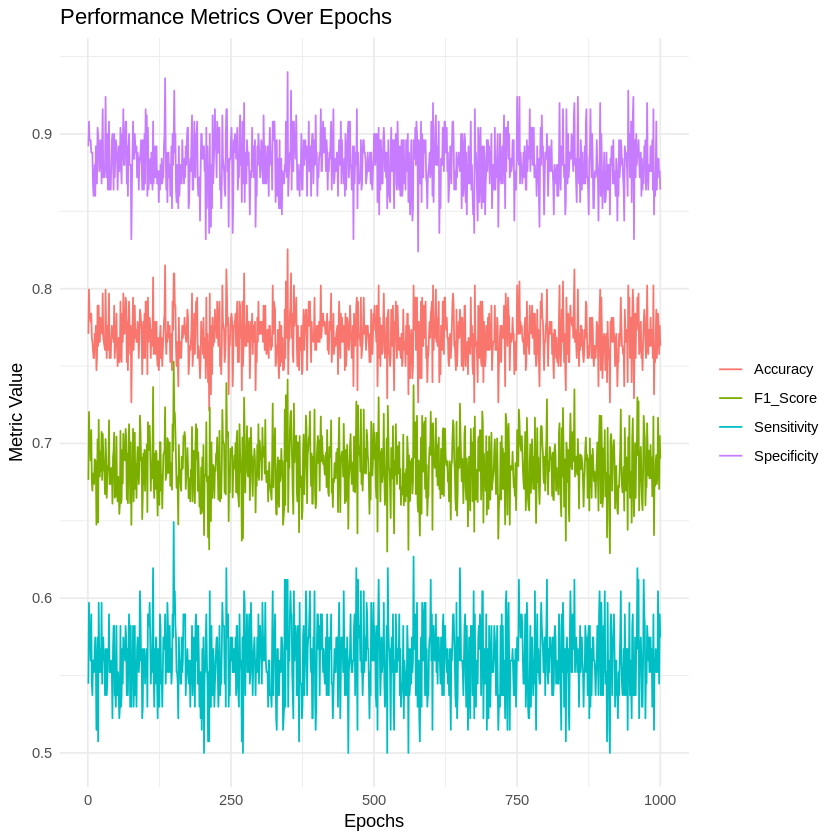

In [ ]:
metrics_data <- data.frame(
  Epoch = rep(1:num_epochs, 4),
  Metric = rep(c("Accuracy", "Sensitivity", "Specificity", "F1_Score"), each = num_epochs),
  Value = c(results$Accuracy, results$Sensitivity, results$Specificity, results$F1_Score)
)

ggplot(metrics_data, aes(x = Epoch, y = Value, color = Metric)) +
  geom_line() +
  labs(title = "Performance Metrics Over Epochs",
       x = "Epochs", y = "Metric Value") +
  theme_minimal() +
  theme(legend.title = element_blank())


No id variables; using all as measure variables



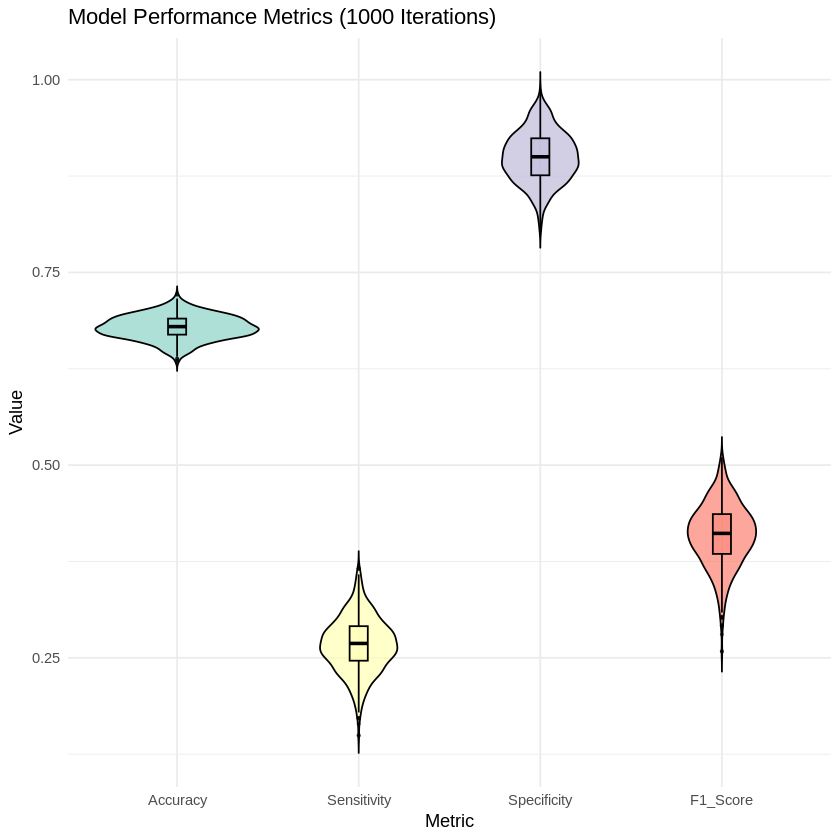

In [ ]:
results_without_iteration <- results[, -1]

results_long <- melt(results_without_iteration, variable.name = "Metric", value.name = "Value")

ggplot(results_long, aes(x = Metric, y = Value, fill = Metric)) +
  geom_violin(trim = FALSE, color = "black", alpha = 0.7) +
  geom_boxplot(width = 0.1, outlier.size = 0.5, color = "black", alpha = 0.5) +
  theme_minimal() +
  scale_fill_brewer(palette = "Set3") +
  labs(title = "Model Performance Metrics (1000 Iterations)",
       x = "Metric", y = "Value") +
  theme(legend.position = "none")


In [ ]:
num_epochs <- 1000

results <- data.frame(
  Iteration = integer(num_epochs),
  Accuracy = numeric(num_epochs),
  Sensitivity = numeric(num_epochs),
  Specificity = numeric(num_epochs),
  F1_Score = numeric(num_epochs)
)

selected_features <- c("BMI", "Glucose", "Pregnancies", "Outcome")

set.seed(123)

for (i in 1:num_epochs) {
  train_index <- createDataPartition(data$Outcome, p = 0.5, list = FALSE)
  train_data <- data[train_index, ]
  test_data <- data[-train_index, ]

  train_data_scaled <- zscore_normalize(train_data)
  test_data_scaled <- zscore_normalize(test_data)

  train_data_selected <- train_data_scaled[, selected_features]
  test_data_selected <- test_data_scaled[, selected_features]

  lda_model_selected <- lda(Outcome ~ ., data = train_data_selected)

  predictions <- predict(lda_model_selected, test_data_selected)$class

  conf_matrix <- table(Predicted = predictions, Actual = test_data_selected$Outcome)

  results[i, "Iteration"] <- i
  results[i, "Accuracy"] <- sum(diag(conf_matrix)) / sum(conf_matrix)
  results[i, "Sensitivity"] <- conf_matrix[2, 2] / sum(conf_matrix[, 2])
  results[i, "Specificity"] <- conf_matrix[1, 1] / sum(conf_matrix[, 1])
  results[i, "F1_Score"] <- 2 * ((results[i, "Sensitivity"] * results[i, "Specificity"]) / (results[i, "Sensitivity"] + results[i, "Specificity"]))
}

mean_accuracy <- mean(results$Accuracy)
sd_accuracy <- sd(results$Accuracy)
mean_sensitivity <- mean(results$Sensitivity)
sd_sensitivity <- sd(results$Sensitivity)
mean_specificity <- mean(results$Specificity)
sd_specificity <- sd(results$Specificity)
mean_f1_score <- mean(results$F1_Score)
sd_f1_score <- sd(results$F1_Score)

cat("Performance Metrics for 1000 Epochs:\n")
cat("Mean Accuracy:", mean_accuracy, "±", sd_accuracy, "\n")
cat("Mean Sensitivity:", mean_sensitivity, "±", sd_sensitivity, "\n")
cat("Mean Specificity:", mean_specificity, "±", sd_specificity, "\n")
cat("Mean F1-Score:", mean_f1_score, "±", sd_f1_score, "\n")

summary(results)



Performance Metrics for 1000 Epochs:
Mean Accuracy: 0.7621875 ± 0.01480301 
Mean Sensitivity: 0.554291 ± 0.02190777 
Mean Specificity: 0.87362 ± 0.01691052 
Mean F1-Score: 0.6779945 ± 0.01832116 


   Iteration         Accuracy       Sensitivity      Specificity    
 Min.   :   1.0   Min.   :0.7135   Min.   :0.4776   Min.   :0.8200  
 1st Qu.: 250.8   1st Qu.:0.7520   1st Qu.:0.5373   1st Qu.:0.8640  
 Median : 500.5   Median :0.7630   Median :0.5522   Median :0.8760  
 Mean   : 500.5   Mean   :0.7622   Mean   :0.5543   Mean   :0.8736  
 3rd Qu.: 750.2   3rd Qu.:0.7734   3rd Qu.:0.5672   3rd Qu.:0.8840  
 Max.   :1000.0   Max.   :0.8047   Max.   :0.6194   Max.   :0.9200  
    F1_Score     
 Min.   :0.6139  
 1st Qu.:0.6658  
 Median :0.6786  
 Mean   :0.6780  
 3rd Qu.:0.6910  
 Max.   :0.7338  

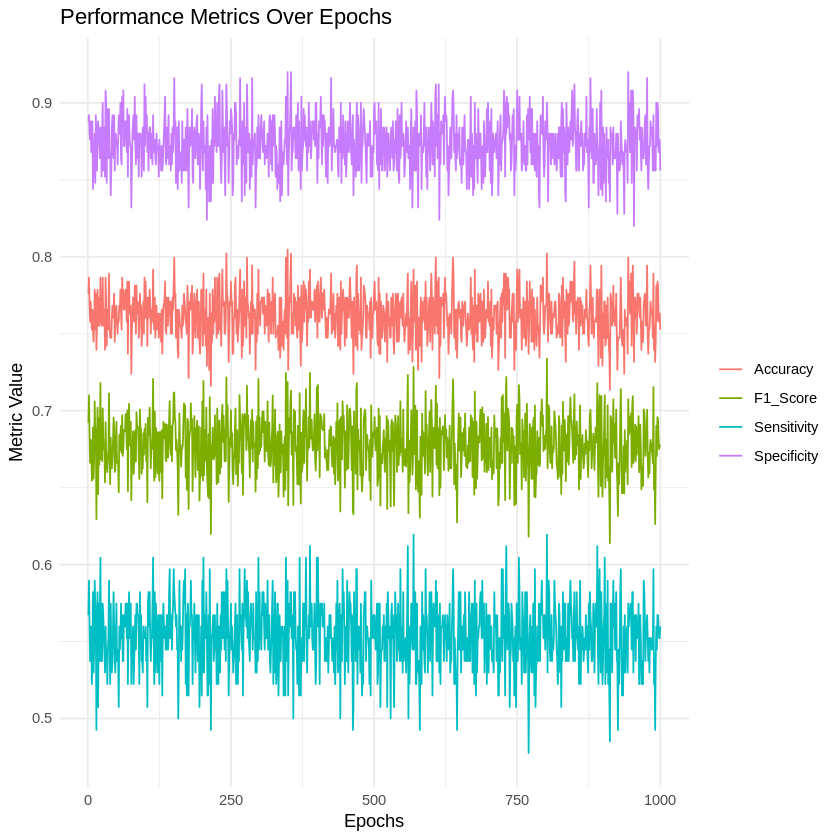

In [ ]:
metrics_data <- data.frame(
  Epoch = rep(1:num_epochs, 4),
  Metric = rep(c("Accuracy", "Sensitivity", "Specificity", "F1_Score"), each = num_epochs),
  Value = c(results$Accuracy, results$Sensitivity, results$Specificity, results$F1_Score)
)

ggplot(metrics_data, aes(x = Epoch, y = Value, color = Metric)) +
  geom_line() +
  labs(title = "Performance Metrics Over Epochs",
       x = "Epochs", y = "Metric Value") +
  theme_minimal() +
  theme(legend.title = element_blank())


No id variables; using all as measure variables



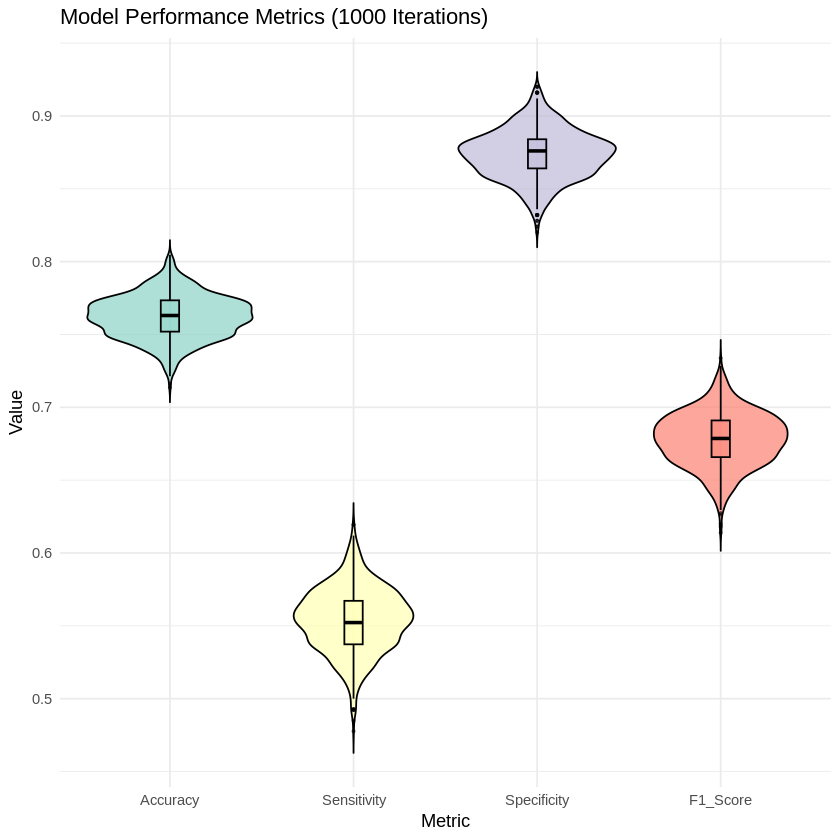

In [ ]:
results_without_iteration <- results[, -1]

results_long <- melt(results_without_iteration, variable.name = "Metric", value.name = "Value")

ggplot(results_long, aes(x = Metric, y = Value, fill = Metric)) +
  geom_violin(trim = FALSE, color = "black", alpha = 0.7) +
  geom_boxplot(width = 0.1, outlier.size = 0.5, color = "black", alpha = 0.5) +
  theme_minimal() +
  scale_fill_brewer(palette = "Set3") +
  labs(title = "Model Performance Metrics (1000 Iterations)",
       x = "Metric", y = "Value") +
  theme(legend.position = "none")



###  Model comparison with other algorithms including Random Forest, Decision Tree, and Logistic Regression

In [ ]:
data$Outcome <- as.factor(data$Outcome)

set.seed(123)
train_index <- createDataPartition(data$Outcome, p = 0.5, list = FALSE)
train_data <- data[train_index, ]
test_data <- data[-train_index, ]

train_data_scaled <- zscore_normalize(train_data)
test_data_scaled <- zscore_normalize(test_data)

lda_model <- lda(Outcome ~ ., data = train_data_scaled)
lda_predictions <- predict(lda_model, test_data_scaled)$class

#  Logistic Regression
logistic_model <- glm(Outcome ~ ., data = train_data, family = binomial)
logistic_probabilities <- predict(logistic_model, test_data, type = "response")
logistic_predictions <- ifelse(logistic_probabilities > 0.5, 1, 0)

#  Decision Tree
tree_model <- tree(Outcome ~ ., data = train_data, method = "class")
tree_predictions <- predict(tree_model, test_data, type = "class")

#  Random Forest
rf_model <- randomForest(Outcome ~ ., data = train_data, ntree = 100)
rf_predictions <- predict(rf_model, test_data)

evaluate_model <- function(true_labels, predicted_labels) {
  confusion <- table(Predicted = predicted_labels, Actual = true_labels)
  accuracy <- sum(diag(confusion)) / sum(confusion)
  sensitivity <- confusion[2, 2] / sum(confusion[, 2])
  specificity <- confusion[1, 1] / sum(confusion[, 1])
  f1_score <- 2 * ((sensitivity * specificity) / (sensitivity + specificity))
  return(c(Accuracy = accuracy, Sensitivity = sensitivity, Specificity = specificity, F1_Score = f1_score))
}

lda_metrics <- evaluate_model(test_data$Outcome, lda_predictions)
logistic_metrics <- evaluate_model(test_data$Outcome, logistic_predictions)
tree_metrics <- evaluate_model(test_data$Outcome, tree_predictions)
rf_metrics <- evaluate_model(test_data$Outcome, rf_predictions)

results <- data.frame(
  Model = c("LDA", "Logistic Regression", "Decision Tree", "Random Forest"),
  Accuracy = c(lda_metrics["Accuracy"], logistic_metrics["Accuracy"], tree_metrics["Accuracy"], rf_metrics["Accuracy"]),
  Sensitivity = c(lda_metrics["Sensitivity"], logistic_metrics["Sensitivity"], tree_metrics["Sensitivity"], rf_metrics["Sensitivity"]),
  Specificity = c(lda_metrics["Specificity"], logistic_metrics["Specificity"], tree_metrics["Specificity"], rf_metrics["Specificity"]),
  F1_Score = c(lda_metrics["F1_Score"], logistic_metrics["F1_Score"], tree_metrics["F1_Score"], rf_metrics["F1_Score"])
)

print(results)


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



                Model  Accuracy Sensitivity Specificity  F1_Score
1                 LDA 0.7604167   0.5298507       0.884 0.6625707
2 Logistic Regression 0.7656250   0.5522388       0.880 0.6786161
3       Decision Tree 0.7604167   0.5895522       0.852 0.6968856
4       Random Forest 0.7812500   0.5671642       0.896 0.6946303



###   Assessment of the stability and consistency of the LDA model


In [ ]:

data$Outcome <- as.factor(data$Outcome)

num_iterations <- 100
metrics_list <- data.frame(Accuracy = numeric(),
                           Sensitivity = numeric(),
                           Specificity = numeric(),
                           F1_Score = numeric())


evaluate_model <- function(true_labels, predicted_labels) {
  confusion <- table(Predicted = predicted_labels, Actual = true_labels)
  accuracy <- sum(diag(confusion)) / sum(confusion)
  sensitivity <- confusion[2, 2] / sum(confusion[, 2])
  specificity <- confusion[1, 1] / sum(confusion[, 1])
  f1_score <- 2 * ((sensitivity * specificity) / (sensitivity + specificity))
  return(c(Accuracy = accuracy, Sensitivity = sensitivity, Specificity = specificity, F1_Score = f1_score))
}


set.seed(123)
for (i in 1:num_iterations) {
  train_index <- createDataPartition(data$Outcome, p = 0.5, list = FALSE)
  train_data <- data[train_index, ]
  test_data <- data[-train_index, ]

  train_data_scaled <- zscore_normalize(train_data)
  test_data_scaled <- zscore_normalize(test_data)

  lda_model <- lda(Outcome ~ ., data = train_data_scaled)
  lda_predictions <- predict(lda_model, test_data_scaled)$class

  metrics <- evaluate_model(test_data_scaled$Outcome, lda_predictions)

  metrics_list <- rbind(metrics_list, metrics)
}

stability_results <- data.frame(
  Metric = c("Accuracy", "Sensitivity", "Specificity", "F1_Score"),
  Mean = colMeans(metrics_list),
  SD = apply(metrics_list, 2, sd)
)

rownames(stability_results) <- NULL
print("نتایج ارزیابی پایداری مدل:")
print(stability_results)


[1] "نتایج ارزیابی پایداری مدل:"
       Metric      Mean         SD
1    Accuracy 0.7684375 0.01427167
2 Sensitivity 0.5591791 0.02302611
3 Specificity 0.8806000 0.01624435
4    F1_Score 0.6837243 0.01863331
